# In this notebook we compare 4 different NLP models

We chose:
 - GloVe as a baseline model
 - LSTM 
 - GPT2 (as a decoder transformer model)
 - BERT (as an encoder transformer model)

For each model, we extracted weights from the model dynamic (or static) as a way of representing artificial brain activations resulting from natural language processing.
These activations were shaped by the results of the section 'ActivationExtractionProtocol'.

In [342]:
import warnings
warnings.simplefilter(action='ignore')

import os
import gc
import glob
import itertools
from tqdm import tqdm
from itertools import combinations
from joblib import Parallel, delayed

import umap
import scipy
import hdbscan
import nistats
import numpy as np
import pandas as pd
#import pingouin as pg
from sklearn import manifold
import statsmodels.api as sm 
from statsmodels.formula.api import ols   
from sklearn.decomposition import PCA, FastICA
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import AgglomerativeClustering, KMeans

%matplotlib inline
import matplotlib
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

import nibabel as nib
import nilearn
from nilearn.image import load_img, mean_img, index_img, threshold_img, math_img, smooth_img, new_img_like
from nilearn.input_data import NiftiMapsMasker, NiftiMasker, NiftiLabelsMasker, MultiNiftiMasker
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from nilearn import datasets
from scipy.stats import norm
from nilearn.surface import vol_to_surf

import utils 
import reporting
from logger import Logger
from linguistics_info import *

### Paths

In [3]:
language = 'english'

In [4]:
PROJECT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/ROI_masks/global_masker_95%_{language}"
ALL_MASKS_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/ROI_masks/"
SAVING_FOLDER = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/{language}"
TMP_FOLDER = f"/home/ap259944/tmp"

In [5]:
PROJECT_PATH = f"/Volumes/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/Volumes/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/Volumes/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/Volumes/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/Volumes/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/ROI_masks/global_masker_95%_{language}"
ALL_MASKS_PATH = f"/Volumes/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/ROI_masks/"
SAVING_FOLDER = f"/Volumes/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/{language}"
TMP_FOLDER = f"/Users/alexpsq/tmp"


### Functions

In [5]:
def extract_roi_data(map_, masker, mask_img=None):
    try:
        array = masker.transform(map_)[0]
        if mask_img is not None:
            mask = masker.transform(mask_img)
            mask[np.isnan(mask)] = 0
            mask = mask.astype(int)
            mask = mask[0].astype(bool)
            array = array[mask]
        maximum = np.max(array)
        third_quartile = np.percentile(array, 75)
        median = np.median(array)
        size = len(array.reshape(-1))
    except ValueError as e:
        print(e)
        maximum = np.nan
        third_quartile = np.nan
        median = np.nan
        size = 0
    return median, third_quartile, maximum, size

In [6]:
def fit_per_roi(maps, atlas_maps, labels, global_mask, PROJECT_PATH, mask_img=None):
    print("\tLooping through labeled masks...")
    median = np.zeros((len(labels), len(maps)))
    third_quartile = np.zeros((len(labels), len(maps)))
    maximum = np.zeros((len(labels), len(maps)))
    size = np.zeros((len(labels), len(maps)))
    for index_mask in tqdm(range(len(labels))):
        masker = utils.get_roi_mask(atlas_maps, index_mask, labels, global_mask=global_mask, PROJECT_PATH=PROJECT_PATH)
        results = Parallel(n_jobs=-2)(delayed(extract_roi_data)(
            map_, 
            masker, 
            mask_img=mask_img
        ) for map_ in maps)
        results = list(zip(*results))
        median[index_mask, :] = np.hstack(np.array(results[0]))
        third_quartile[index_mask, :] = np.hstack(np.array(results[1]))
        maximum[index_mask, :] = np.hstack(np.array(results[2]))
        size[index_mask, :] = np.hstack(np.array(results[3]))
            
            
    print("\t\t-->Done")
    return median, third_quartile, maximum, size

In [7]:
def get_t_test(maps, method='median'):
    data = []

    for index, model in enumerate(maps):
        median_, third_quartile_, maximum_, size_ = fit_per_roi(
            model, 
            atlas_maps, 
            labels, 
            global_mask=None, 
            mask_img=os.path.join(ALL_MASKS_PATH, 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
            PROJECT_PATH=PROJECT_PATH
        )
        if method=='median':
            data.append(median_)
        else:
            data.append(third_quartile_)

    array_pairs = zip(data[:-1], data[1:])
    t_test_list = []
    pvalue_list = []

    for a,b in array_pairs:
        tstat, pvalue = scipy.stats.ttest_1samp(b-a, 0, axis=1)
        t_test_list.append(tstat)
        pvalue_list.append(pvalue)

    t_tests = np.stack(t_test_list, axis=-1)
    pvalues = np.stack(pvalue_list, axis=-1)
    return t_tests, pvalues


In [8]:
def split_data(data, labels):
    left_data = []
    right_data = []
    for index, name in enumerate(labels):
        if 'Left' in name:
            left_data.append(data[index, :])
        elif 'Right' in name:
            right_data.append(data[index, :])
    return left_data, right_data

### Maskers

In [9]:
logger = Logger(os.path.join(PROJECT_PATH, 'logs.txt'))

global_masker_50 = reporting.fetch_masker(f"{ALL_MASKS_PATH}/global_masker_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)
global_masker_95 = reporting.fetch_masker(f"{ALL_MASKS_PATH}/global_masker_95%_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)


original_masker = global_masker_50
new_masker = global_masker_95
original_masker.set_params(detrend=False, standardize=False)
new_masker.set_params(detrend=False, standardize=False)


NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
            mask_args=None,
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f772a5f4be0>,
            mask_strategy='background', memory=Memory(location=None),
            memory_level=0, reports=True, sample_mask=None, sessions=None,
            smoothing_fwhm=None, standardize=False, t_r=None,
            target_affine=None, target_shape=None, verbose=0)

### Atlas

In [10]:
atlas_maps, labels = reporting.load_atlas()

In [11]:
Parietal = [
'Left Postcentral Gyrus',
'Right Postcentral Gyrus',
'Left Superior Parietal Lobule',
'Right Superior Parietal Lobule',
'Left Supramarginal Gyrus, anterior division',
'Right Supramarginal Gyrus, anterior division',
'Left Supramarginal Gyrus, posterior division',
'Right Supramarginal Gyrus, posterior division',
'Left Angular Gyrus',
'Right Angular Gyrus',
'Left Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
'Right Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
'Left Parietal Operculum Cortex',
'Right Parietal Operculum Cortex',
]

Frontal = [
'Left Frontal Pole',
'Right Frontal Pole',
'Left Superior Frontal Gyrus',
'Right Superior Frontal Gyrus',
'Left Middle Frontal Gyrus',
'Right Middle Frontal Gyrus',
'Left Inferior Frontal Gyrus, pars triangularis',
'Right Inferior Frontal Gyrus, pars triangularis',
'Left Inferior Frontal Gyrus, pars opercularis',
'Right Inferior Frontal Gyrus, pars opercularis',
'Left Precentral Gyrus',
'Right Precentral Gyrus',
'Left Frontal Medial Cortex',
'Right Frontal Medial Cortex',
'Left Frontal Orbital Cortex',
'Right Frontal Orbital Cortex',
'Left Frontal Operculum Cortex',
'Right Frontal Operculum Cortex',
'Left Central Opercular Cortex',
'Right Central Opercular Cortex',
]

Temporal = [
'Left Temporal Pole',
'Right Temporal Pole',
'Left Superior Temporal Gyrus, anterior division',
'Right Superior Temporal Gyrus, anterior division',
'Left Superior Temporal Gyrus, posterior division',
'Right Superior Temporal Gyrus, posterior division',
'Left Middle Temporal Gyrus, anterior division',
'Right Middle Temporal Gyrus, anterior division',
'Left Middle Temporal Gyrus, posterior division',
'Right Middle Temporal Gyrus, posterior division',
'Left Middle Temporal Gyrus, temporooccipital part',
'Right Middle Temporal Gyrus, temporooccipital part',
'Left Inferior Temporal Gyrus, anterior division',
'Right Inferior Temporal Gyrus, anterior division',
'Left Inferior Temporal Gyrus, posterior division',
'Right Inferior Temporal Gyrus, posterior division',
'Left Inferior Temporal Gyrus, temporooccipital part',
'Right Inferior Temporal Gyrus, temporooccipital part',
'Left Temporal Fusiform Cortex, anterior division',
'Right Temporal Fusiform Cortex, anterior division',
'Left Temporal Fusiform Cortex, posterior division',
'Right Temporal Fusiform Cortex, posterior division',
'Left Temporal Occipital Fusiform Cortex',
'Right Temporal Occipital Fusiform Cortex',
'Left Planum Polare',
'Right Planum Polare',
"Left Heschl's Gyrus (includes H1 and H2)",
"Right Heschl's Gyrus (includes H1 and H2)",
'Left Planum Temporale',
'Right Planum Temporale',
]

Occipital = [
'Left Lateral Occipital Cortex, superior division',
'Right Lateral Occipital Cortex, superior division',
'Left Lateral Occipital Cortex, inferior division',
'Right Lateral Occipital Cortex, inferior division',
'Left Intracalcarine Cortex',
'Right Intracalcarine Cortex',
'Left Lingual Gyrus',
'Right Lingual Gyrus',
'Left Occipital Fusiform Gyrus',
'Right Occipital Fusiform Gyrus',

'Left Supracalcarine Cortex',
'Right Supracalcarine Cortex',
'Left Occipital Pole',
'Right Occipital Pole',
]
Other = [
'Left Insular Cortex',
'Right Insular Cortex',
'Left Subcallosal Cortex',
'Right Subcallosal Cortex',
'Left Paracingulate Gyrus',
'Right Paracingulate Gyrus',
'Left Cingulate Gyrus, anterior division',
'Right Cingulate Gyrus, anterior division',
'Left Cingulate Gyrus, posterior division',
'Right Cingulate Gyrus, posterior division',
'Left Precuneous Cortex',
'Right Precuneous Cortex',
'Left Cuneal Cortex',
'Right Cuneal Cortex',
'Left Parahippocampal Gyrus, anterior division',
'Right Parahippocampal Gyrus, anterior division',
'Left Parahippocampal Gyrus, posterior division',
'Right Parahippocampal Gyrus, posterior division',
]

## Explainable ceiling

Before starting to look at the results of the comparison, we investigated how much signal could be explained putting aside noise from the activation and among subjects.

In [12]:
gc.collect()

76

In [10]:
path_to_fast_srm_data = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/fastsrm/'

In [11]:
files = sorted(glob.glob(os.path.join(path_to_fast_srm_data, 'sub-*/Pearson_sub-*.npy')))
data = [new_masker.inverse_transform(np.load(file_)) for file_ in files]
threshold_img = mean_img(data)

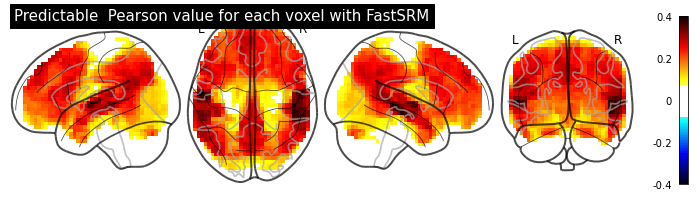

In [12]:
plotting.plot_glass_brain(threshold_img, colorbar=True, display_mode='lzry', plot_abs=False, title='Predictable  Pearson value for each voxel with FastSRM')
plt.show()

We computed the cross-validated Pearson coefficient value for each voxel.
Cross-validation was done over sessions and then over sampled test-set (26 sampled test-set of 5 subjects with replacement) from all subjects.
We therefore have X session-cross-validated Pearson coefficients brain maps.

In [13]:
threshold = 95
voxels_filter = np.percentile(new_masker.transform(threshold_img), threshold)
print('Pearson coefficient threshold computed on fastSRM maps: ', voxels_filter)

Pearson coefficient threshold computed on fastSRM maps:  0.2552285178668771


## Model comparison

Based on the results of the ActivationExtractionProtocol section, we compare the following models:
- Glove
- LSTM (1 hidden layer - 300 units)
- GPT-2 (small version - all hidden layers + PCA with 300 components - 20 sentences of pre-context - norm infinity normalization before the pipeline - norm infinity normalization before the ridge regression)
- BERT (small-version - cased - all hidden layers + PCA with 300 components - 7 sentences of pre-context - norm infinity normalization before the ridge regression)

In [13]:
model_names = [
    'glove_wiki_300_{}',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-hidden-layers',
    'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
]
legend_names = ['GloVe', 
                'LSTM-E600-H300-L1', 
                'GPT2-scaled-Hpca-pre-20',
                'BERT-Hpca-pre-7-post-0'
               ]

In [14]:
anova_comparison = reporting.prepare_data_for_anova(
    model_names, 
    atlas_maps, 
    labels, 
    MASKER_PATH,
    object_of_interest='Pearson_coeff', 
    language='english',
    OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english'
    )

	Looping through labeled masks...


100%|██████████| 97/97 [09:52<00:00,  6.11s/it]


In [15]:
saving_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/anovas/'
utils.check_folder(saving_folder)

In [16]:
anova_comparison.to_csv(os.path.join(saving_folder, 'anova_comparison.csv'))

In [32]:
anova_comparison = pd.read_csv(os.path.join(saving_folder, 'anova_comparison.csv'))
anova_table_comparison = pg.rm_anova(data=anova_comparison, dv='Pearson_coeff_3rd_quartile', within=['ROI', 'model'], subject='subject', correction=True)
anova_table_comparison

Source         SS  ddof1  ddof2        MS           F         p-unc  \
0          ROI  25.589010     96   4800  0.266552   98.787214  0.000000e+00   
1        model   1.614963      3    150  0.538321  153.246447  1.789735e-45   
2  ROI * model   0.527007    288  14400  0.001830   10.812672  0.000000e+00   

       p-GG-corr       np2       eps  
0  5.721933e-102  0.663950  0.094943  
1   1.141965e-27  0.753993  0.584922  
2   2.118411e-14  0.177803  0.029178

### Pairwise comparisons

In [84]:

model_tuples = list(itertools.combinations(anova_comparison['model'].unique(), 2))
for roi in comparison['ROI'].unique():
    print('\n-------------------- ', roi, ' --------------------')
    data_tmp_ = anova_comparison[anova_comparison.apply(lambda x: x['ROI']==roi, axis=1)].reset_index(drop=True)
    for couple in model_tuples:
        try:
            name_A = 'LSTM' if 'LSTM' in couple[0] else ('BERT' if 'bert' in couple[0] else ('GPT-2' if 'gpt2' in couple[0] else ('GloVe')))
            name_B = 'LSTM' if 'LSTM' in couple[1] else ('BERT' if 'bert' in couple[1] else ('GPT-2' if 'gpt2' in couple[1] else ('GloVe')))
            
            data_tmp = data_tmp_[data_tmp_.apply(lambda x: x['model'] in couple, axis=1)].reset_index(drop=True)
            anova_table_comparison = pg.rm_anova(data=data_tmp, dv='Pearson_coeff_3rd_quartile', within='model', subject='subject', correction=True)
            #print('Models: ', name_A, ' - ', name_B, '\n', anova_table_comparison)
            if anova_table_comparison['p-unc'].iloc[0] < 0.0001:
                print('Models: ', name_A, ' - ', name_B)
            #print(anova_table_comparison)
            #print('\n\n')
        except Exception as e:
            #print('Models: ', name_A, ' - ', name_B, e)
            print()
            #print('--> ERROR')


--------------------  Background  --------------------







--------------------  Left Frontal Pole  --------------------
Models:  GloVe  -  GPT-2
Models:  GloVe  -  BERT
Models:  LSTM  -  GPT-2
Models:  LSTM  -  BERT

--------------------  Right Frontal Pole  --------------------
Models:  GloVe  -  GPT-2
Models:  GloVe  -  BERT
Models:  LSTM  -  GPT-2
Models:  LSTM  -  BERT

--------------------  Left Insular Cortex  --------------------
Models:  GloVe  -  GPT-2
Models:  LSTM  -  GPT-2
Models:  LSTM  -  BERT

--------------------  Right Insular Cortex  --------------------
Models:  GloVe  -  GPT-2
Models:  LSTM  -  GPT-2
Models:  LSTM  -  BERT

--------------------  Left Superior Frontal Gyrus  --------------------
Models:  GloVe  -  GPT-2
Models:  GloVe  -  BERT
Models:  LSTM  -  GPT-2
Models:  LSTM  -  BERT
Models:  GPT-2  -  BERT

--------------------  Right Superior Frontal Gyrus  --------------------
Models:  GloVe  -  GPT-2
Models:  GloVe  -  BERT
Models:  LSTM  -  GPT-2
Mode

Models:  GloVe  -  GPT-2
Models:  GloVe  -  BERT
Models:  LSTM  -  GPT-2
Models:  LSTM  -  BERT

--------------------  Left Intracalcarine Cortex  --------------------
Models:  LSTM  -  GPT-2
Models:  GPT-2  -  BERT

--------------------  Right Intracalcarine Cortex  --------------------
Models:  GPT-2  -  BERT

--------------------  Left Frontal Medial Cortex  --------------------
Models:  GloVe  -  GPT-2
Models:  GloVe  -  BERT
Models:  LSTM  -  GPT-2
Models:  LSTM  -  BERT

--------------------  Right Frontal Medial Cortex  --------------------
Models:  GloVe  -  GPT-2
Models:  GloVe  -  BERT
Models:  LSTM  -  GPT-2
Models:  LSTM  -  BERT

--------------------  Left Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)  --------------------
Models:  GloVe  -  GPT-2
Models:  LSTM  -  GPT-2

--------------------  Right Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)  --------------------
Models:  GloVe  -  GPT-2
Models:  LSTM  -  GPT-2

--------------

### Models comparison

100%|██████████| 97/97 [00:45<00:00,  2.15it/s]


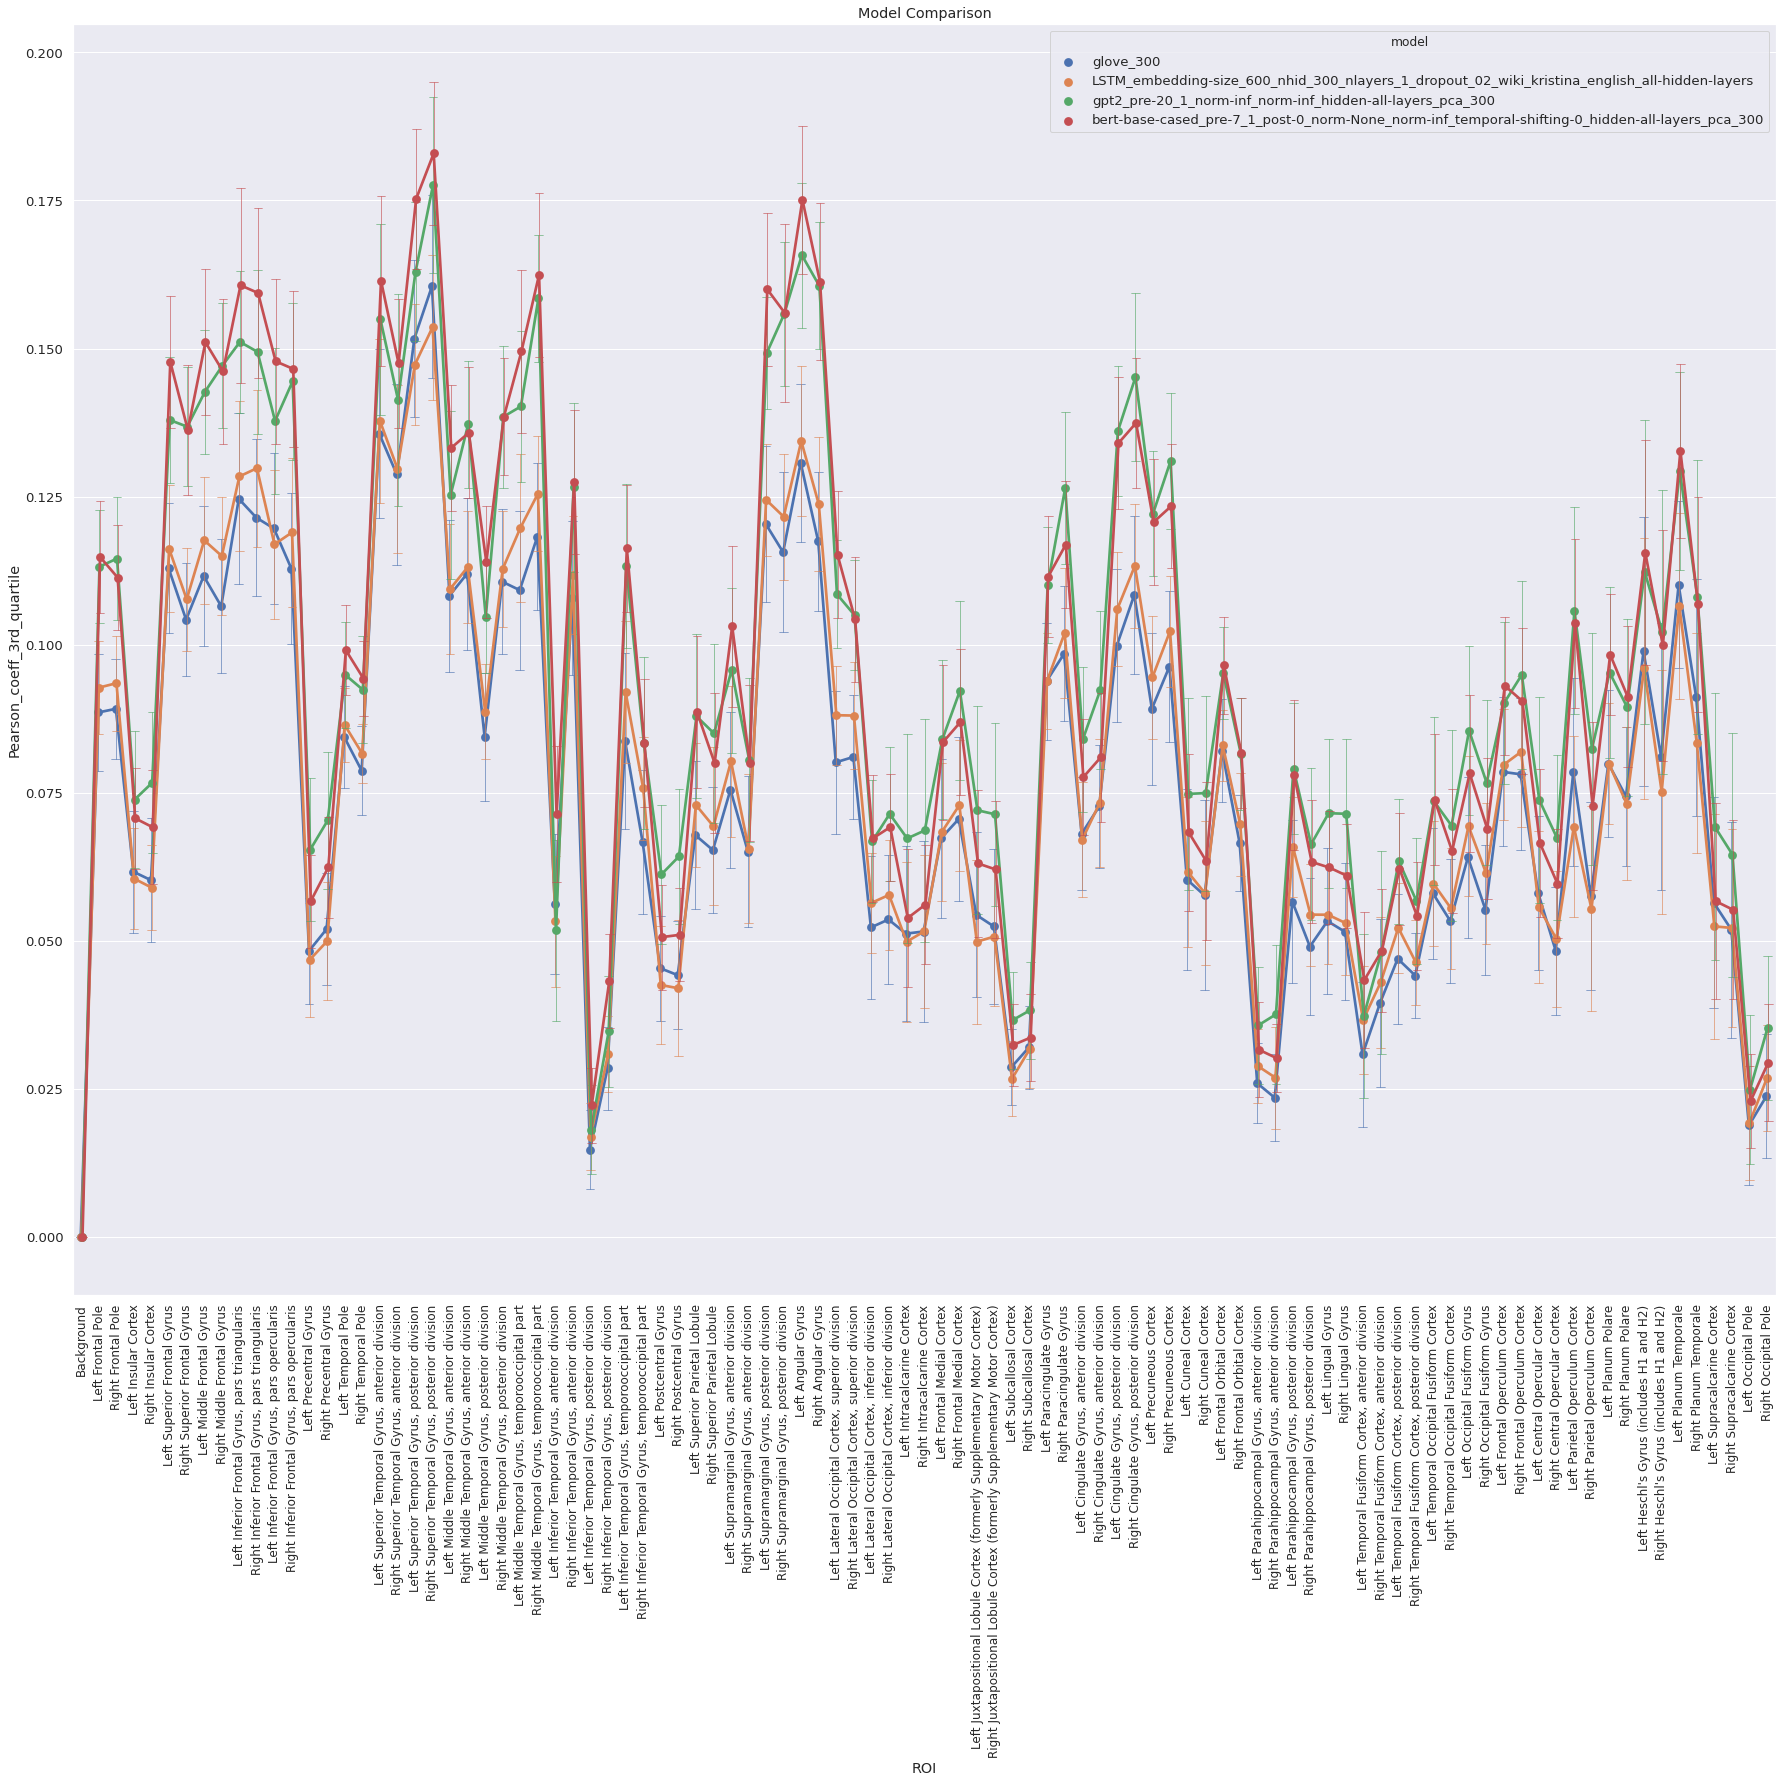

In [45]:
comparison = anova_comparison.copy()
for roi in tqdm(comparison['ROI'].unique()):
    mean_global = np.mean(comparison[comparison['ROI']==roi]['Pearson_coeff_3rd_quartile'].values)
    for subject in comparison['subject'].unique():
        tmp = mean_global - np.mean(comparison[(comparison['ROI']==roi) & (comparison['subject']==subject)]['Pearson_coeff_3rd_quartile'].values)
        comparison.loc[(comparison['ROI']==roi) & (comparison['subject']==subject),'Pearson_coeff_3rd_quartile'] += tmp

plt.figure(figsize=((25,25)))
sns.set(context='notebook', font_scale=1.2)
colors = ['r', 'g', 'blue', 'black']
#for index, model in enumerate(anova_comparison['model'].unique()):
#    sns.pointplot(data=anova_comparison[anova_comparison['model']==model], x='ROI', y='Pearson_coeff_3rd_quartile', alpha=0.7, errwidth=0.6, capsize=.1, ci='sd', color=colors[index])
sns.pointplot(data=comparison, x='ROI', y='Pearson_coeff_3rd_quartile', hue='model', dodge=True, alpha=0.7, errwidth=0.6, capsize=0.5, ci='sd')

_ = plt.title('Model Comparison')
ax = plt.axes()
ax.tick_params(axis='x', labelsize=12, rotation=90)
#plt.legend([model], ncol=1, bbox_to_anchor=(0,0,1,1), fontsize=10)
#plt.legend(anova_comparison['model'].unique(), ncol=1, bbox_to_anchor=(0,0,1,1), fontsize=10)

plt.tight_layout()
plt.show()

### Retrieving data

In [ ]:
data_full = reporting.get_model_data(model_names, language, OUTPUT_PATH)
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }

In [ ]:
data_to_plot = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                threshold_img=None,
                                language='english', 
                                object_of_interest='Pearson_coeff',
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_to_plot['mean']
third_quartile = data_to_plot['third_quartile']
maximum = data_to_plot['maximum']


In [13]:
threshold_mean, threshold_third_quartile, threshold_maximum = reporting.fit_per_roi(
    [threshold_img], 
    atlas_maps, 
    labels, 
    global_mask=None, 
    threshold_img=None)

  1%|          | 1/97 [00:00<00:12,  7.96it/s]

	Looping through labeled masks...


100%|██████████| 97/97 [00:08<00:00, 11.92it/s]

		-->Done


### Pearson coefficients values

In [ ]:
reporting.clever_plot(
    third_quartile, 
    labels, 
    legend_names, 
    save_folder=None, 
    roi_filter=load_interesting_rois(),
    analysis_name='Pearson_third-quartile_interesting-roi', 
    title='Model comparison - Pearson third quartile - Interesting ROIs',
    ylabel='Pearson coefficients',
    xlabel='Models',
    plot_name='Model_comparison',
    figsize=(15,12),
    percentage=False
)

In [ ]:
reporting.vertical_plot(
                third_quartile, 
                labels, 
                'Third_Quartile_Pearson-coeff_per_ROI',
                save_folder=None, 
                object_of_interest='Pearson_coeff', 
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,18), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='Pearson_coeff value', 
                model_name='Model_comparison'
                )

In [ ]:
reporting.vertical_plot(
                np.hstack([third_quartile, threshold_third_quartile]),
                labels, 
                'Third_Quartile_Pearson-coeff_per_ROI',
                save_folder=None, 
                object_of_interest='Pearson_coeff', 
                legend_names=legend_names+ ['FastSRM'], 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,18), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='Pearson_coeff value', 
                model_name='Model_comparison'
                )

### % of the Pearson coefficient achieved (compared to FastSRM results)

Some voxels with FastSRM had 0_Pearson coefficient.
To avoid computational issue, we changed all 0 values to 10⁸, which is similar to put model's pearson cofficient for those voxels to 0.

In [28]:
data_to_plot_thresholded = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                threshold_img=threshold_img,
                                language='english', 
                                object_of_interest='Pearson_coeff',
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean_thresholded = data_to_plot_thresholded['mean']
third_quartile_thresholded = data_to_plot_thresholded['third_quartile']
maximum_thresholded = data_to_plot_thresholded['maximum']

  0%|          | 0/97 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 97/97 [00:28<00:00,  3.46it/s]

		-->Done


In [ ]:
reporting.clever_plot(
    third_quartile_thresholded, 
    labels, 
    legend_names, 
    save_folder=None, 
    roi_filter=load_interesting_rois(),
    analysis_name='Pearson_third-quartile_interesting-roi', 
    title='Model comparison - Pearson third quartile - Interesting ROIs',
    ylabel='% of the Pearson coefficient achieved',
    xlabel='Models',
    plot_name='Model_comparison',
    figsize=(15,12),
    percentage=True
)

In [ ]:
reporting.vertical_plot(
                third_quartile_thresholded, 
                labels, 
                '% of the Pearson coefficient achieved',
                save_folder=None, 
                object_of_interest='Pearson_coeff', 
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,18), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='% of the Pearson coefficient achieved', 
                model_name='Model_comparison',
                percentage=True
                )

### Idem but with filtering of voxels based on given threshold

In [29]:
data_to_plot_thresholded_filtered = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                threshold_img=threshold_img,
                                voxels_filter=voxels_filter,
                                language='english', 
                                object_of_interest='Pearson_coeff',
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean_thresholded_filtered = data_to_plot_thresholded_filtered['mean']
third_quartile_thresholded_filtered = data_to_plot_thresholded_filtered['third_quartile']
maximum_thresholded_filtered = data_to_plot_thresholded_filtered['maximum']




  0%|          | 0/97 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 97/97 [00:29<00:00,  3.30it/s]

		-->Done


In [17]:
threshold_mean, threshold_third_quartile, threshold_maximum, threshold_size = reporting.fit_per_roi(
    [threshold_img], 
    atlas_maps, 
    labels, 
    global_mask=None, 
    threshold_img=None)

  1%|          | 1/97 [00:00<00:13,  7.05it/s]

	Looping through labeled masks...


100%|██████████| 97/97 [00:14<00:00,  6.50it/s]

		-->Done


In [ ]:

reporting.clever_plot(
    third_quartile_thresholded_filtered, 
    labels, 
    legend_names, 
    save_folder=None, 
    roi_filter=load_interesting_rois(),
    analysis_name='Pearson_third-quartile_language-roi', 
    title='Model comparison - Pearson third quartile - Language ROIs',
    ylabel='% of the Pearson coefficient achieved',
    xlabel='Models',
    plot_name='Model_comparison',
    figsize=(15,12),
    percentage=True
)

In [40]:
model_names_list = [
    [

    #'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300_wordrate-rms-log_freq',

    'distilbert-base-cased_pre-0_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilbert-base-cased_pre-1_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilbert-base-cased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilbert-base-cased_pre-5_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilbert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilbert-base-cased_pre-10_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilbert-base-cased_pre-15_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilbert-base-cased_pre-20_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    ],
    [
    'distilgpt2_pre-0_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilgpt2_pre-1_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilgpt2_pre-2_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilgpt2_pre-5_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilgpt2_pre-7_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilgpt2_pre-10_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilgpt2_pre-15_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilgpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    
    ],
    [
    'distilroberta_pre-0_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilroberta_pre-1_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilroberta_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilroberta_pre-5_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilroberta_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilroberta_pre-10_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilroberta_pre-15_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'distilroberta_pre-20_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    ],
    [
    'bert-base-uncased_pre-0_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'bert-base-uncased_pre-1_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'bert-base-uncased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'bert-base-uncased_pre-5_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'bert-base-uncased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'bert-base-uncased_pre-10_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'bert-base-uncased_pre-15_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'bert-base-uncased_pre-20_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    ],
    [
    'bert-base-cased_pre-0_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    ],
    [
    'albert-base-v2_pre-0_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'albert-base-v2_pre-1_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'albert-base-v2_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'albert-base-v2_pre-5_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'albert-base-v2_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'albert-base-v2_pre-10_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'albert-base-v2_pre-15_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'albert-base-v2_pre-19_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    ],
    [
    'roberta-base_pre-0_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-1_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-5_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-10_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-15_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'roberta-base_pre-20_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    ],
    [
    'gpt2_pre-0_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-1_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-2_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-5_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-10_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-15_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    ],
    
]

title_names = [
    'distilbert-base-cased', 
    'distilgpt2',
    'distilroberta',
    'bert-base-uncased',
    'bert-base-cased',
    'albert-base-v2',
    'roberta-base',
    'gpt2'
]


legend_names_list = [[
    'distilbert-base-cased_pre-0',
    'distilbert-base-cased_pre-1',
    'distilbert-base-cased_pre-2',
    'distilbert-base-cased_pre-5',
    'distilbert-base-cased_pre-7',
    'distilbert-base-cased_pre-10',
    'distilbert-base-cased_pre-15',
    'distilbert-base-cased_pre-20',
               ],
    [
    'distilgpt2_pre-0',
    'distilgpt2_pre-1',
    'distilgpt2_pre-2',
    'distilgpt2_pre-5',
    'distilgpt2_pre-7',
    'distilgpt2_pre-10',
    'distilgpt2_pre-15',
    'distilgpt2_pre-20',
               ],
    [
    'distilroberta_pre-0',
    'distilroberta_pre-1',
    'distilroberta_pre-2',
    'distilroberta_pre-5',
    'distilroberta_pre-7',
    'distilroberta_pre-10',
    'distilroberta_pre-15',
    'distilroberta_pre-20',
               ],
    [
    'bert-base-uncased_pre-0',
    'bert-base-uncased_pre-1',
    'bert-base-uncased_pre-2',
    'bert-base-uncased_pre-5',
    'bert-base-uncased_pre-7',
    'bert-base-uncased_pre-10',
    'bert-base-uncased_pre-15',
    'bert-base-uncased_pre-20',
               ],
    [
    'bert-base-cased_pre-0',
    'bert-base-cased_pre-1',
    'bert-base-cased_pre-2',
    'bert-base-cased_pre-5',
    'bert-base-cased_pre-7',
    'bert-base-cased_pre-10',
    'bert-base-cased_pre-15',
    'bert-base-cased_pre-20',
               ],
    [
    'albert-v2_pre-0',
    'albert-v2_pre-1',
    'albert-v2_pre-2',
    'albert-v2_pre-5',
    'albert-v2_pre-7',
    'albert-v2_pre-10',
    'albert-v2_pre-15',
    'albert-v2_pre-20',
               ],
    [
    'roberta-base_pre-0',
    'roberta-base_pre-1',
    'roberta-base_pre-2',
    'roberta-base_pre-5',
    'roberta-base_pre-7',
    'roberta-base_pre-10',
    'roberta-base_pre-15',
    'roberta-base_pre-20',
               ],
    [
    'gpt2_pre-0',
    'gpt2_pre-1',
    'gpt2_pre-2',
    'gpt2_pre-5',
    'gpt2_pre-10',
    'gpt2_pre-15',
    'gpt2_pre-20',
               ],
    
]


In [ ]:

third_quartile_R2 = []
third_quartile_Pearson = []
    
for model_names, legend_names in zip(model_names_list, legend_names_list):





    data_full = reporting.get_model_data(model_names, language, OUTPUT_PATH)
    data_model_test = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }

    data_to_plot_R2 = reporting.get_data_per_roi(
                                    data_model_test, 
                                    atlas_maps,
                                    labels,
                                    analysis=None, 
                                    threshold_img=None,
                                    voxels_filter=None,
                                    language='english', 
                                    object_of_interest='R2',
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )
    data_to_plot_Pearson = reporting.get_data_per_roi(
                                    data_model_test, 
                                    atlas_maps,
                                    labels,
                                    analysis=None, 
                                    threshold_img=None,
                                    voxels_filter=None,
                                    language='english', 
                                    object_of_interest='Pearson_coeff',
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )

    third_quartile_R2.append(data_to_plot_R2['third_quartile'])
    third_quartile_Pearson.append(data_to_plot_Pearson['third_quartile'])

    #reporting.vertical_plot(
    #                third_quartile_bert, 
    #                labels, 
    #                'Pearson coefficient',
    #                save_folder=None, 
    #                object_of_interest='Pearson_coeff', 
    #                legend_names=legend_names, 
    #                syntactic_roi=load_syntactic_roi(), 
    #                language_roi=load_language_roi(), 
    #                figsize=(9,18), 
    #                count=False, 
    #                title=None, 
    #                ylabel='Regions of interest (ROI)', 
    #                xlabel='Pearson coefficient', 
    #                model_name='Test',
    #                percentage=True
    #                )



In [ ]:
for index, (model_names, legend_names) in enumerate(zip(model_names_list, legend_names_list)):
    reporting.vertical_plot(
                third_quartile_Pearson[index], 
                labels, 
                'Pearson coefficient',
                save_folder=None, 
                object_of_interest='Pearson_coeff', 
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,18), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='Pearson coefficient', 
                model_name='Test',
                percentage=True
                )

In [ ]:
for index, (model_names, legend_names) in enumerate(zip(model_names_list, legend_names_list)):

    reporting.clever_plot(
        third_quartile_Pearson[index], 
        labels, 
        legend_names, 
        save_folder=None, 
        roi_filter=load_interesting_rois(),
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='BERT'
    )

In [34]:
saving_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/anovas/'
utils.check_folder(saving_folder)

for index, (model_names, legend_names) in enumerate(zip(model_names_list, legend_names_list)):

    anova_comparison = reporting.prepare_data_for_anova(
        model_names, 
        atlas_maps, 
        labels, 
        MASKER_PATH,
        object_of_interest='Pearson_coeff', 
        language='english',
        OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english'
        )
    
    anova_comparison.to_csv(os.path.join(saving_folder, 'anova_{}.csv'.format(title_names[index])))

  0%|          | 0/97 [00:00<?, ?it/s]

	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

	Looping through labeled masks...


 18%|█▊        | 17/97 [01:20<06:17,  4.72s/it]


KeyboardInterrupt: 

Here we remove previous sentence so that there are no sentence-size effect.

In [17]:

model_names_lstm = [

'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-1_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-2_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-3_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-4_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-5_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-7_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-10_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-12_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-15_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-17_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-20_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-25_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-30_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-35_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-40_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-50_wiki-kristina_english_{}_all-hidden-layers',
'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-inf_wiki-kristina_english_{}_all-hidden-layers',
]

legend_names_lstm = [

    'LSTM_E-600_H-300_L-1_d-02_Mem-1',
    'LSTM_E-600_H-300_L-1_d-02_Mem-2',
    'LSTM_E-600_H-300_L-1_d-02_Mem-3',
    'LSTM_E-600_H-300_L-1_d-02_Mem-4',
    'LSTM_E-600_H-300_L-1_d-02_Mem-5',
    'LSTM_E-600_H-300_L-1_d-02_Mem-7',
    'LSTM_E-600_H-300_L-1_d-02_Mem-10',
    'LSTM_E-600_H-300_L-1_d-02_Mem-12',
    'LSTM_E-600_H-300_L-1_d-02_Mem-15',
    'LSTM_E-600_H-300_L-1_d-02_Mem-17',
    'LSTM_E-600_H-300_L-1_d-02_Mem-20',
    'LSTM_E-600_H-300_L-1_d-02_Mem-25',
    'LSTM_E-600_H-300_L-1_d-02_Mem-30',
    'LSTM_E-600_H-300_L-1_d-02_Mem-35',
    'LSTM_E-600_H-300_L-1_d-02_Mem-40',
    'LSTM_E-600_H-300_L-1_d-02_Mem-50',
    'LSTM_E-600_H-300_L-1_d-02_Mem-inf',
]

data_full_lstm = reporting.get_model_data(model_names_lstm, language, OUTPUT_PATH)

maps_lstm = [data_full_lstm[name]['Pearson_coeff'] for name in data_full_lstm.keys()]

mean_maps_lstm = Parallel(n_jobs=-2)(delayed(mean_img)(imgs) for imgs in maps_lstm)

 12%|█▏        | 6/51 [00:00<00:00, 55.86it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 31%|███▏      | 16/51 [00:00<00:00, 46.77it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 55%|█████▍    | 28/51 [00:00<00:00, 48.02it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 75%|███████▍  | 38/51 [00:00<00:00, 47.85it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


 10%|▉         | 5/51 [00:00<00:00, 48.68it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 37%|███▋      | 19/51 [00:00<00:00, 55.60it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 59%|█████▉    | 30/51 [00:00<00:00, 52.97it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 84%|████████▍ | 43/51 [00:00<00:00, 54.01it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:00, 65.80it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 

 39%|███▉      | 20/51 [00:00<00:00, 61.46it/s]

1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 59%|█████▉    | 30/51 [00:00<00:00, 66.02it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 

 24%|██▎       | 12/51 [00:00<00:00, 114.21it/s]

- 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 73%|███████▎  | 37/51 [00:00<00:00, 113.88it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:00, 79.01it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 57%|█████▋    | 29/51 [00:00<00:00, 86.51it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 35%|███▌      | 18/51 [00:00<00:00, 79.15it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 65%|██████▍   | 33/51 [00:00<00:00, 68.33it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:00, 51.38it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 53%|█████▎    | 27/51 [00:00<00:00, 59.93it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 82%|████████▏ | 42/51 [00:00<00:00, 58.34it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 94%|█████████▍| 48/51 [00:00<00:00, 45.10it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:01, 41.20it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:01, 32.23it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 47%|████▋     | 24/51 [00:00<00:00, 36.33it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 63%|██████▎   | 32/51 [00:00<00:00, 42.56it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:01, 29.79it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 49%|████▉     | 25/51 [00:00<00:00, 43.48it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 65%|██████▍   | 33/51 [00:00<00:00, 49.76it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:00, 54.64it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 

 33%|███▎      | 17/51 [00:00<00:00, 59.83it/s]

1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 76%|███████▋  | 39/51 [00:00<00:00, 76.28it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 10%|▉         | 5/51 [00:00<00:01, 42.61it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:01, 38.35it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 

 31%|███▏      | 16/51 [00:00<00:01, 33.71it/s]

1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 51%|█████     | 26/51 [00:00<00:00, 34.12it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 67%|██████▋   | 34/51 [00:00<00:00, 34.94it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 92%|█████████▏| 47/51 [00:01<00:00, 40.76it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:00, 127.31it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 49%|████▉     | 25/51 [00:00<00:00, 75.30it/s] 

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 71%|███████   | 36/51 [00:00<00:00, 53.42it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 80%|████████  | 41/51 [00:00<00:00, 48.51it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:00, 78.72it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 47%|████▋     | 24/51 [00:00<00:00, 71.36it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 57%|█████▋    | 29/51 [00:00<00:00, 56.02it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 78%|███████▊  | 40/51 [00:00<00:00, 47.92it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:00, 124.74it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 67%|██████▋   | 34/51 [00:00<00:00, 112.98it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:00, 66.50it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 

 45%|████▌     | 23/51 [00:00<00:00, 79.13it/s]

- 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:00, 64.28it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 51%|█████     | 26/51 [00:00<00:00, 60.66it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:00, 79.36it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 43%|████▎     | 22/51 [00:00<00:00, 56.04it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 69%|██████▊   | 35/51 [00:00<00:00, 53.97it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


100%|██████████| 51/51 [00:00<00:00, 56.31it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


In [ ]:

model_names_sent_bert = [

'bert-base-uncased_pre-0_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-1_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-3_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-5_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-6_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-8_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-9_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-10_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-11_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-12_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-13_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-14_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-15_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-16_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-17_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-18_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-19_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
]

legend_names_sent_bert = [

'bert-uncased_pre-0',
'bert-uncased_pre-1',
'bert-uncased_pre-2',
'bert-uncased_pre-3',
'bert-uncased_pre-4',
'bert-uncased_pre-5',
'bert-uncased_pre-6',
'bert-uncased_pre-7',
'bert-uncased_pre-8',
'bert-uncased_pre-9',
'bert-uncased_pre-10',
'bert-uncased_pre-11',
'bert-uncased_pre-12',
'bert-uncased_pre-13',
'bert-uncased_pre-14',
'bert-uncased_pre-15',
'bert-uncased_pre-16',
'bert-uncased_pre-17',
'bert-uncased_pre-18',
'bert-uncased_pre-19',
'bert-uncased_pre-20',
]

data_full_sent_bert = reporting.get_model_data(model_names_sent_bert, language, OUTPUT_PATH)

maps_sent_bert = [data_full_sent_bert[name]['Pearson_coeff'] for name in data_full_sent_bert.keys()]

mean_maps_sent_bert = Parallel(n_jobs=-2)(delayed(mean_img)(imgs) for imgs in maps_sent_bert)

In [ ]:

model_names_sent_gpt2 = [

'gpt2_pre-0_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-1_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-1_1_with-special-tokens_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-2_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-3_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-4_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-5_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-5_1_with-special-tokens_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-6_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-7_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-8_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-9_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-10_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-10_1_with-special-tokens_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-11_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-12_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-13_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-14_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-15_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-16_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-17_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-18_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-19_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'gpt2_pre-20_1_with-special-tokens_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    
]

legend_names_sent_gpt2 = [

'gpt2_pre-0',
'gpt2_pre-1',
'gpt2_pre-1-SP',
'gpt2_pre-2',
'gpt2_pre-3',
'gpt2_pre-4',
'gpt2_pre-5',
'gpt2_pre-5-SP',
'gpt2_pre-6',
'gpt2_pre-7',
'gpt2_pre-8',
'gpt2_pre-9',
'gpt2_pre-10',
'gpt2_pre-10-SP',
'gpt2_pre-11',
'gpt2_pre-12',
'gpt2_pre-13',
'gpt2_pre-14',
'gpt2_pre-15',
'gpt2_pre-16',
'gpt2_pre-17',
'gpt2_pre-18',
'gpt2_pre-19',
'gpt2_pre-20',
'gpt2_pre-20-SP',
]

data_full_sent_gpt2 = reporting.get_model_data(model_names_sent_gpt2, language, OUTPUT_PATH)

maps_sent_gpt2 = [data_full_sent_gpt2[name]['Pearson_coeff'] for name in data_full_sent_gpt2.keys()]

mean_maps_sent_gpt2 = Parallel(n_jobs=-2)(delayed(mean_img)(imgs) for imgs in maps_sent_gpt2)

In [13]:
model_names_bert = [
'bert-base-uncased_pre-20_token-0-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-1-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-2-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-3-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-4-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-5-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-7-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-10-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-12-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-15-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-17-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-20-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-25-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-30-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-35-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-40-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-50-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-60-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-70-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-80-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-90-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-100-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-125-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-150-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-175-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-200-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-225-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-250-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-275-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-300-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-325-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-350-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-20_token-375-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',    
'bert-base-uncased_pre-20_token-400-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',

    
]

legend_names_bert = [
'bert-uncased_pre-20_token-0',
'bert-uncased_pre-20_token-1',
'bert-uncased_pre-20_token-2',
'bert-uncased_pre-20_token-3',
'bert-uncased_pre-20_token-4',
'bert-uncased_pre-20_token-5',
'bert-uncased_pre-20_token-7',
'bert-uncased_pre-20_token-10',
'bert-uncased_pre-20_token-12',
'bert-uncased_pre-20_token-15',
'bert-uncased_pre-20_token-17',
'bert-uncased_pre-20_token-20',
'bert-uncased_pre-20_token-25',
'bert-uncased_pre-20_token-30',
'bert-uncased_pre-20_token-35',
'bert-uncased_pre-20_token-40',
'bert-uncased_pre-20_token-50',
'bert-uncased_pre-20_token-60',
'bert-uncased_pre-20_token-70',
'bert-uncased_pre-20_token-80',
'bert-uncased_pre-20_token-90',
'bert-uncased_pre-20_token-100',
'bert-uncased_pre-20_token-125',
'bert-uncased_pre-20_token-150',
'bert-uncased_pre-20_token-175',
'bert-uncased_pre-20_token-200',
'bert-uncased_pre-20_token-225',
'bert-uncased_pre-20_token-250',
'bert-uncased_pre-20_token-275',
'bert-uncased_pre-20_token-300',
'bert-uncased_pre-20_token-325',
'bert-uncased_pre-20_token-350',
'bert-uncased_pre-20_token-375',
'bert-uncased_pre-20_token-400',
]



data_full_bert = reporting.get_model_data(model_names_bert, language, OUTPUT_PATH)

maps_bert = [data_full_bert[name]['Pearson_coeff'] for name in data_full_bert.keys()]
mean_maps_bert = Parallel(n_jobs=-2)(delayed(mean_img)(imgs) for imgs in maps_bert)

 37%|███▋      | 19/51 [00:00<00:00, 73.96it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 78%|███████▊  | 40/51 [00:00<00:00, 78.97it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 43%|████▎     | 22/51 [00:00<00:00, 72.72it/s] 

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 86%|████████▋ | 44/51 [00:00<00:00, 83.81it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 47%|████▋     | 24/51 [00:00<00:00, 236.07it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 43%|████▎     | 22/51 [00:00<00:00, 205.28it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 80%|████████  | 41/51 [00:00<00:00, 400.28it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 61%|██████    | 31/51 [00:00<00:00, 277.28it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 78%|███████▊  | 40/51 [00:00<00:00, 119.53it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:00, 82.06it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 41%|████      | 21/51 [00:00<00:00, 65.60it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 35%|███▌      | 18/51 [00:00<00:00, 120.52it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


  6%|▌         | 3/51 [00:00<00:01, 25.61it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 27%|██▋       | 14/51 [00:00<00:01, 34.93it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 

 69%|██████▊   | 35/51 [00:00<00:00, 49.70it/s]

- 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 49%|████▉     | 25/51 [00:00<00:00, 84.08it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1

 59%|█████▉    | 30/51 [00:00<00:00, 289.94it/s]

 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 -

  0%|          | 0/51 [00:00<?, ?it/s]

 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:00, 56.90it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 88%|████████▊ | 45/51 [00:00<00:00, 81.93it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:00, 51.00it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 43%|████▎     | 22/51 [00:00<00:00, 52.49it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 69%|██████▊   | 35/51 [00:00<00:00, 54.44it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:00, 40.57it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 35%|███▌      | 18/51 [00:00<00:00, 43.84it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 61%|██████    | 31/51 [00:00<00:00, 47.52it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 27%|██▋       | 14/51 [00:00<00:00, 63.93it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 55%|█████▍    | 28/51 [00:00<00:00, 64.16it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 90%|█████████ | 46/51 [00:00<00:00, 71.47it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:00, 69.20it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:00, 44.14it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 55%|█████▍    | 28/51 [00:00<00:00, 51.41it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 88%|████████▊ | 45/51 [00:00<00:00, 60.55it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:00, 61.49it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 35%|███▌      | 18/51 [00:00<00:00, 53.92it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 73%|███████▎  | 37/51 [00:00<00:00, 65.70it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:00, 59.97it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 43%|████▎     | 22/51 [00:00<00:00, 63.00it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 65%|██████▍   | 33/51 [00:00<00:00, 54.25it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 76%|███████▋  | 39/51 [00:00<00:00, 52.32it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 10%|▉         | 5/51 [00:00<00:00, 47.79it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:00, 44.88it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 55%|█████▍    | 28/51 [00:00<00:00, 52.96it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 84%|████████▍ | 43/51 [00:00<00:00, 59.47it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:00, 46.80it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 41%|████      | 21/51 [00:00<00:00, 46.42it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 67%|██████▋   | 34/51 [00:00<00:00, 48.47it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 90%|█████████ | 46/51 [00:00<00:00, 46.44it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


  6%|▌         | 3/51 [00:00<00:01, 29.72it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:01, 33.49it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 39%|███▉      | 20/51 [00:00<00:00, 36.30it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 61%|██████    | 31/51 [00:00<00:00, 40.38it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 82%|████████▏ | 42/51 [00:00<00:00, 43.12it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:00, 51.17it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 47%|████▋     | 24/51 [00:00<00:00, 50.21it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 71%|███████   | 36/51 [00:00<00:00, 47.11it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 94%|█████████▍| 48/51 [00:00<00:00, 46.61it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  6%|▌         | 3/51 [00:00<00:01, 24.99it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 31%|███▏      | 16/51 [00:00<00:00, 35.67it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 57%|█████▋    | 29/51 [00:00<00:00, 44.01it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 82%|████████▏ | 42/51 [00:00<00:00, 51.32it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:00, 86.80it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 53%|█████▎    | 27/51 [00:00<00:00, 83.20it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:00, 65.76it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 61%|██████    | 31/51 [00:00<00:00, 76.00it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:00, 47.20it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 37%|███▋      | 19/51 [00:00<00:00, 39.61it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 57%|█████▋    | 29/51 [00:00<00:00, 46.05it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 31%|███▏      | 16/51 [00:00<00:00, 55.12it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 57%|█████▋    | 29/51 [00:00<00:00, 53.68it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 75%|███████▍  | 38/51 [00:00<00:00, 59.99it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:00, 59.73it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 63%|██████▎   | 32/51 [00:00<00:00, 68.78it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:01, 28.98it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 31%|███▏      | 16/51 [00:00<00:00, 35.14it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 57%|█████▋    | 29/51 [00:00<00:00, 42.99it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 73%|███████▎  | 37/51 [00:00<00:00, 47.50it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 

 24%|██▎       | 12/51 [00:00<00:00, 54.11it/s]

1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 45%|████▌     | 23/51 [00:00<00:00, 47.74it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 78%|███████▊  | 40/51 [00:00<00:00, 60.62it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:01, 37.05it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 37%|███▋      | 19/51 [00:00<00:00, 43.93it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 65%|██████▍   | 33/51 [00:00<00:00, 51.70it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 47%|████▋     | 24/51 [00:00<00:00, 96.91it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 65%|██████▍   | 33/51 [00:00<00:00, 89.28it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


100%|██████████| 51/51 [00:00<00:00, 79.05it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


In [16]:
model_names_gpt2 = [
    #'gpt2_pre-20_token-0_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-2_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-3_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-4_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-5_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-7_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-10_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-12_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-15_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-17_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-20_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-25_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-30_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-35_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-40_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-50_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-60_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-70_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-80_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-90_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-100_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-125_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-150_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-175_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-200_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-225_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-250_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-275_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-300_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-325_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-350_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-375_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_token-400_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',

    #'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
]

legend_names_gpt2 = [
    #'gpt2_pre-20_token-0',
    'gpt2_pre-20_token-1',
    'gpt2_pre-20_token-2',
    'gpt2_pre-20_token-3',
    'gpt2_pre-20_token-4',
    'gpt2_pre-20_token-5',
    'gpt2_pre-20_token-7',
    'gpt2_pre-20_token-10',
    'gpt2_pre-20_token-12',
    'gpt2_pre-20_token-15',
    'gpt2_pre-20_token-17',
    'gpt2_pre-20_token-20',
    'gpt2_pre-20_token-25',
    'gpt2_pre-20_token-30',
    'gpt2_pre-20_token-35',
    'gpt2_pre-20_token-40',
    'gpt2_pre-20_token-50',
    'gpt2_pre-20_token-60',
    'gpt2_pre-20_token-70',
    'gpt2_pre-20_token-80',
    'gpt2_pre-20_token-90',
    'gpt2_pre-20_token-100',
    'gpt2_pre-20_token-125',
    'gpt2_pre-20_token-150',
    'gpt2_pre-20_token-175',
    'gpt2_pre-20_token-200',
    'gpt2_pre-20_token-225',
    'gpt2_pre-20_token-250',
    'gpt2_pre-20_token-275',
    'gpt2_pre-20_token-300',
    'gpt2_pre-20_token-325',
    'gpt2_pre-20_token-350',
    'gpt2_pre-20_token-375',
    'gpt2_pre-20_token-400',

    #'gpt2_optimal',
]



data_full_gpt2 = reporting.get_model_data(model_names_gpt2, language, OUTPUT_PATH)

maps_gpt2 = [data_full_gpt2[name]['Pearson_coeff'] for name in data_full_gpt2.keys()]
mean_maps_gpt2 = Parallel(n_jobs=-2)(delayed(mean_img)(imgs) for imgs in maps_gpt2)

  0%|          | 0/51 [00:00<?, ?it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 

  0%|          | 0/51 [00:00<?, ?it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 

  0%|          | 0/51 [00:00<?, ?it/s]

 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
s

  0%|          | 0/51 [00:00<?, ?it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 

  0%|          | 0/51 [00:00<?, ?it/s]

 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
s

  0%|          | 0/51 [00:00<?, ?it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 

  0%|          | 0/51 [00:00<?, ?it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 

  0%|          | 0/51 [00:00<?, ?it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 

  0%|          | 0/51 [00:00<?, ?it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 

  0%|          | 0/51 [00:00<?, ?it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 

  0%|          | 0/51 [00:00<?, ?it/s]


sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098

 94%|█████████▍| 48/51 [00:00<00:00, 477.31it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 

  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 

  0%|          | 0/51 [00:00<?, ?it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 

  0%|          | 0/51 [00:00<?, ?it/s]

- 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-

  0%|          | 0/51 [00:00<?, ?it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 

  0%|          | 0/51 [00:00<?, ?it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 

100%|██████████| 51/51 [00:00<00:00, 512.58it/s]

- 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


In [21]:
#median_sent_bert, third_quartile_sent_bert, maximum_sent_bert, size_sent_bert = fit_per_roi(
#    mean_maps_sent_bert, 
#    atlas_maps, 
#    labels, 
#    global_mask=None, 
#    mask_img=os.path.join(ALL_MASKS_PATH, 'bert-base-uncased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
#    PROJECT_PATH=PROJECT_PATH
#)
#
#median_sent_gpt2, third_quartile_sent_gpt2, maximum_sent_gpt2, size_sent_gpt2 = fit_per_roi(
#    mean_maps_sent_gpt2, 
#    atlas_maps, 
#    labels, 
#    global_mask=None, 
#    mask_img=os.path.join(ALL_MASKS_PATH, 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
#    PROJECT_PATH=PROJECT_PATH
#)

median_bert, third_quartile_bert, maximum_bert, size_bert = fit_per_roi(
    mean_maps_bert, 
    atlas_maps, 
    labels, 
    global_mask=None, 
    mask_img=os.path.join(ALL_MASKS_PATH, 'bert-base-uncased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
    PROJECT_PATH=PROJECT_PATH
)

#median_gpt2, third_quartile_gpt2, maximum_gpt2, size_gpt2 = fit_per_roi(
#    mean_maps_gpt2, 
#    atlas_maps, 
#    labels, 
#    global_mask=None, 
#    mask_img=os.path.join(ALL_MASKS_PATH, 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
#    PROJECT_PATH=PROJECT_PATH
#)
#
#median_lstm, third_quartile_lstm, maximum_lstm, size_lstm = fit_per_roi(
#    mean_maps_lstm, 
#    atlas_maps, 
#    labels, 
#    global_mask=None, 
#    mask_img= os.path.join(ALL_MASKS_PATH, 'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-inf_wiki-kristina_english_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
#    PROJECT_PATH=PROJECT_PATH
#)
#

  0%|          | 0/97 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 97/97 [00:42<00:00,  2.26it/s]

		-->Done


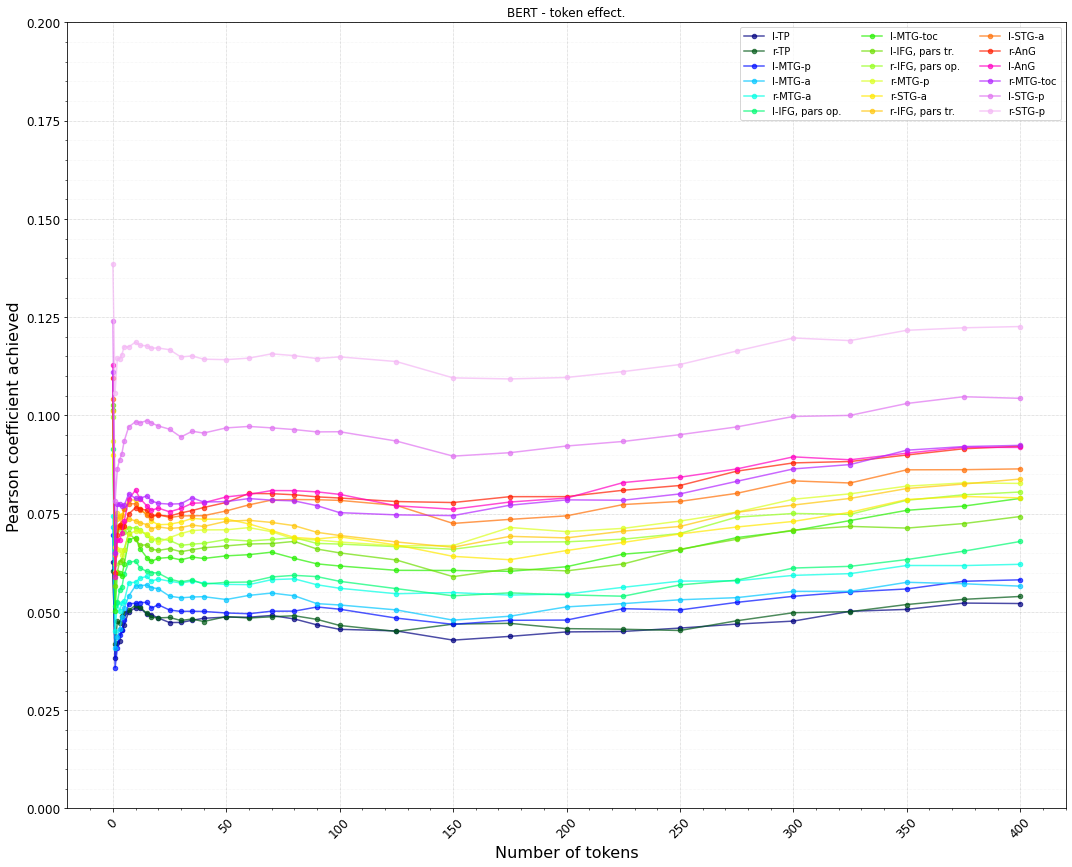

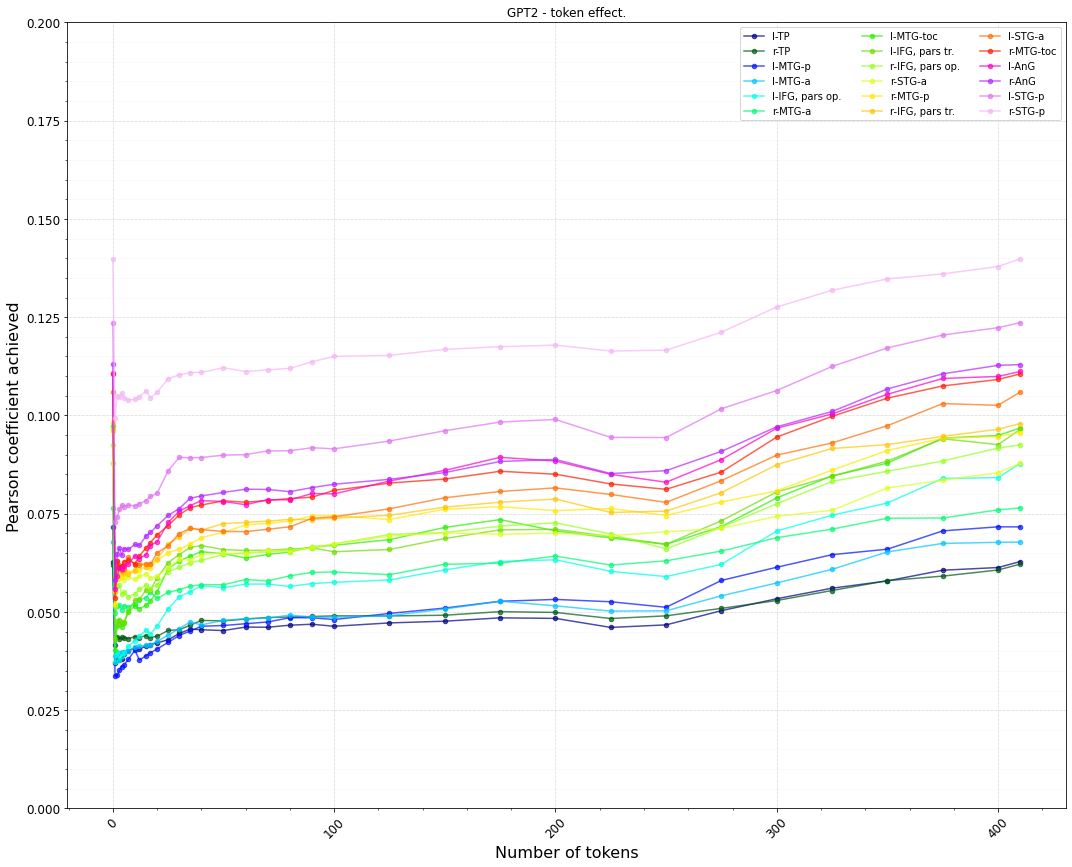

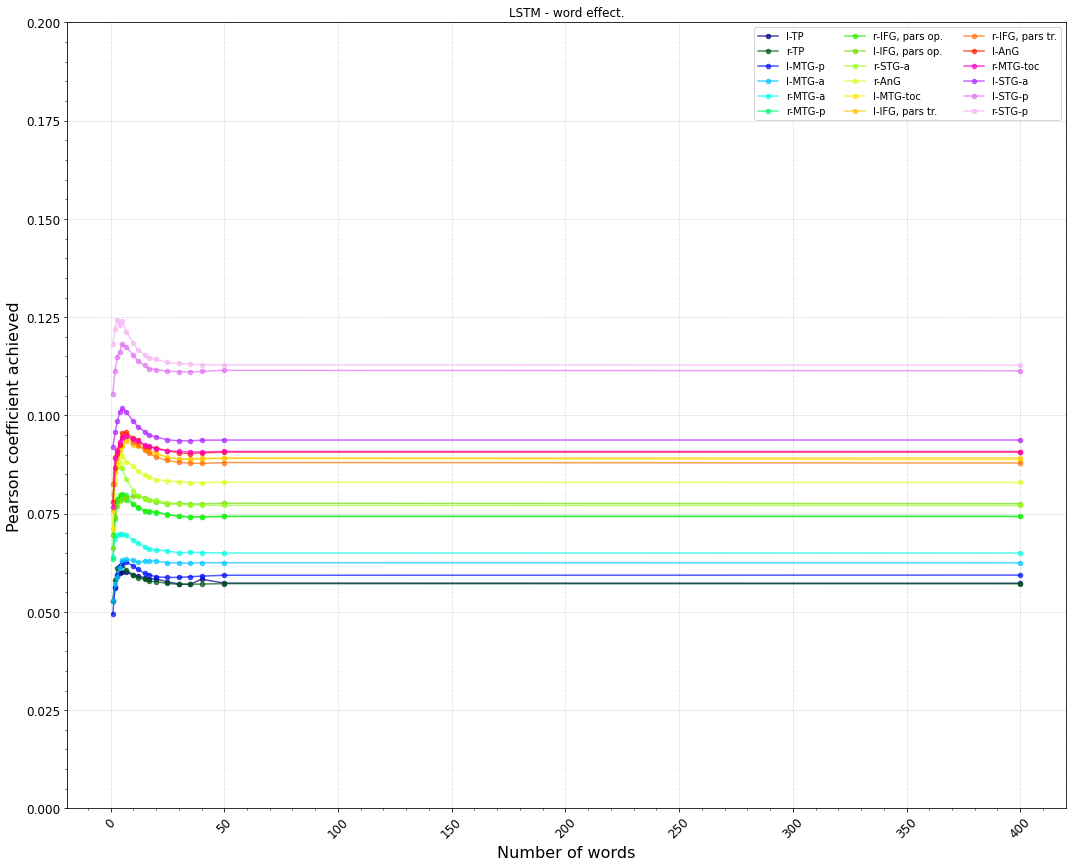

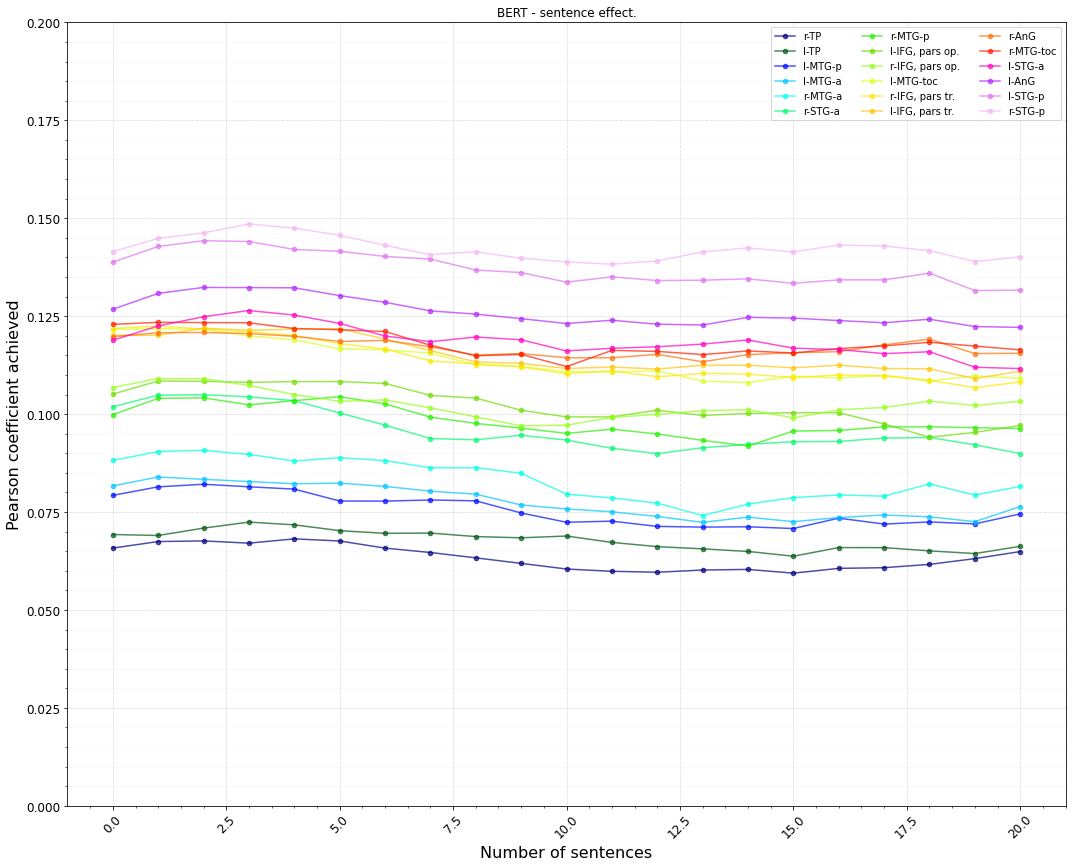

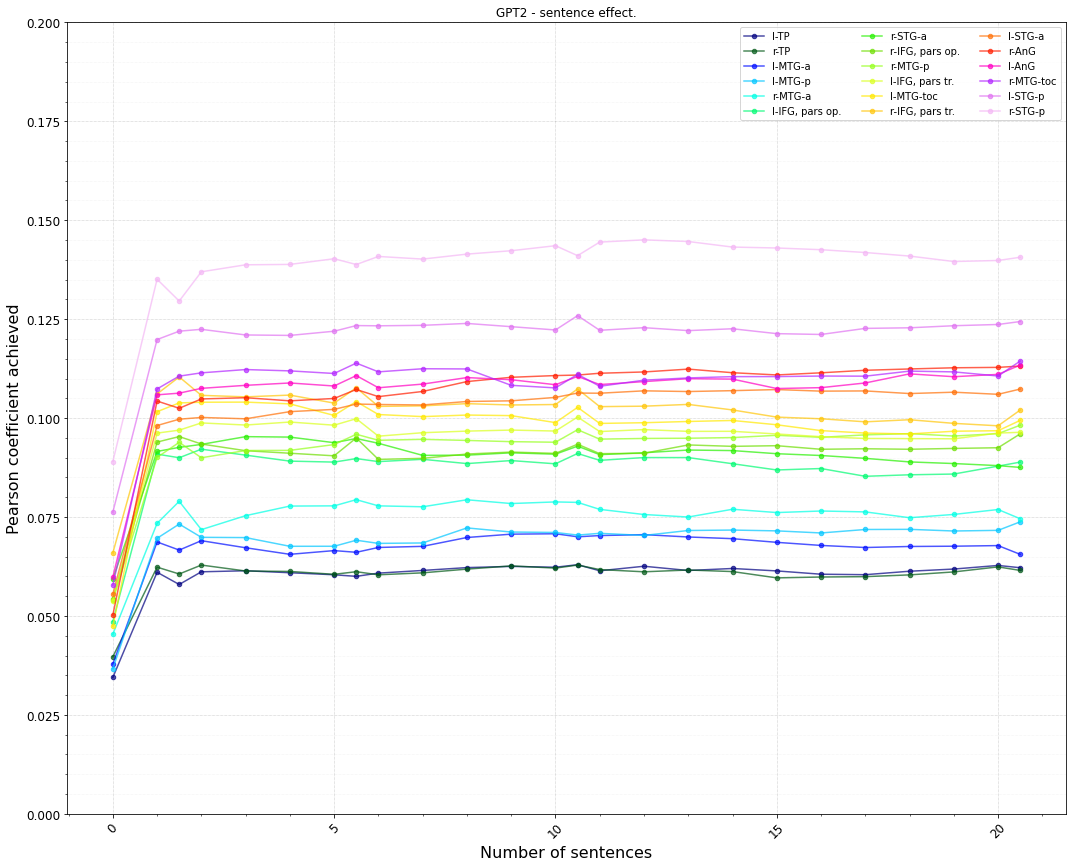

In [101]:
rois_filter = load_syntactic_roi()
#[
    #'Left Superior Frontal Gyrus',
    #'Left Inferior Frontal Gyrus, pars triangularis',
    #'Right Inferior Frontal Gyrus, pars triangularis',
    #'Left Inferior Frontal Gyrus, pars opercularis',
    #'Right Inferior Frontal Gyrus, pars opercularis',
    #'Left Temporal Pole',
    #'Left Superior Temporal Gyrus, posterior division',
    #'Left Supramarginal Gyrus, posterior division',
    #'Left Angular Gyrus',
    #'Left Paracingulate Gyrus', 
    #'Left Cingulate Gyrus, posterior division',
    #'Left Precuneous Cortex',
    #"Left Heschl's Gyrus (includes H1 and H2)",
#]

reporting.clever_plot(
        median_bert, 
        labels, 
        np.array([0, 1, 2, 3, 4, 5, 7, 10, 12, 15, 17, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400]), #legend_names
        save_folder=None, 
        roi_filter=rois_filter,
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Number of tokens',
        plot_name='Effect with 1 sentence.',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='BERT - token effect.',
        y_limit=(0, 0.2)
    )

reporting.clever_plot(
        median_gpt2, 
        labels, 
        np.array([0, 1, 2, 3, 4, 5, 7, 10, 12, 15, 17, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 410]), #legend_names_gpt2, #
        save_folder=None, 
        roi_filter=rois_filter,
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Number of tokens',
        plot_name='Effect with 2 sentences of context.',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='GPT2 - token effect.',
        y_limit=(0, 0.2)
    )

reporting.clever_plot(
        median_lstm, 
        labels, 
        np.array([1, 2, 3, 4, 5, 7, 10, 12, 15, 17, 20, 25, 30, 35, 40, 50, 400]), #legend_names
        save_folder=None, 
        roi_filter=rois_filter,
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Number of words',
        plot_name='Effect with 1 sentence.',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='LSTM - word effect.',
        y_limit=(0, 0.2)
    )

reporting.clever_plot(
        median_sent_bert, 
        labels, 
        np.arange(21), #legend_names
        save_folder=None, 
        roi_filter=rois_filter,
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Number of sentences',
        plot_name='Effect with 1 sentence.',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='BERT - sentence effect.',
        y_limit=(0, 0.2)
    )

reporting.clever_plot(
        median_sent_gpt2, 
        labels, 
        [ 0,  1, 1.5,  2,  3,  4,  5, 5.5,  6,  7,  8,  9, 10, 10.5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 20.5], #legend_names_gpt2, #
        save_folder=None, 
        roi_filter=rois_filter,
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Number of sentences',
        plot_name='Effect with 2 sentences of context.',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='GPT2 - sentence effect.',
        y_limit=(0, 0.2)
    )



In [98]:
np.arange(21)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [ ]:
###### from sklearn.linear_model import LinearRegression

def evaluate_model_patterns_per_roi(data, y=None, add_future_analysis=False, slope_analysis=False, future_start_at=None, inflection_points=None):
    """data: #ROI * #models
    """
    if add_future_analysis:
        # First evaluate the gain when we add the future
        future_analysis = np.mean(data[:, :future_start_at], axis=1) - np.mean(data[:, future_start_at:], axis=1)
    if slope_analysis:
        assert y is not None
        assert type(inflection_points)==list
        X = data[]
        reg = LinearRegression().fit(X, y)
        

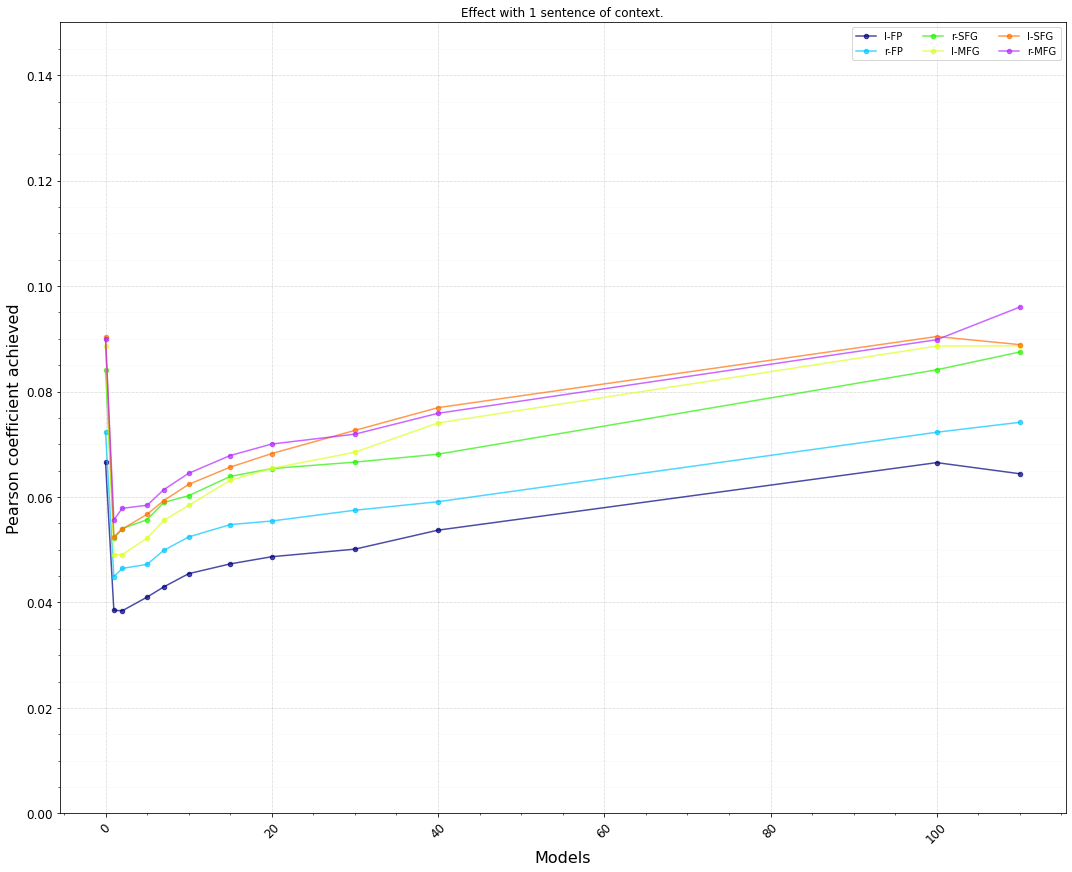

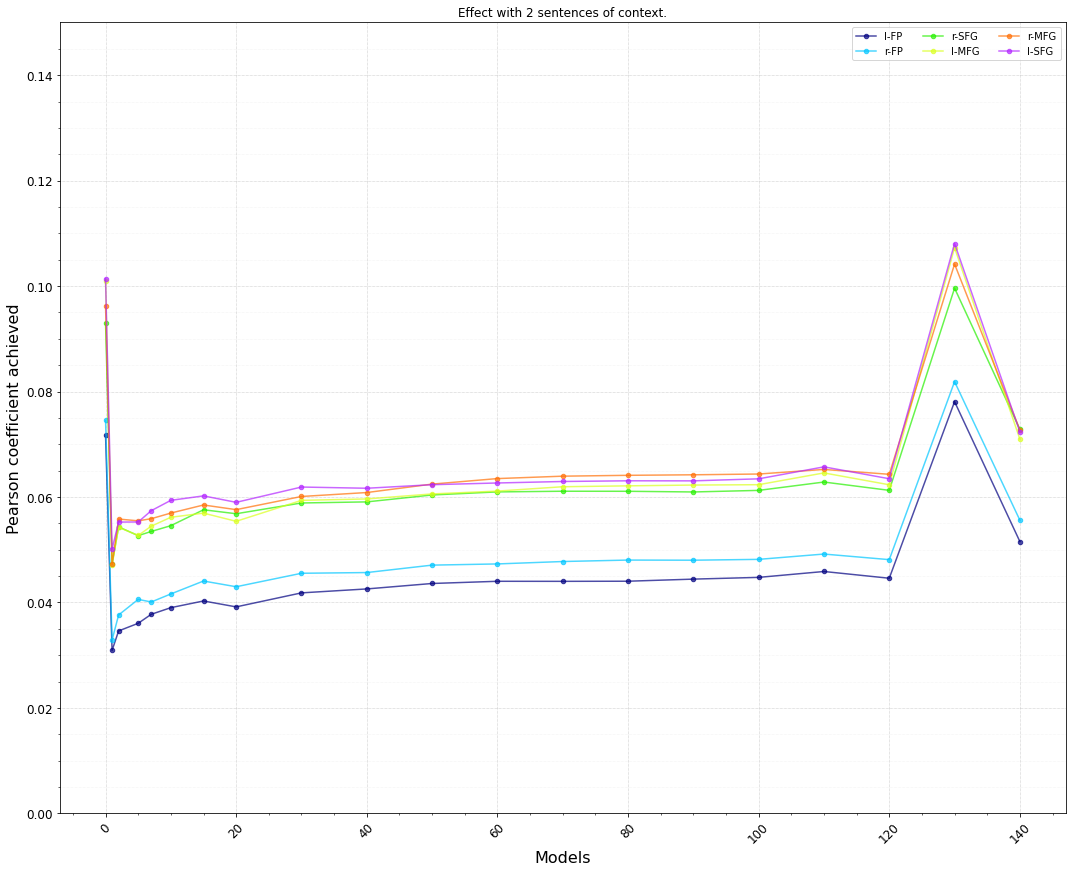

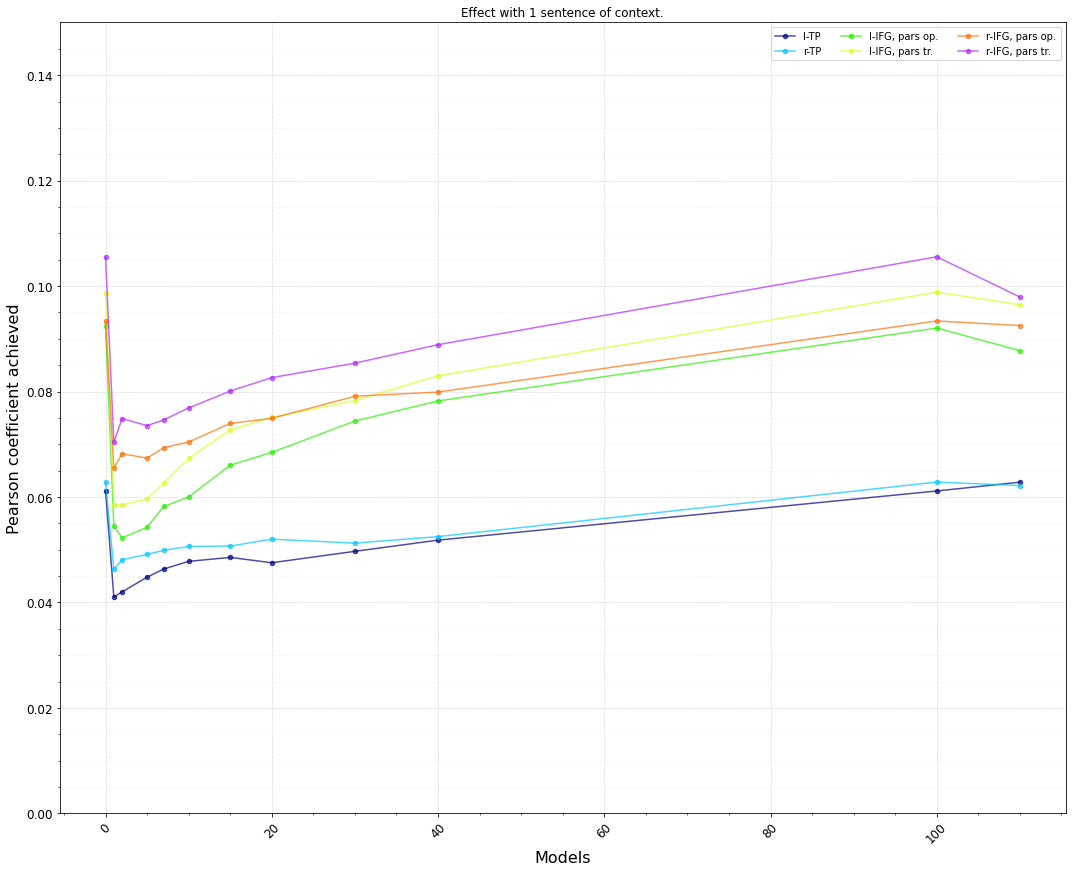

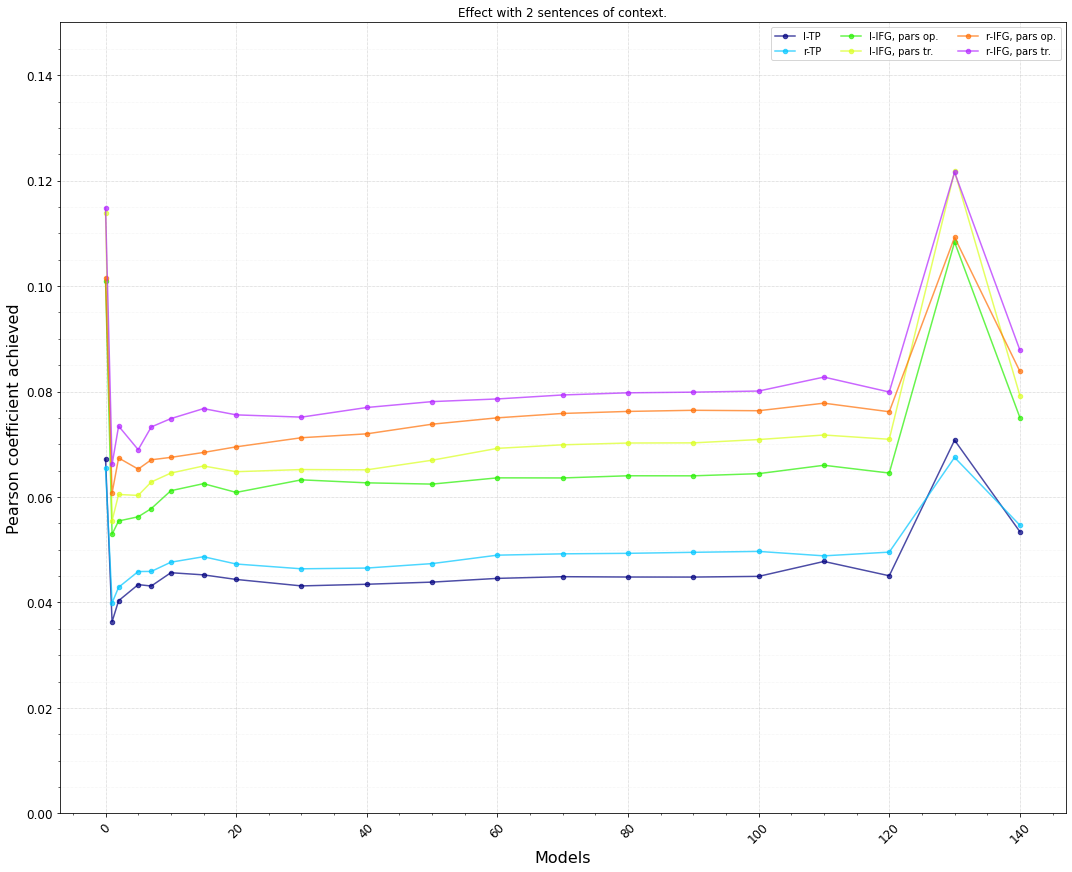

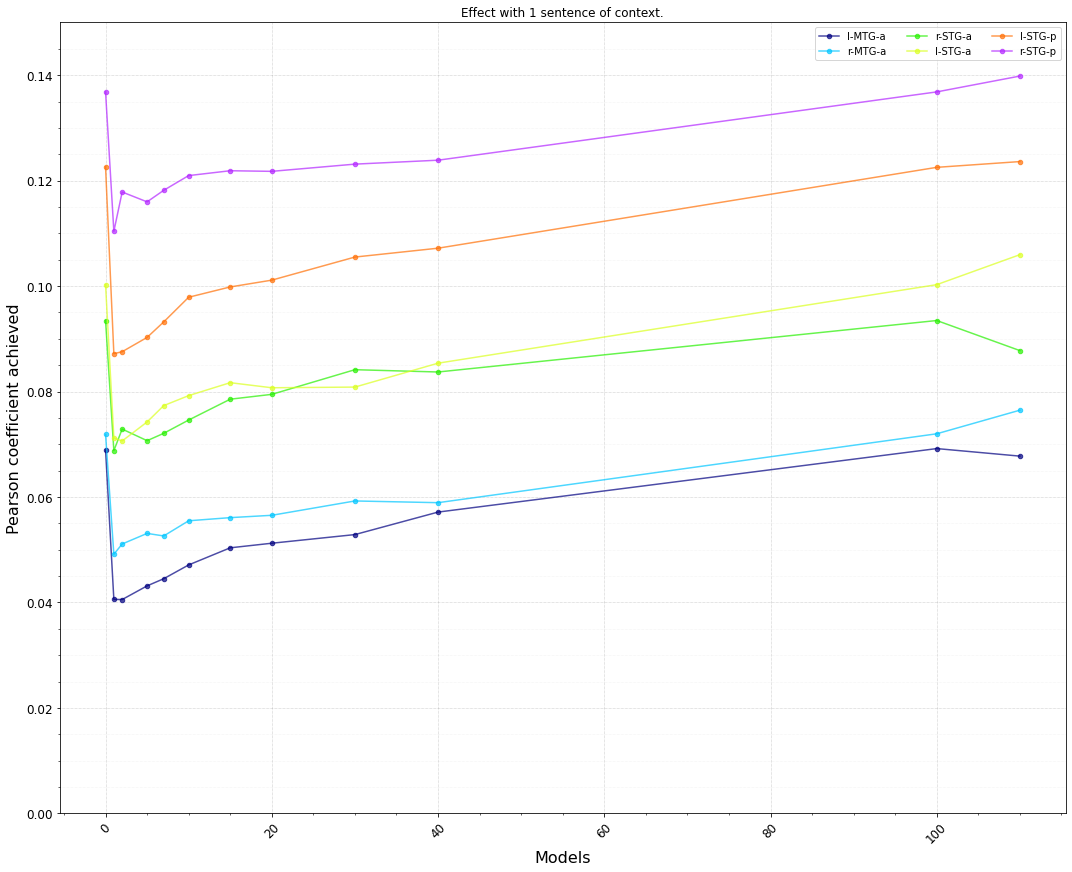

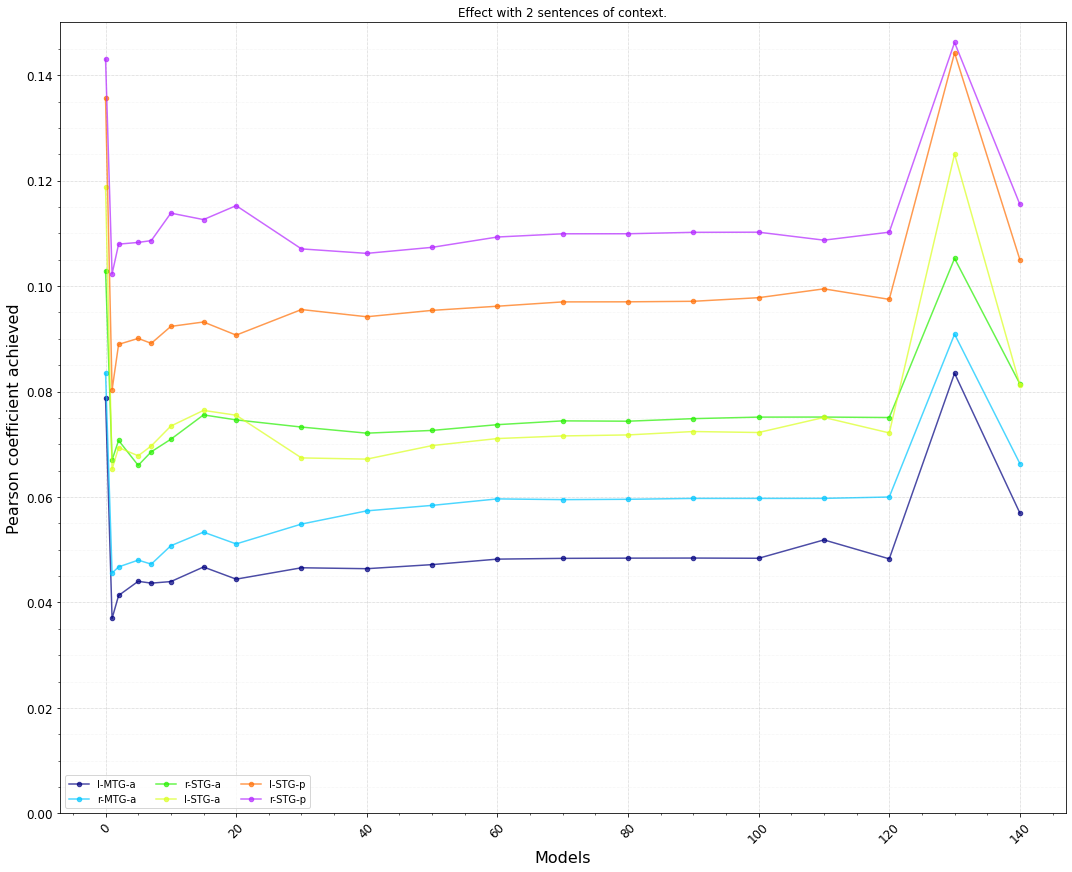

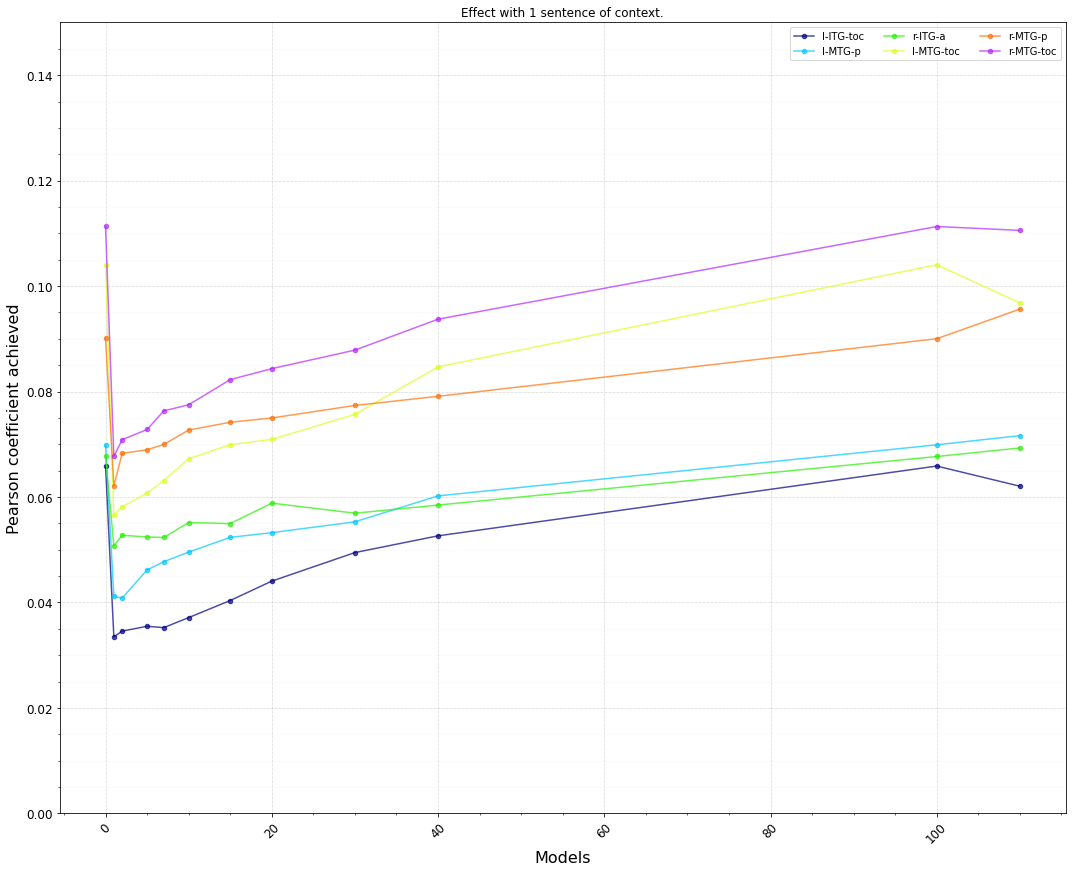

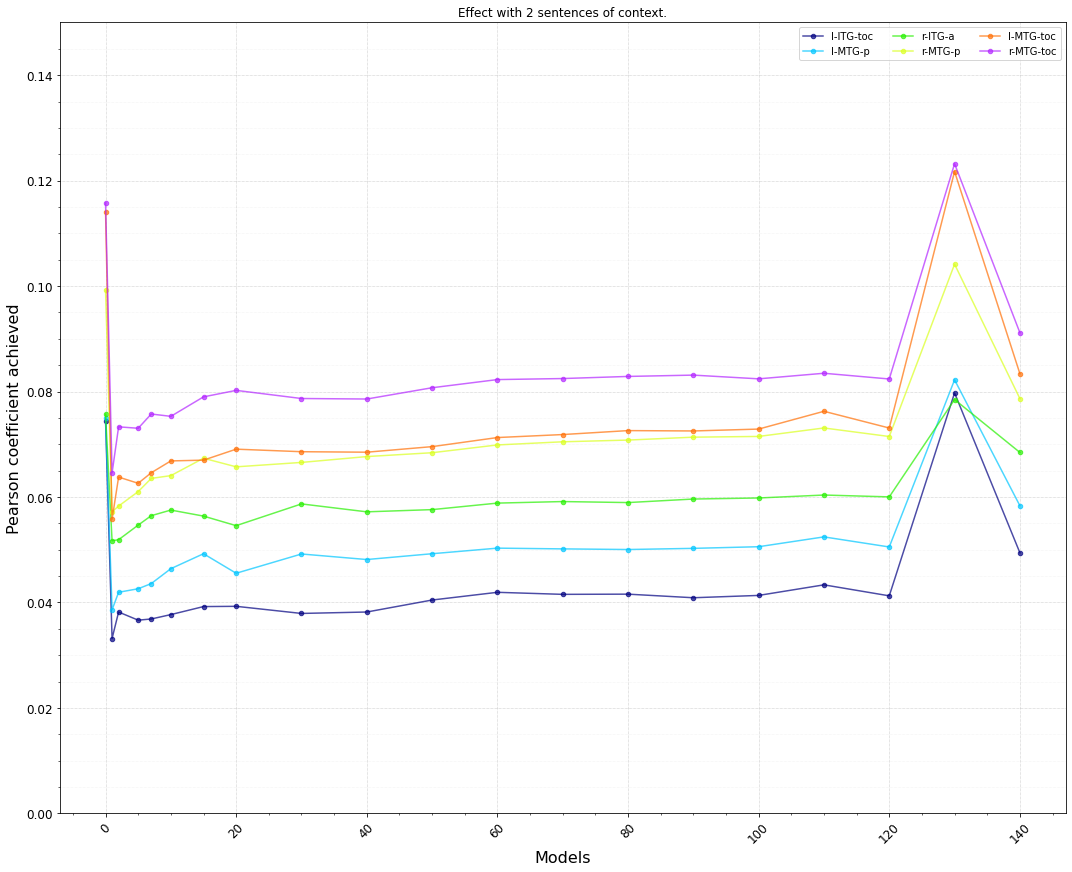

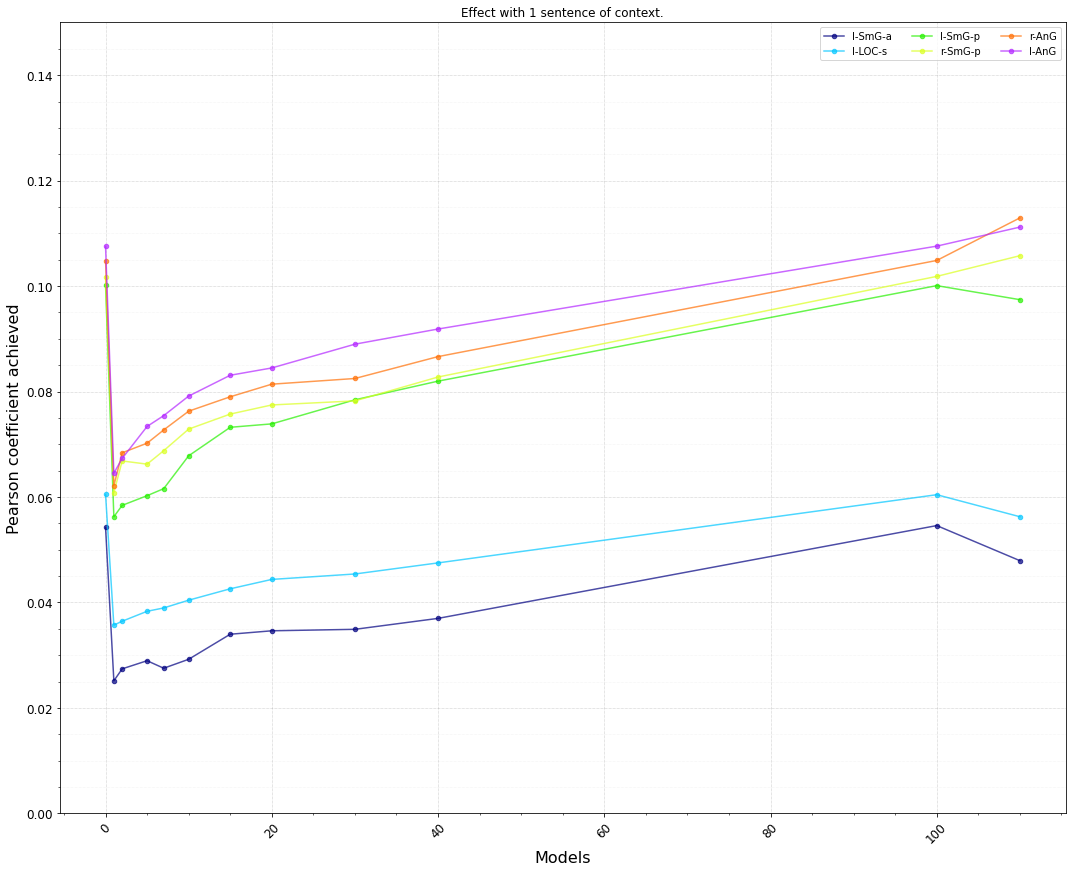

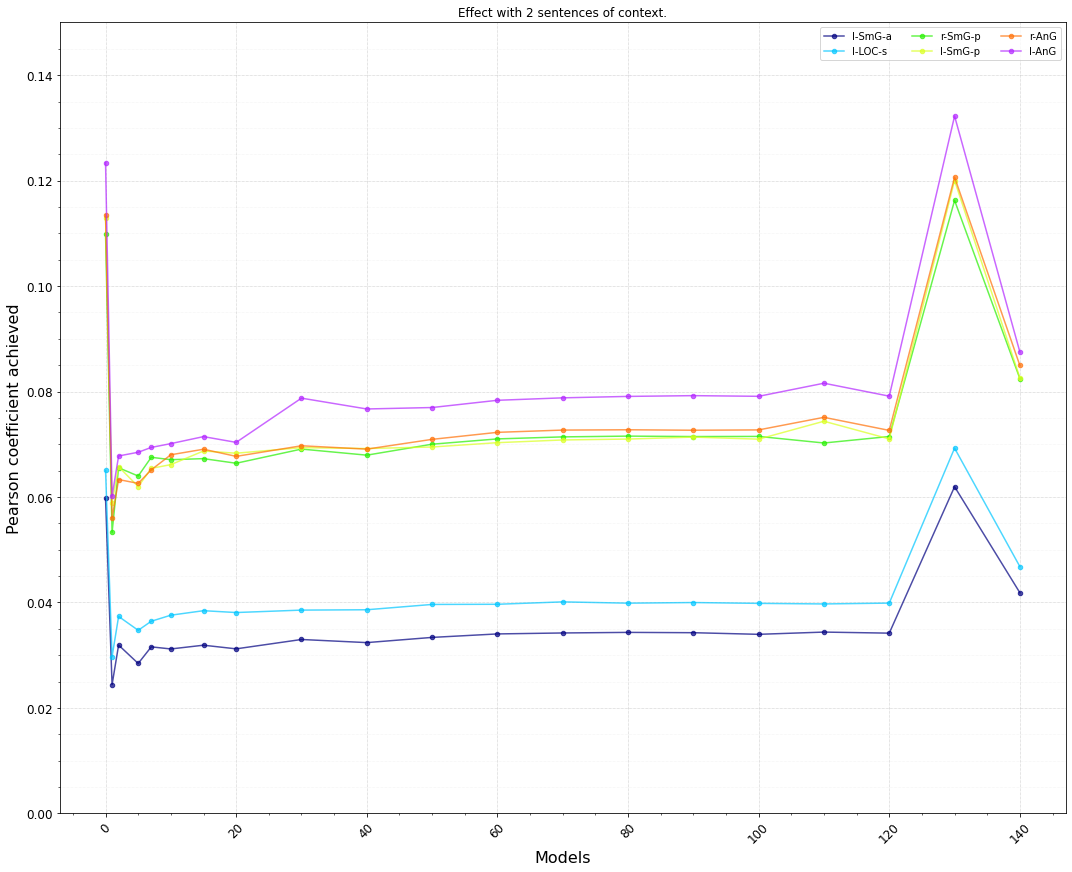

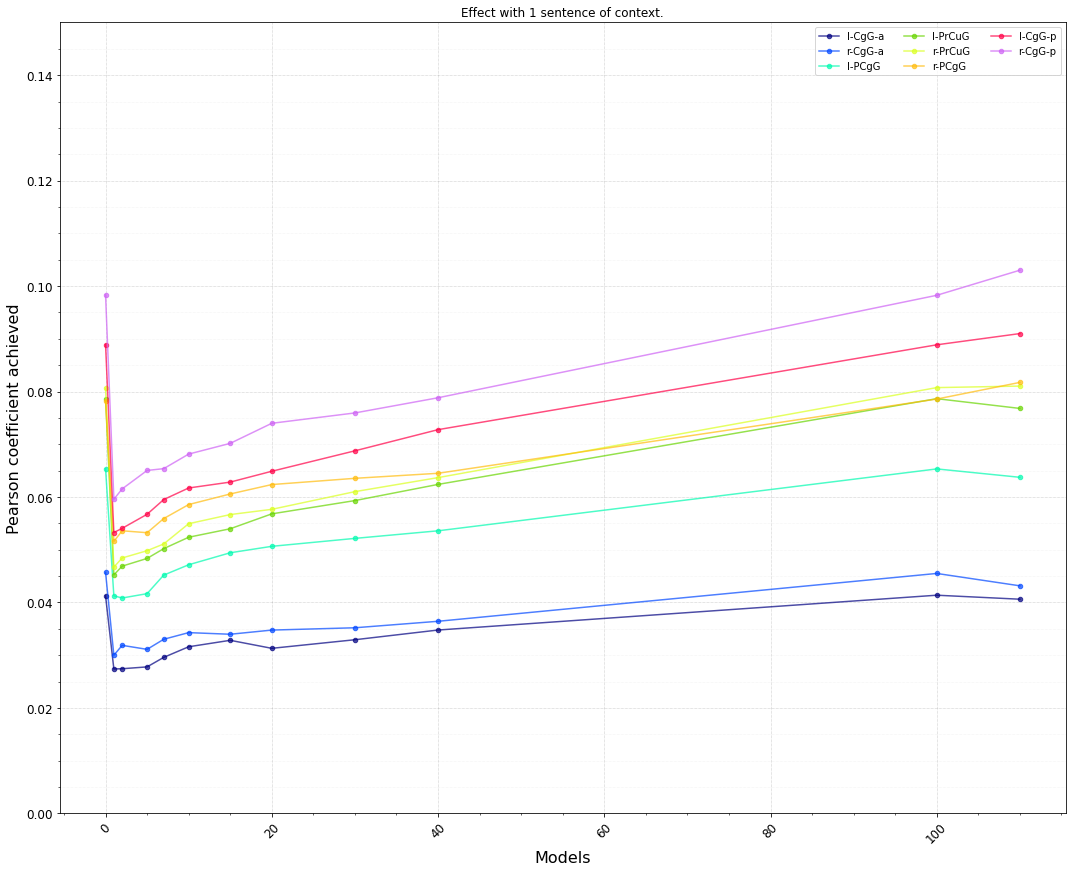

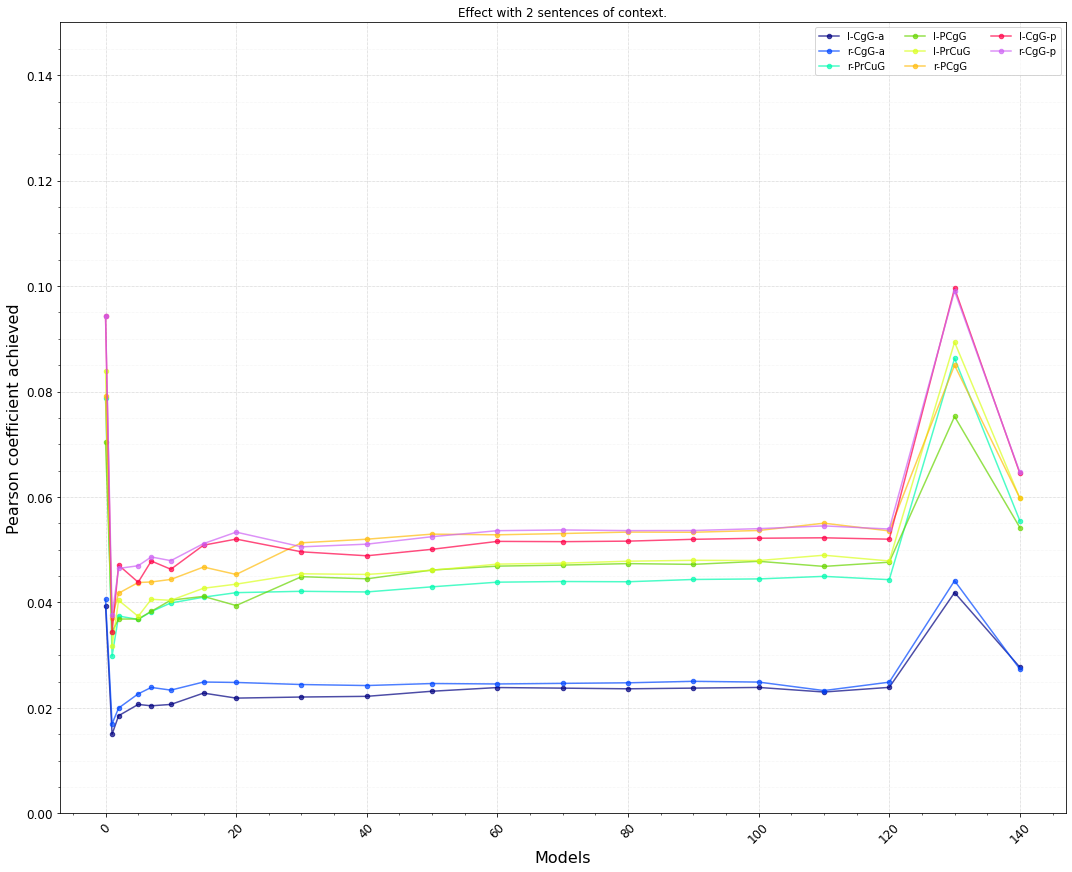

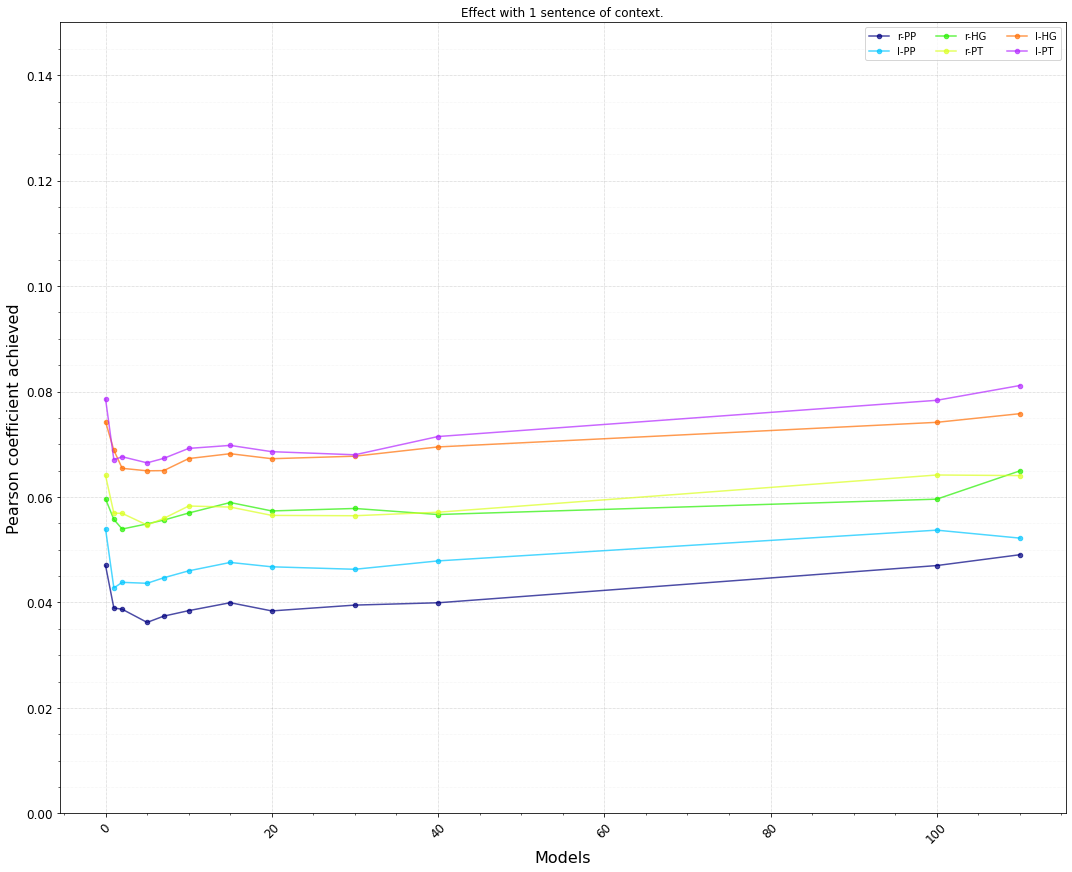

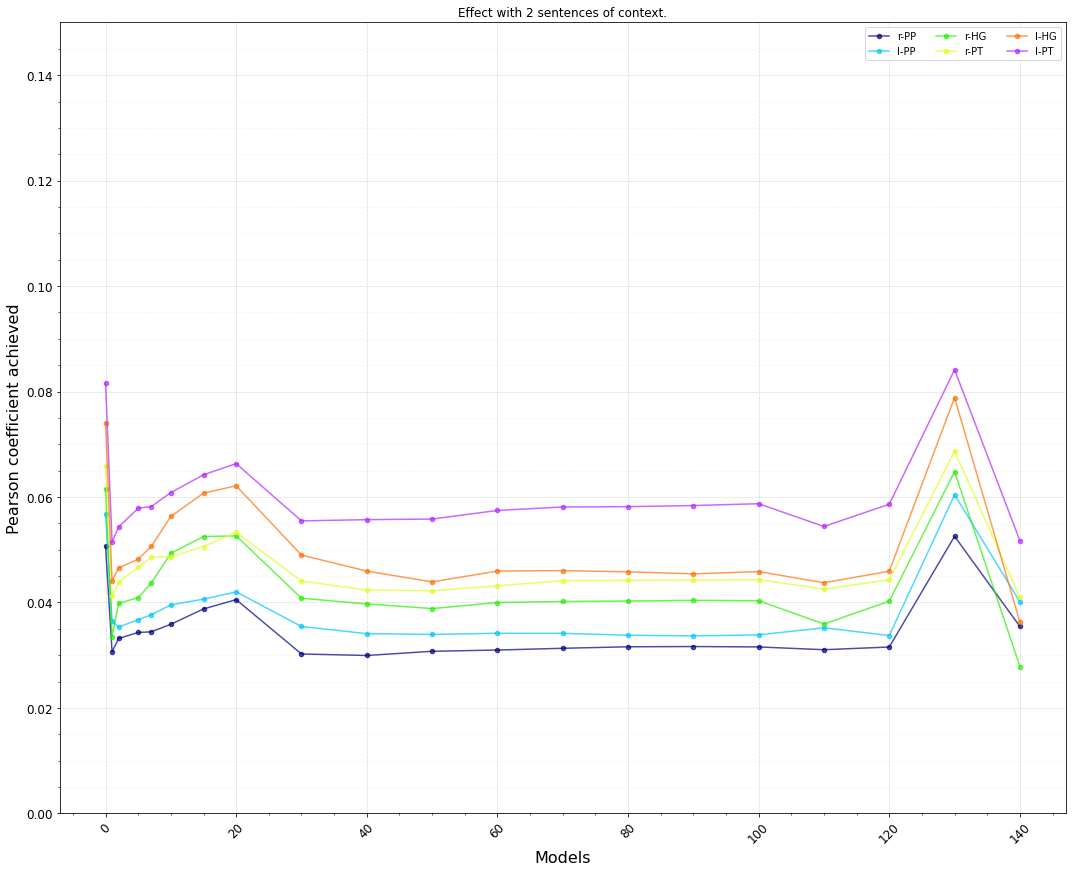

In [164]:
data = median
data_3sent = median_3sent

reporting.clever_plot(
        median_gpt2, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 100, 110]),
        save_folder=None, 
        roi_filter=[
            'Left Frontal Pole',
 'Right Frontal Pole',
 'Left Superior Frontal Gyrus',
 'Right Superior Frontal Gyrus',
 'Left Middle Frontal Gyrus',
 'Right Middle Frontal Gyrus',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 1 sentence of context.',
        y_limit=(0, 0.15)
    )
reporting.clever_plot(
        data_3sent, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]), 
        save_folder=None, 
        roi_filter=[
            'Left Frontal Pole',
 'Right Frontal Pole',
 'Left Superior Frontal Gyrus',
 'Right Superior Frontal Gyrus',
 'Left Middle Frontal Gyrus',
 'Right Middle Frontal Gyrus',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 2 sentences of context.',
        y_limit=(0, 0.15)
    )
#--------------------------------------------------------------------------------------------------
reporting.clever_plot(
        median_gpt2, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 100, 110]),
        save_folder=None, 
        roi_filter=[
            'Left Inferior Frontal Gyrus, pars triangularis',
 'Right Inferior Frontal Gyrus, pars triangularis',
 'Left Inferior Frontal Gyrus, pars opercularis',
 'Right Inferior Frontal Gyrus, pars opercularis',
 'Left Temporal Pole',
 'Right Temporal Pole',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 1 sentence of context.',
        y_limit=(0, 0.15)
    )
reporting.clever_plot(
        data_3sent, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]), 
        save_folder=None, 
        roi_filter=[
            'Left Inferior Frontal Gyrus, pars triangularis',
 'Right Inferior Frontal Gyrus, pars triangularis',
 'Left Inferior Frontal Gyrus, pars opercularis',
 'Right Inferior Frontal Gyrus, pars opercularis',
 'Left Temporal Pole',
 'Right Temporal Pole',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 2 sentences of context.',
        y_limit=(0, 0.15)
    )
#--------------------------------------------------------------------------------------------------


reporting.clever_plot(
        median_gpt2, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 100, 110]),
        save_folder=None, 
        roi_filter=[
            'Left Superior Temporal Gyrus, anterior division',
 'Right Superior Temporal Gyrus, anterior division',
 'Left Superior Temporal Gyrus, posterior division',
 'Right Superior Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, anterior division',
 'Right Middle Temporal Gyrus, anterior division',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 1 sentence of context.',
        y_limit=(0, 0.15)
    )
reporting.clever_plot(
        data_3sent, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]), 
        save_folder=None, 
        roi_filter=[
            'Left Superior Temporal Gyrus, anterior division',
 'Right Superior Temporal Gyrus, anterior division',
 'Left Superior Temporal Gyrus, posterior division',
 'Right Superior Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, anterior division',
 'Right Middle Temporal Gyrus, anterior division',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 2 sentences of context.',
        y_limit=(0, 0.15)
    )
#--------------------------------------------------------------------------------------------------


reporting.clever_plot(
        median_gpt2, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 100, 110]),
        save_folder=None, 
        roi_filter=[
            'Left Middle Temporal Gyrus, posterior division',
 'Right Middle Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, temporooccipital part',
 'Right Middle Temporal Gyrus, temporooccipital part',
 'Right Inferior Temporal Gyrus, anterior division',
 'Left Inferior Temporal Gyrus, temporooccipital part',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 1 sentence of context.',
        y_limit=(0, 0.15)
    )
reporting.clever_plot(
        data_3sent, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]), 
        save_folder=None, 
        roi_filter=[
            'Left Middle Temporal Gyrus, posterior division',
 'Right Middle Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, temporooccipital part',
 'Right Middle Temporal Gyrus, temporooccipital part',
 'Right Inferior Temporal Gyrus, anterior division',
 'Left Inferior Temporal Gyrus, temporooccipital part',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 2 sentences of context.',
        y_limit=(0, 0.15)
    )
#--------------------------------------------------------------------------------------------------


reporting.clever_plot(
        median_gpt2, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 100, 110]),
        save_folder=None, 
        roi_filter=[
            'Left Supramarginal Gyrus, anterior division',
 'Left Supramarginal Gyrus, posterior division',
 'Right Supramarginal Gyrus, posterior division',
 'Left Angular Gyrus',
 'Right Angular Gyrus',
 'Left Lateral Occipital Cortex, superior division',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 1 sentence of context.',
        y_limit=(0, 0.15)
    )
reporting.clever_plot(
        data_3sent, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]), 
        save_folder=None, 
        roi_filter=[
            'Left Supramarginal Gyrus, anterior division',
 'Left Supramarginal Gyrus, posterior division',
 'Right Supramarginal Gyrus, posterior division',
 'Left Angular Gyrus',
 'Right Angular Gyrus',
 'Left Lateral Occipital Cortex, superior division',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 2 sentences of context.',
        y_limit=(0, 0.15)
    )
#--------------------------------------------------------------------------------------------------


reporting.clever_plot(
        median_gpt2, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 100, 110]),
        save_folder=None, 
        roi_filter=[
 'Left Paracingulate Gyrus',
 'Right Paracingulate Gyrus',
 'Left Cingulate Gyrus, anterior division',
 'Right Cingulate Gyrus, anterior division',
 'Left Cingulate Gyrus, posterior division',
 'Right Cingulate Gyrus, posterior division',
 'Left Precuneous Cortex',
 'Right Precuneous Cortex',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 1 sentence of context.',
        y_limit=(0, 0.15)
    )
reporting.clever_plot(
        data_3sent, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]), 
        save_folder=None, 
        roi_filter=[
 'Left Paracingulate Gyrus',
 'Right Paracingulate Gyrus',
 'Left Cingulate Gyrus, anterior division',
 'Right Cingulate Gyrus, anterior division',
 'Left Cingulate Gyrus, posterior division',
 'Right Cingulate Gyrus, posterior division',
 'Left Precuneous Cortex',
 'Right Precuneous Cortex',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 2 sentences of context.',
        y_limit=(0, 0.15)
    )
#--------------------------------------------------------------------------------------------------


reporting.clever_plot(
        median_gpt2, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 100, 110]),
        save_folder=None, 
        roi_filter=[
 'Left Planum Polare',
 'Right Planum Polare',
 "Left Heschl's Gyrus (includes H1 and H2)",
 "Right Heschl's Gyrus (includes H1 and H2)",
 'Left Planum Temporale',
 'Right Planum Temporale',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 1 sentence of context.',
        y_limit=(0, 0.15)
    )
reporting.clever_plot(
        data_3sent, 
        labels, 
        np.array([0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]), 
        save_folder=None, 
        roi_filter=[
 'Left Planum Polare',
 'Right Planum Polare',
 "Left Heschl's Gyrus (includes H1 and H2)",
 "Right Heschl's Gyrus (includes H1 and H2)",
 'Left Planum Temporale',
 'Right Planum Temporale',],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Models',
        plot_name='Model_comparison',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='Effect with 2 sentences of context.',
        y_limit=(0, 0.15)
    )

In [84]:
model_names = [
#'gpt2_pre-20_token-0_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-2_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-3_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-4_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-5_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-7_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-10_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-12_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-15_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-17_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-20_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-25_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-30_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-35_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-40_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-50_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-60_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-70_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-80_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-90_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-100_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-125_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-150_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-175_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-200_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-225_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-250_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-275_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-300_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-325_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-350_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-375_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'gpt2_pre-20_token-400_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#    
'bert-base-uncased_pre-4_token-1-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_token-2-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_token-5-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_token-10-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_token-15-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_token-20-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_token-30-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_token-40-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_token-50-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_token-60-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_token-70-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_token-100-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4_token-1000-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',

'bert-base-uncased_pre-4-3_token-1000-1_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-3_token-1000-2_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-3_token-1000-5_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-3_token-1000-10_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-3_token-1000-15_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-3_token-1000-20_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-3_token-1000-30_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-3_token-1000-40_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-3_token-1000-50_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-3_token-1000-60_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-3_token-1000-70_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-3_token-1000-100_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-3_token-1000-1000_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    
'bert-base-uncased_pre-4-2_token-1000-1_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-2_token-1000-2_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-2_token-1000-5_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-2_token-1000-10_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-2_token-1000-15_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-2_token-1000-20_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-2_token-1000-30_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-2_token-1000-40_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-2_token-1000-50_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-2_token-1000-60_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-2_token-1000-70_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-2_token-1000-100_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-2_token-1000-1000_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    
'bert-base-uncased_pre-4-1_token-1000-1_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-1_token-1000-2_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-1_token-1000-5_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-1_token-1000-10_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-1_token-1000-15_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-1_token-1000-20_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-1_token-1000-30_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-1_token-1000-40_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-1_token-1000-50_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-1_token-1000-60_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-1_token-1000-70_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-1_token-1000-100_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-1_token-1000-1000_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    
'bert-base-uncased_pre-4-0_token-1000-1_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-0_token-1000-2_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-0_token-1000-5_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-0_token-1000-10_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-0_token-1000-15_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-0_token-1000-20_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-0_token-1000-30_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-0_token-1000-40_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-0_token-1000-50_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-0_token-1000-60_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-0_token-1000-70_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-0_token-1000-100_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
'bert-base-uncased_pre-4-0_token-1000-1000_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    
    
#'bert-base-uncased_pre-20_1_post-0_stop-sent-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-1_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-2_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-3_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-4_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-5_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-6_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-7_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-8_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-9_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-10_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-11_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-12_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-13_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-14_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-15_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-16_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-17_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-18_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-19_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-2_1_post-1_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-2_1_post-2_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-2_1_post-3_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-3_1_post-1_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-3_1_post-2_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-3_1_post-3_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-4_1_post-1_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-4_1_post-2_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-4_1_post-3_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-4_1_post-4_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-5_1_post-1_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-5_1_post-2_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-5_1_post-3_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
#'bert-base-uncased_pre-5_1_post-4_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    
    #'gpt2_pre-0_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-1_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-2_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-3_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-5_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-6_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-7_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-8_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-9_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-10_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-11_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-12_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-13_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-14_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-15_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-16_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-17_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-18_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-19_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    
    #'gpt2_pre-20_1_stop-sent-0_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-2_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-3_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-4_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-5_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-6_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-7_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-8_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-9_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-10_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-11_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-12_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-13_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-14_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-15_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-16_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-17_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-18_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_stop-sent-19_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #
    #'gpt2_pre-5_1_stop-sent-0_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-5_1_stop-sent-1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-5_1_stop-sent-2_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-5_1_stop-sent-3_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-5_1_stop-sent-4_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-5_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #
    #'gpt2_pre-10_1_stop-sent-0_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-10_1_stop-sent-1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-10_1_stop-sent-2_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-10_1_stop-sent-3_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-10_1_stop-sent-4_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-10_1_stop-sent-5_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-10_1_stop-sent-6_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-10_1_stop-sent-7_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-10_1_stop-sent-8_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-10_1_stop-sent-9_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-10_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    
    
    #'gpt2_pre-4_sent-stop-1_-3_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-1_-2_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-1_-1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-1_0_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-1_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-1_2_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-1_3_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #
    #'gpt2_pre-4_sent-stop-2_-3_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-2_-2_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-2_-1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-2_0_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-2_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-2_2_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-2_3_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #
    #'gpt2_pre-4_sent-stop-3_-3_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-3_-2_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-3_-1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-3_0_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-3_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-3_2_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'gpt2_pre-4_sent-stop-3_3_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    
    
    
    
    #'bert-base-uncased_pre-4_1_post-3_token-1-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-2-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-5-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-10-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-50-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-100-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-200-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-1_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-2_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-3_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-4_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-5_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-7_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-10_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-12_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-15_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-17_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-20_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-25_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-30_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-35_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-40_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-50_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-60_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-70_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-90_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-4_1_post-3_token-1000-1000_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    #'bert-base-uncased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    

] 

legend_names = [
#'gpt2_pre-20_token-0',
#'gpt2_pre-20_token-1',
#'gpt2_pre-20_token-2',
#'gpt2_pre-20_token-3',
#'gpt2_pre-20_token-4',
#'gpt2_pre-20_token-5',
#'gpt2_pre-20_token-7',
#'gpt2_pre-20_token-10',
#'gpt2_pre-20_token-12',
#'gpt2_pre-20_token-15',
#'gpt2_pre-20_token-17',
#'gpt2_pre-20_token-20',
#'gpt2_pre-20_token-25',
#'gpt2_pre-20_token-30',
#'gpt2_pre-20_token-35',
#'gpt2_pre-20_token-40',
#'gpt2_pre-20_token-50',
#'gpt2_pre-20_token-60',
#'gpt2_pre-20_token-70',
#'gpt2_pre-20_token-80',
#'gpt2_pre-20_token-90',
#'gpt2_pre-20_token-100',
#'gpt2_pre-20_token-125',
#'gpt2_pre-20_token-150',
#'gpt2_pre-20_token-175',
#'gpt2_pre-20_token-200',
#'gpt2_pre-20_token-225',
#'gpt2_pre-20_token-250',
#'gpt2_pre-20_token-275',
#'gpt2_pre-20_token-300',
#'gpt2_pre-20_token-325',
#'gpt2_pre-20_token-350',
#'gpt2_pre-20_token-375',
#'gpt2_pre-20_token-400',
    

'bert-base-uncased_pre-4_token-1-0',
'bert-base-uncased_pre-4_token-2-0',
'bert-base-uncased_pre-4_token-5-0',
'bert-base-uncased_pre-4_token-10-0',
'bert-base-uncased_pre-4_token-15-0',
'bert-base-uncased_pre-4_token-20-0',
'bert-base-uncased_pre-4_token-30-0',
'bert-base-uncased_pre-4_token-40-0',
'bert-base-uncased_pre-4_token-50-0',
'bert-base-uncased_pre-4_token-60-0',
'bert-base-uncased_pre-4_token-70-0',
'bert-base-uncased_pre-4_token-100-0',
'bert-base-uncased_pre-4_token-1000-0',

'bert-base-uncased_pre-4-3_token-1000-1',
'bert-base-uncased_pre-4-3_token-1000-2',
'bert-base-uncased_pre-4-3_token-1000-5',
'bert-base-uncased_pre-4-3_token-1000-10',
'bert-base-uncased_pre-4-3_token-1000-15',
'bert-base-uncased_pre-4-3_token-1000-20',
'bert-base-uncased_pre-4-3_token-1000-30',
'bert-base-uncased_pre-4-3_token-1000-40',
'bert-base-uncased_pre-4-3_token-1000-50',
'bert-base-uncased_pre-4-3_token-1000-60',
'bert-base-uncased_pre-4-3_token-1000-70',
'bert-base-uncased_pre-4-3_token-1000-100',
'bert-base-uncased_pre-4-3_token-1000-1000',
    
'bert-base-uncased_pre-4-2_token-1000-1',
'bert-base-uncased_pre-4-2_token-1000-2',
'bert-base-uncased_pre-4-2_token-1000-5',
'bert-base-uncased_pre-4-2_token-1000-10',
'bert-base-uncased_pre-4-2_token-1000-15',
'bert-base-uncased_pre-4-2_token-1000-20',
'bert-base-uncased_pre-4-2_token-1000-30',
'bert-base-uncased_pre-4-2_token-1000-40',
'bert-base-uncased_pre-4-2_token-1000-50',
'bert-base-uncased_pre-4-2_token-1000-60',
'bert-base-uncased_pre-4-2_token-1000-70',
'bert-base-uncased_pre-4-2_token-1000-100',
'bert-base-uncased_pre-4-2_token-1000-1000',
    
'bert-base-uncased_pre-4-1_token-1000-1',
'bert-base-uncased_pre-4-1_token-1000-2',
'bert-base-uncased_pre-4-1_token-1000-5',
'bert-base-uncased_pre-4-1_token-1000-10',
'bert-base-uncased_pre-4-1_token-1000-15',
'bert-base-uncased_pre-4-1_token-1000-20',
'bert-base-uncased_pre-4-1_token-1000-30',
'bert-base-uncased_pre-4-1_token-1000-40',
'bert-base-uncased_pre-4-1_token-1000-50',
'bert-base-uncased_pre-4-1_token-1000-60',
'bert-base-uncased_pre-4-1_token-1000-70',
'bert-base-uncased_pre-4-1_token-1000-100',
'bert-base-uncased_pre-4-1_token-1000-1000',
    
'bert-base-uncased_pre-4-0_token-1000-1',
'bert-base-uncased_pre-4-0_token-1000-2',
'bert-base-uncased_pre-4-0_token-1000-5',
'bert-base-uncased_pre-4-0_token-1000-10',
'bert-base-uncased_pre-4-0_token-1000-15',
'bert-base-uncased_pre-4-0_token-1000-20',
'bert-base-uncased_pre-4-0_token-1000-30',
'bert-base-uncased_pre-4-0_token-1000-40',
'bert-base-uncased_pre-4-0_token-1000-50',
'bert-base-uncased_pre-4-0_token-1000-60',
'bert-base-uncased_pre-4-0_token-1000-70',
'bert-base-uncased_pre-4-0_token-1000-100',
'bert-base-uncased_pre-4-0_token-1000-1000',


#'bert-base-uncased_pre-20_1_post-0_stop-sent-0',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-1',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-2',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-3',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-4',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-5',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-6',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-7',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-8',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-9',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-10',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-11',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-12',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-13',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-14',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-15',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-16',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-17',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-18',
#'bert-base-uncased_pre-20_1_post-0_stop-sent-19',
#'bert-base-uncased_pre-2_1_post-1',
#'bert-base-uncased_pre-2_1_post-2',
#'bert-base-uncased_pre-2_1_post-3',
#'bert-base-uncased_pre-3_1_post-1',
#'bert-base-uncased_pre-3_1_post-2',
#'bert-base-uncased_pre-3_1_post-3',
#'bert-base-uncased_pre-4_1_post-1',
#'bert-base-uncased_pre-4_1_post-2',
#'bert-base-uncased_pre-4_1_post-3',
#'bert-base-uncased_pre-4_1_post-4',
#'bert-base-uncased_pre-5_1_post-1',
#'bert-base-uncased_pre-5_1_post-2',
#'bert-base-uncased_pre-5_1_post-3',
#'bert-base-uncased_pre-5_1_post-4',
    
#'gpt2_pre-0_1',
#'gpt2_pre-1_1',
#'gpt2_pre-2_1',
#'gpt2_pre-3_1',
#'gpt2_pre-4_1',
#'gpt2_pre-5_1',
#'gpt2_pre-6_1',
#'gpt2_pre-7_1',
#'gpt2_pre-8_1',
#'gpt2_pre-9_1',
#'gpt2_pre-10_1',
#'gpt2_pre-11_1',
#'gpt2_pre-12_1',
#'gpt2_pre-13_1',
#'gpt2_pre-14_1',
#'gpt2_pre-15_1',
#'gpt2_pre-16_1',
#'gpt2_pre-17_1',
#'gpt2_pre-18_1',
#'gpt2_pre-19_1',
#'gpt2_pre-20_1',

#'gpt2_pre-20_1_stop-sent-0',
#'gpt2_pre-20_1_stop-sent-1',
#'gpt2_pre-20_1_stop-sent-2',
#'gpt2_pre-20_1_stop-sent-3',
#'gpt2_pre-20_1_stop-sent-4',
#'gpt2_pre-20_1_stop-sent-5',
#'gpt2_pre-20_1_stop-sent-6',
#'gpt2_pre-20_1_stop-sent-7',
#'gpt2_pre-20_1_stop-sent-8',
#'gpt2_pre-20_1_stop-sent-9',
#'gpt2_pre-20_1_stop-sent-10',
#'gpt2_pre-20_1_stop-sent-11',
#'gpt2_pre-20_1_stop-sent-12',
#'gpt2_pre-20_1_stop-sent-13',
#'gpt2_pre-20_1_stop-sent-14',
#'gpt2_pre-20_1_stop-sent-15',
#'gpt2_pre-20_1_stop-sent-16',
#'gpt2_pre-20_1_stop-sent-17',
#'gpt2_pre-20_1_stop-sent-18',
#'gpt2_pre-20_1_stop-sent-19',
#'gpt2_pre-20_1_stop-sent-20',
#
#'gpt2_pre-5_1_stop-sent-0',
#'gpt2_pre-5_1_stop-sent-1',
#'gpt2_pre-5_1_stop-sent-2',
#'gpt2_pre-5_1_stop-sent-3',
#'gpt2_pre-5_1_stop-sent-4',
#'gpt2_pre-5_1_stop-sent-5',
#    
#'gpt2_pre-10_1_stop-sent-0',
#'gpt2_pre-10_1_stop-sent-1',
#'gpt2_pre-10_1_stop-sent-2',
#'gpt2_pre-10_1_stop-sent-3',
#'gpt2_pre-10_1_stop-sent-4',
#'gpt2_pre-10_1_stop-sent-5',
#'gpt2_pre-10_1_stop-sent-6',
#'gpt2_pre-10_1_stop-sent-7',
#'gpt2_pre-10_1_stop-sent-8',
#'gpt2_pre-10_1_stop-sent-9',
#'gpt2_pre-10_1_stop-sent-10',
    
#'gpt2_pre-4_sent-stop-1_-3',
#'gpt2_pre-4_sent-stop-1_-2',
#'gpt2_pre-4_sent-stop-1_-1',
#'gpt2_pre-4_sent-stop-1_0',
#'gpt2_pre-4_sent-stop-1_1',
#'gpt2_pre-4_sent-stop-1_2',
#'gpt2_pre-4_sent-stop-1_3',
#
#'gpt2_pre-4_sent-stop-2_-3',
#'gpt2_pre-4_sent-stop-2_-2',
#'gpt2_pre-4_sent-stop-2_-1',
#'gpt2_pre-4_sent-stop-2_0',
#'gpt2_pre-4_sent-stop-2_1',
#'gpt2_pre-4_sent-stop-2_2',
#'gpt2_pre-4_sent-stop-2_3',
#
#'gpt2_pre-4_sent-stop-3_-3',
#'gpt2_pre-4_sent-stop-3_-2',
#'gpt2_pre-4_sent-stop-3_-1',
#'gpt2_pre-4_sent-stop-3_0',
#'gpt2_pre-4_sent-stop-3_1',
#'gpt2_pre-4_sent-stop-3_2',
#'gpt2_pre-4_sent-stop-3_3',


#'bert-base-uncased_pre-4_1_post-3_token-1-0',
#'bert-base-uncased_pre-4_1_post-3_token-2-0',
#'bert-base-uncased_pre-4_1_post-3_token-5-0',
#'bert-base-uncased_pre-4_1_post-3_token-10-0',
#'bert-base-uncased_pre-4_1_post-3_token-50-0',
#'bert-base-uncased_pre-4_1_post-3_token-100-0',
#'bert-base-uncased_pre-4_1_post-3_token-200-0',
#'bert-base-uncased_pre-4_1_post-3_token-1000-0',
#'bert-base-uncased_pre-4_1_post-3_token-1000-1',
#'bert-base-uncased_pre-4_1_post-3_token-1000-2',
#'bert-base-uncased_pre-4_1_post-3_token-1000-3',
#'bert-base-uncased_pre-4_1_post-3_token-1000-4',
#'bert-base-uncased_pre-4_1_post-3_token-1000-5',
#'bert-base-uncased_pre-4_1_post-3_token-1000-7',
#'bert-base-uncased_pre-4_1_post-3_token-1000-10',
#'bert-base-uncased_pre-4_1_post-3_token-1000-12',
#'bert-base-uncased_pre-4_1_post-3_token-1000-15',
#'bert-base-uncased_pre-4_1_post-3_token-1000-17',
#'bert-base-uncased_pre-4_1_post-3_token-1000-20',
#'bert-base-uncased_pre-4_1_post-3_token-1000-25',
#'bert-base-uncased_pre-4_1_post-3_token-1000-30',
#'bert-base-uncased_pre-4_1_post-3_token-1000-35',
#'bert-base-uncased_pre-4_1_post-3_token-1000-40',
#'bert-base-uncased_pre-4_1_post-3_token-1000-50',
#'bert-base-uncased_pre-4_1_post-3_token-1000-60',
#'bert-base-uncased_pre-4_1_post-3_token-1000-70',
#'bert-base-uncased_pre-4_1_post-3_token-1000-90',
#'bert-base-uncased_pre-4_1_post-3_token-1000-1000',
#'bert_optim',
    

]



data_full = reporting.get_model_data(model_names, language, OUTPUT_PATH)

maps = [data_full[name]['Pearson_coeff'] for name in data_full.keys()]
mean_maps = Parallel(n_jobs=-2)(delayed(mean_img)(imgs) for imgs in maps)
median, third_quartile, maximum, size = fit_per_roi(
    mean_maps, 
    atlas_maps, 
    labels, 
    global_mask=None, 
    mask_img=os.path.join(ALL_MASKS_PATH, 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
    PROJECT_PATH=PROJECT_PATH
)


  2%|▏         | 1/51 [00:00<00:14,  3.51it/s]

sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:11,  4.13it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:01<00:09,  4.84it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 12%|█▏        | 6/51 [00:01<00:08,  5.03it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:07,  5.79it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:07,  5.24it/s]

sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:02<00:08,  4.83it/s]

sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:02<00:07,  5.00it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:06,  5.20it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:03<00:06,  5.38it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:03<00:05,  5.67it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:03<00:04,  6.31it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:04<00:05,  5.22it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 47%|████▋     | 24/51 [00:04<00:04,  6.02it/s]

sub-082 - 1 - 1


 51%|█████     | 26/51 [00:04<00:04,  5.28it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:05<00:04,  5.51it/s]

sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:05<00:04,  5.31it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:05<00:03,  5.88it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:06<00:02,  6.70it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:06<00:02,  7.77it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:06<00:01,  7.57it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:06<00:01,  8.48it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:06<00:01,  8.54it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:07<00:01,  7.29it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 88%|████████▊ | 45/51 [00:07<00:00,  7.70it/s]

sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:07<00:00,  6.66it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:08<00:00,  6.14it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:07,  6.93it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  6.91it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  7.97it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:06,  6.87it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  7.37it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  6.96it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  7.77it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:04,  8.13it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:03,  8.42it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:04,  6.64it/s]

sub-078 - 1 - 1


 41%|████      | 21/51 [00:02<00:05,  5.97it/s]

sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:05,  5.57it/s]

sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:03<00:04,  5.43it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:04,  5.65it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:03,  6.57it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:04<00:03,  6.36it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:04<00:02,  7.27it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:04<00:02,  8.16it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:05<00:01,  8.54it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:05<00:01,  9.06it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:05<00:01,  8.50it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00, 10.38it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 96%|█████████▌| 49/51 [00:06<00:00, 12.11it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  8.87it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  9.00it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04,  8.81it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  7.55it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  7.07it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:05,  6.36it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:05,  6.87it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  7.90it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  8.12it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:04,  6.29it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:03,  6.99it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:03,  7.67it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  7.52it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:02,  8.67it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:01,  8.21it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:04<00:02,  7.16it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01,  7.80it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:05<00:01,  8.41it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:01,  7.35it/s]

sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00,  6.14it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 90%|█████████ | 46/51 [00:06<00:00,  5.40it/s]

sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:06<00:00,  5.08it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 12.19it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04, 10.41it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 11.12it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04, 10.18it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 11.46it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03, 10.78it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 13.27it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:01, 15.17it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 10.51it/s]

sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:03,  7.26it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:03,  6.48it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:02,  7.09it/s]

sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:02,  5.94it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:04<00:02,  5.46it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:02,  5.16it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:02,  4.97it/s]

sub-099 - 1 - 1


 80%|████████  | 41/51 [00:05<00:02,  4.80it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 82%|████████▏ | 42/51 [00:05<00:01,  5.16it/s]

sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:01,  4.68it/s]

sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:06<00:01,  4.72it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 90%|█████████ | 46/51 [00:06<00:01,  4.92it/s]

sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:06<00:00,  5.03it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:06<00:00,  6.26it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:08,  6.20it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:07,  6.47it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  7.10it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  7.73it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  7.32it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  7.39it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:05,  7.53it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:04,  7.91it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:03,  9.02it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:03,  8.57it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  8.20it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:03<00:03,  7.72it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:03<00:03,  8.07it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:03,  7.31it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  7.97it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:02,  7.83it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:01,  8.26it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  9.73it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  9.11it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:05<00:00,  9.55it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00,  9.16it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  9.94it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:08,  5.77it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  6.65it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:07,  5.99it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:06,  6.93it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  6.71it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  7.56it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:04,  7.88it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:03,  8.31it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  8.48it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:02, 10.40it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:01, 11.16it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 10.96it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 10.91it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:00, 13.13it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:00, 13.39it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:00, 11.36it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00, 10.48it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00,  9.81it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:10,  4.81it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:09,  5.00it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:01<00:08,  5.09it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:07,  5.57it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:06,  6.40it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:02<00:05,  6.76it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:02<00:06,  6.06it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:05,  6.87it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  7.39it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:03<00:04,  6.64it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:03,  8.08it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:02,  8.97it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084

 53%|█████▎    | 27/51 [00:03<00:02,  8.61it/s]

 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:04<00:01, 10.37it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:01, 10.11it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:01,  9.42it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  9.92it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:05<00:01,  8.96it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:05<00:01,  7.76it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 82%|████████▏ | 42/51 [00:05<00:01,  7.33it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00,  8.73it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:06<00:00,  8.34it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:09,  5.04it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:09,  5.12it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:01<00:08,  5.10it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:07,  5.83it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:06,  6.19it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:02<00:05,  6.39it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:04,  8.15it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:03,  9.35it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 12.36it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:01, 13.37it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:01, 13.03it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 12.91it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 13.62it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:00, 15.36it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00, 17.99it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 15.68it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.85it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.73it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:06,  6.29it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:06,  6.28it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  6.93it/s]

sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:06,  6.25it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:05,  6.31it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:05,  6.35it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  7.62it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:04,  7.13it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:03,  7.45it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:03,  7.79it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:02,  8.41it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  8.32it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:04<00:02,  8.20it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:02,  7.48it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01,  8.12it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  9.43it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 80%|████████  | 41/51 [00:05<00:01,  7.72it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:00,  8.10it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00,  8.25it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00,  8.81it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:07,  6.45it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:06,  6.92it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.31it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:06,  6.55it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  6.87it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  7.14it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  7.68it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:04,  8.17it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:03,  8.32it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  9.63it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02,  9.97it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:02, 10.50it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02,  9.89it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  8.98it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:01,  9.77it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  9.67it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  9.94it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00,  9.41it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00,  7.60it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00,  8.75it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:05<00:00,  8.31it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  8.49it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  4%|▍         | 2/51 [00:00<00:05,  8.71it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  7.99it/s]

sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:07,  6.11it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:07,  5.91it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:06,  6.57it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  7.18it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:04,  9.00it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:03, 10.12it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:02<00:02, 11.47it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:01, 13.00it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 14.95it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 15.59it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:00, 16.75it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 13.06it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 12.25it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00, 10.75it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 11.10it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00,  9.63it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00,  9.62it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:09,  5.42it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  4%|▍         | 2/51 [00:00<00:09,  4.96it/s]

sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:09,  4.85it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 12%|█▏        | 6/51 [00:01<00:08,  5.24it/s]

sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:08,  5.10it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:07,  5.38it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:02<00:07,  5.37it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 25%|██▌       | 13/51 [00:02<00:06,  6.21it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:05,  6.60it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:03<00:04,  7.92it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 39%|███▉      | 20/51 [00:03<00:04,  6.53it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:03<00:03,  7.43it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:04<00:03,  6.32it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:04<00:03,  7.19it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:04<00:02,  7.13it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:05<00:02,  6.58it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:05<00:02,  6.98it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:05<00:02,  5.76it/s]

sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:05<00:01,  6.70it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 80%|████████  | 41/51 [00:06<00:01,  7.26it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:06<00:01,  6.85it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:06<00:00,  7.32it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:07<00:00,  7.89it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:06,  7.73it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  9.27it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04, 10.82it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:05,  8.28it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:06,  6.68it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  7.34it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  7.41it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:04,  7.87it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  7.88it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  7.92it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  8.41it/s]

sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:03<00:04,  6.48it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:03<00:03,  6.44it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:03,  7.34it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  7.50it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:04<00:02,  7.31it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:04<00:02,  7.49it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  8.47it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  9.64it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00, 12.69it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00, 11.32it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:07,  6.92it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:06,  7.53it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  7.61it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:04,  8.75it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  9.79it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 12.63it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 13.03it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02, 10.18it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 11.56it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 11.11it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 10.25it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 11.77it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 12.16it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 13.87it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 15.64it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00, 14.64it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.95it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  7.08it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04,  9.83it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:03, 10.79it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 14.45it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 15.48it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 12.92it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:02,  9.98it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02,  9.13it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:03,  7.55it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:03,  6.70it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:02,  7.51it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:02,  6.95it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:02,  6.82it/s]

sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:02,  6.81it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  6.80it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  6.56it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:01,  6.40it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00,  6.52it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  6.39it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00,  6.00it/s]

sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:07,  6.58it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.18it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:06,  6.96it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  8.63it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  8.56it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  8.61it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:03,  8.70it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:03,  8.13it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  9.40it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:03,  8.95it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:02,  9.52it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02,  8.98it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  8.41it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01,  9.39it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01,  9.89it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  9.47it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  7.53it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:01,  8.39it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00,  9.80it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  8.97it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:05,  9.10it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04, 10.07it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 11.33it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 11.63it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:02, 12.80it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 11.34it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 11.45it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:02, 11.13it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 10.90it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02,  9.97it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:02,  8.42it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:02,  9.12it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01,  9.66it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01,  9.56it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:01,  7.99it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:01,  7.28it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00,  7.36it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00,  7.96it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00,  8.70it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  9.94it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:04, 10.25it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04, 10.68it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 10.50it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:03, 12.05it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 15.94it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 14.77it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 13.71it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 13.68it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 10.89it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 11.10it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 12.93it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 13.72it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 14.12it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 11.95it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 14.14it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:02, 19.95it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:03, 14.41it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:02, 14.90it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:02, 13.61it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 13.79it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03, 10.88it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:03,  8.99it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 10.38it/s]

sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:03,  8.53it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 10.87it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 

 57%|█████▋    | 29/51 [00:02<00:02,  9.74it/s]

- 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:02<00:02,  9.18it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01,  9.04it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:02,  7.16it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01,  7.90it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  6.96it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  7.90it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00,  9.98it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 11.55it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:07,  6.88it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:06,  7.11it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  8.26it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  8.16it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  8.85it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  8.21it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03, 10.02it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:03,  8.39it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:04,  7.01it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02,  8.72it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:02,  8.13it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  9.07it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:02,  9.31it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 10.07it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01,  8.27it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  7.93it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  7.74it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00,  9.86it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00, 11.29it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  4%|▍         | 2/51 [00:00<00:05,  9.50it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  7.65it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:05,  8.03it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  8.20it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  9.12it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  7.90it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:05,  6.99it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:04,  6.84it/s]

sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:05,  5.96it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:04,  6.69it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:04,  6.73it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:03,  7.47it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 51%|█████     | 26/51 [00:03<00:03,  7.96it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02,  7.93it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:04<00:02,  7.36it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:02,  7.19it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:02,  7.63it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01,  8.41it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:05<00:01,  7.81it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:05<00:01,  7.35it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:01,  7.76it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:06<00:00,  6.99it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:06<00:00,  7.62it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 10.64it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  8.51it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04,  9.46it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:04, 10.06it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03,  9.85it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.76it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 11.01it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 11.43it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 11.15it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 11.01it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 11.89it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 12.39it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 14.90it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 12.20it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 13.45it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 14.41it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 12.74it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  9.40it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  9.18it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04,  9.10it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:03, 10.84it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 10.72it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 12.14it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 11.22it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02,  9.65it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02,  9.62it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02,  9.87it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  8.96it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:02,  8.97it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:02,  8.37it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01,  8.45it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01,  7.59it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  7.04it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:01,  7.15it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:01,  7.64it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  8.78it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  9.12it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04, 11.59it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  8.67it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04,  9.59it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:03, 11.09it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 11.08it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 12.19it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 11.30it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 10.83it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02,  9.65it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02,  8.98it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:02,  9.49it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 11.23it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 11.73it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 10.70it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01, 10.79it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 10.89it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 11.77it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 11.79it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


100%|██████████| 51/51 [00:04<00:00, 10.86it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1



  4%|▍         | 2/51 [00:00<00:05,  9.01it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  8.82it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04, 10.22it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 10.88it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 11.88it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 12.13it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 13.96it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:01<00:01, 13.96it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:01, 13.13it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 13.48it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 13.24it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:00, 14.47it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 12.90it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 10.28it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00,  8.96it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 10.40it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00,  9.60it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  8.93it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.23it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  6.74it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:06,  6.94it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  7.24it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  7.07it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:05,  7.37it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:05,  6.82it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:04,  7.07it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:03,  8.03it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:03,  9.29it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:02,  9.14it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:02,  9.73it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:01, 10.76it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 11.67it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01,  9.45it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01, 10.42it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  9.76it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00,  9.79it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  9.22it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  7.33it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:08,  5.80it/s]

sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:08,  5.67it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:08,  5.40it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 12%|█▏        | 6/51 [00:01<00:08,  5.35it/s]

sub-063 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:08,  5.16it/s]

sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:08,  5.00it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:02<00:08,  4.96it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 24%|██▎       | 12/51 [00:02<00:07,  5.22it/s]

sub-069 - 1 - 1


 25%|██▌       | 13/51 [00:02<00:07,  4.80it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:06,  5.51it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:03<00:04,  6.60it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:03<00:03,  7.91it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:03,  7.85it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:04<00:03,  8.16it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:04<00:02,  8.51it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:04<00:02,  9.87it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:01, 11.15it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:05<00:01, 10.26it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 76%|███████▋  | 39/51 [00:05<00:01, 11.18it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:00, 11.46it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00, 11.24it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:06<00:00, 10.94it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:08,  5.82it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:07,  6.39it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:05,  7.75it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:04,  8.28it/s]

sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:03<00:30,  1.33it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:03<00:14,  2.42it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:03<00:10,  3.12it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:04<00:06,  4.48it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:04<00:04,  6.16it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:04<00:03,  7.43it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:04<00:02,  9.09it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:04<00:02,  9.12it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:05<00:01,  9.09it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:05<00:01, 10.76it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:05<00:00, 11.82it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:06<00:01,  8.04it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:06<00:00,  7.49it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 88%|████████▊ | 45/51 [00:06<00:00,  7.67it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:07<00:00,  7.49it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:07<00:00,  7.34it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:08,  5.88it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  4%|▍         | 2/51 [00:00<00:07,  6.48it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


  8%|▊         | 4/51 [00:00<00:06,  6.81it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:05,  8.06it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  9.14it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  8.93it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:04,  8.98it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:03, 10.00it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  9.12it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02,  9.71it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 11.13it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 10.89it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 10.59it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 11.17it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01, 10.24it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00, 10.09it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 11.31it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 11.13it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  8.40it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.11it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:06,  6.63it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:06,  6.35it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  7.07it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  7.16it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:05,  7.12it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:04,  7.80it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:03,  8.74it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  8.94it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:03<00:03,  7.87it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:03<00:03,  6.84it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:03,  6.44it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:04<00:03,  6.28it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 61%|██████    | 31/51 [00:04<00:03,  6.49it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:04<00:02,  6.96it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:02,  7.54it/s]

sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:05<00:02,  6.03it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 75%|███████▍  | 38/51 [00:05<00:02,  6.25it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:05<00:01,  7.10it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 82%|████████▏ | 42/51 [00:05<00:01,  7.31it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:06<00:00,  7.99it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:06<00:00,  7.96it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:06<00:00,  8.46it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:07,  6.92it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:07,  6.36it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  7.13it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.30it/s]

sub-063 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:07,  6.22it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  8.16it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  8.68it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03,  9.59it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:02<00:02, 12.30it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 12.53it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:01, 12.68it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 12.56it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:01, 12.38it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 12.89it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 10.25it/s]

sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01,  8.14it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  7.24it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:01,  6.32it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:01,  6.63it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00,  8.03it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:08,  6.15it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:06,  7.34it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 10%|▉         | 5/51 [00:00<00:07,  6.53it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:06,  6.96it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:06,  6.67it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  7.48it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  7.91it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:04,  8.56it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:03,  8.14it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  8.92it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:02,  9.57it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:02, 10.43it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 11.15it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 10.37it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:01,  8.69it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  9.53it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  8.90it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:00,  9.07it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:05<00:00,  7.56it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00,  6.50it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00,  7.42it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  7.91it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:07,  6.80it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:07,  6.76it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  6.67it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  7.75it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  7.77it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  7.99it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  8.32it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:04,  8.62it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:05,  6.74it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:04,  7.10it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 11.00it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 13.80it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:01, 10.55it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 12.19it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 12.47it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 13.92it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00, 14.85it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:11,  4.43it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:09,  5.09it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 10%|▉         | 5/51 [00:00<00:08,  5.45it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:06,  6.25it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:06,  6.57it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  6.82it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:04,  7.67it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:05,  6.29it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:04,  7.28it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:03<00:03,  7.45it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:04,  6.88it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:03,  7.54it/s]

sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:03,  6.65it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:03,  6.77it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:04<00:02,  8.68it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:04<00:01,  9.59it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01, 10.22it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01,  8.85it/s]

sub-098 - 1 - 1


 82%|████████▏ | 42/51 [00:05<00:01,  7.81it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:05<00:00,  7.13it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00,  7.31it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 94%|█████████▍| 48/51 [00:06<00:00,  8.23it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:04, 11.83it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04, 10.98it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04, 10.72it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:04, 10.14it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  9.64it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 11.25it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 12.00it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 12.51it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:01, 14.27it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 11.42it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 10.84it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 10.14it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01,  8.74it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01,  8.38it/s]

sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01,  6.86it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:01,  7.75it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:01,  7.85it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00,  8.76it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00,  9.38it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:04<00:00,  8.69it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:07,  6.11it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  6.88it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:05,  8.16it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  9.35it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  8.61it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.79it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  8.08it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  8.56it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  8.07it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:03,  8.47it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:03,  7.60it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:03,  6.81it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  6.95it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:04<00:02,  7.76it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  8.37it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  8.12it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:00,  9.30it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:05<00:00,  8.71it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  7.57it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  8.79it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 12.55it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04, 10.80it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.78it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04,  8.64it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  9.38it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  9.16it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.20it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03,  9.12it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:03, 10.28it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02,  9.84it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 10.36it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02,  9.59it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  7.91it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:02,  8.86it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01,  8.99it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  8.43it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 80%|████████  | 41/51 [00:04<00:00, 10.64it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00,  9.73it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00,  9.08it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  9.06it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00, 10.52it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:08,  6.20it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:07,  6.41it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  6.96it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:06,  7.17it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  7.60it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:06,  6.62it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:05,  6.90it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:05,  6.63it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  7.77it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  7.80it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:03,  7.79it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:03,  8.09it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:02,  8.15it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  8.80it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  8.96it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:01,  9.07it/s]

sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:02,  6.42it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  7.05it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:05<00:01,  7.34it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:05<00:01,  7.08it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:01,  7.64it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00,  7.54it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 90%|█████████ | 46/51 [00:06<00:00,  7.11it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:06<00:00,  6.90it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:07,  6.63it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  7.71it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:06,  6.98it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  7.02it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  8.01it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  7.76it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:04,  8.51it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  7.43it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:03,  8.50it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  8.61it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 10.66it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:02,  9.85it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02,  9.89it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01,  9.99it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:01,  8.30it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  8.56it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  7.54it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:01,  8.07it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:05<00:00,  7.88it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00,  8.59it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00,  8.33it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:05<00:00,  8.63it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:06,  8.11it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  4%|▍         | 2/51 [00:00<00:06,  7.20it/s]

sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:07,  6.44it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:06,  6.84it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:06,  6.78it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:07,  5.66it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:02<00:06,  5.92it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:04,  7.46it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  7.14it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:04,  7.44it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:03<00:03,  8.95it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 47%|████▋     | 24/51 [00:03<00:02,  9.03it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 51%|█████     | 26/51 [00:03<00:02,  9.29it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  9.61it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:04<00:01, 10.72it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01, 11.86it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01, 11.43it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  8.29it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:00,  8.23it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00,  8.74it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  8.08it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:09,  5.40it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:07,  6.13it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  7.56it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:06,  7.01it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  7.10it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  6.73it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  7.42it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:04,  7.04it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  6.93it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:04,  7.22it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  7.53it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:03,  7.69it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:03<00:03,  7.89it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:02,  8.26it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  8.54it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:01,  9.26it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:01,  8.99it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  9.10it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  9.36it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:05<00:00, 10.29it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:05<00:00, 10.88it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00, 10.97it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:05<00:00, 11.22it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  6%|▌         | 3/51 [00:00<00:02, 18.20it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 12.82it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04,  8.91it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  7.76it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  8.49it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03,  9.73it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03,  8.53it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:03,  8.69it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02,  9.93it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02,  9.29it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 10.82it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:02,  9.41it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  8.89it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:02,  8.45it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01,  8.03it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  7.20it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  7.00it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:01,  7.35it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00,  7.55it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  9.73it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  9.30it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.68it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:06,  7.20it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:06,  6.12it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  7.78it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  8.27it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:03,  9.03it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:03,  7.98it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  8.21it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02,  8.82it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:03,  7.94it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02,  8.02it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  7.39it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:02,  7.69it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:01,  8.41it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  7.64it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  6.81it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:05<00:01,  7.65it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:05<00:00,  9.24it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00,  8.95it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00, 10.31it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:06,  7.73it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:07,  6.16it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.27it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:05,  7.53it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  8.07it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  7.89it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:04,  8.12it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:03,  8.79it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:04,  7.70it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:04,  6.13it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:04,  6.93it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:03,  7.81it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:02,  8.66it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:01, 10.60it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 10.25it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01, 10.13it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01, 10.22it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:00,  9.69it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00, 10.71it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00, 11.59it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 10.08it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04,  9.80it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  7.66it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:04,  8.25it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  7.67it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  7.92it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:04,  7.86it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:03,  8.72it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:03,  8.23it/s]

sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:04,  6.69it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:03,  7.02it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:03,  8.06it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:03,  7.75it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02,  7.70it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  8.10it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:02,  8.35it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:01,  8.02it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:04<00:02,  7.02it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  8.42it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:05<00:01,  8.52it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00,  9.96it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00, 10.32it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  9.07it/s]

sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  6.96it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


  8%|▊         | 4/51 [00:00<00:06,  7.13it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:06,  6.78it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  7.28it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 10.23it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.98it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03,  9.33it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  9.08it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 10.17it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 11.96it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:01, 14.55it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 11.94it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 10.76it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01,  9.14it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:00, 10.79it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00, 10.44it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 12.72it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:07,  6.93it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:06,  7.53it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:07,  5.88it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  7.25it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  8.39it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 10.09it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03, 10.56it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:03,  9.36it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  9.19it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 10.52it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:01, 11.57it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 10.19it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 10.79it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 11.06it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01, 10.61it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  9.82it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00,  9.92it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 10.49it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00,  9.73it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:05<00:00,  8.28it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:06,  7.39it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  8.57it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04, 10.16it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04, 10.10it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:03, 10.09it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03,  9.47it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 10.90it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03, 10.31it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:03,  9.94it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  8.68it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:03,  8.57it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02,  9.30it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 10.95it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 10.00it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01,  9.63it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01,  9.85it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01,  9.13it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:01,  8.70it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00,  8.82it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00,  8.90it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  7.45it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:05,  8.57it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  9.12it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  8.43it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:05,  7.51it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  9.45it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  8.80it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.48it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:03,  8.71it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  9.55it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:03,  8.48it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02,  8.39it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:02,  8.79it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  9.02it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  8.66it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01,  8.60it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01,  8.89it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01,  8.65it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  9.67it/s]

sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:01,  8.01it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:05<00:00,  7.27it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00,  7.64it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00,  7.60it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:05,  8.80it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  8.09it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.33it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:05,  7.21it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  6.92it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  7.77it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.24it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03,  9.61it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:02<00:02, 10.78it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:03,  9.31it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02,  9.80it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:02,  8.80it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02,  9.26it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  9.03it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:02,  7.06it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01,  8.08it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01,  7.82it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  6.90it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:01,  7.55it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00,  9.49it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00,  9.74it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:05<00:00,  8.61it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  8.68it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  8.60it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  7.02it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:06,  6.81it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:06,  6.55it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  7.60it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:05,  7.26it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:05,  7.39it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:03,  9.24it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:03,  8.58it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  8.35it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02,  9.07it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:03,  8.51it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:02,  8.62it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  8.09it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01,  9.73it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01, 11.46it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01, 10.07it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  9.26it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00,  9.97it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00, 10.19it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00, 10.21it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  8%|▊         | 4/51 [00:00<00:03, 13.47it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 11.11it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:05,  8.25it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  8.60it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.81it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03, 10.67it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:03,  9.91it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02, 10.45it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02,  9.89it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02, 10.76it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 12.19it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 12.60it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 15.47it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 14.72it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 13.48it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 12.12it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 13.62it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:09,  5.24it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:08,  5.44it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:07,  5.76it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:07,  5.58it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:06,  6.70it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:06,  6.63it/s]

sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:05,  6.73it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:04,  7.43it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:04,  7.53it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  9.55it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 11.22it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 51%|█████     | 26/51 [00:03<00:01, 12.72it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:02, 10.15it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  8.94it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:02,  7.61it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 67%|██████▋   | 34/51 [00:04<00:02,  7.39it/s]

sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:02,  5.60it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:02,  6.49it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:05<00:01,  6.56it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:01,  6.50it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00,  7.78it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:06<00:00,  6.72it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:06<00:00,  7.47it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:07,  6.81it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.36it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  8.69it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:05,  7.78it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:03, 10.87it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 12.02it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 11.37it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 12.14it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 51%|█████     | 26/51 [00:02<00:01, 15.46it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 13.27it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 15.83it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:02<00:00, 15.88it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:00, 16.47it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 17.25it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 98%|█████████▊| 50/51 [00:03<00:00, 18.48it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.30it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


  8%|▊         | 4/51 [00:00<00:07,  6.13it/s]

sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:01<00:07,  5.66it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:06,  6.72it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:06,  6.79it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  7.07it/s]

sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:02<00:06,  6.23it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:06,  5.85it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:05,  6.09it/s]

sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:05,  5.98it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:03<00:04,  6.34it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 41%|████      | 21/51 [00:03<00:04,  6.03it/s]

sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:04,  6.11it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:04<00:04,  6.44it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:04<00:03,  6.25it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:04<00:03,  6.71it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:04<00:03,  5.73it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 63%|██████▎   | 32/51 [00:05<00:02,  6.54it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:05<00:02,  7.88it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:05<00:02,  6.92it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 75%|███████▍  | 38/51 [00:05<00:01,  6.93it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:06<00:01,  6.51it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:06<00:01,  7.61it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:06<00:00,  8.88it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:07<00:00,  7.37it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:07<00:00,  7.76it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:06,  8.18it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  7.93it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:05,  8.09it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  7.25it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  7.60it/s]

sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:06,  5.52it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:05,  6.51it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:05,  6.48it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  6.70it/s]

sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:05,  5.63it/s]

sub-077 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:05,  5.33it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:04,  6.00it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:03,  6.91it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:03,  6.78it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:04<00:03,  6.33it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:04<00:03,  6.35it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:02,  6.88it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:05<00:02,  7.07it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:05<00:01,  7.06it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:05<00:01,  6.39it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:06<00:01,  6.30it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:06<00:01,  7.15it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:06<00:00,  6.75it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:06<00:00,  7.25it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:06,  7.30it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  6%|▌         | 3/51 [00:00<00:07,  6.70it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.30it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:07,  6.03it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:06,  6.48it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  7.10it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:02<00:05,  7.17it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:04,  7.33it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:04,  7.69it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  8.77it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:01, 12.69it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 14.02it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 21.12it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 22.34it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 19.67it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:02, 21.42it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:02, 14.93it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 13.09it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 13.97it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 11.96it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 12.48it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 16.34it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:01, 16.51it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:00, 19.67it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:00, 18.87it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:00, 20.33it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:02<00:00, 14.56it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:02<00:00, 14.00it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 13.09it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.14it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:08,  5.63it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 12%|█▏        | 6/51 [00:01<00:09,  4.58it/s]

sub-063 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:09,  4.65it/s]

sub-064 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:09,  4.44it/s]

sub-065 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:09,  4.56it/s]

sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:02<00:08,  4.66it/s]

sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:02<00:08,  4.71it/s]

sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:02<00:08,  4.61it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:03<00:07,  5.09it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:03<00:06,  5.25it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 35%|███▌      | 18/51 [00:03<00:06,  5.36it/s]

sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:03<00:05,  5.51it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:04<00:04,  6.11it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:04<00:04,  6.39it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:04<00:04,  5.77it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:05<00:03,  6.34it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 57%|█████▋    | 29/51 [00:05<00:03,  5.96it/s]

sub-088 - 1 - 1


 61%|██████    | 31/51 [00:05<00:03,  5.93it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:06<00:02,  6.17it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:06<00:02,  6.33it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:06<00:02,  6.06it/s]

sub-096 - 1 - 1


 73%|███████▎  | 37/51 [00:06<00:02,  5.34it/s]

sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:07<00:02,  5.88it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:07<00:01,  6.74it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:07<00:00,  8.34it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 96%|█████████▌| 49/51 [00:08<00:00, 10.51it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:06,  7.62it/s]

sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:08,  5.81it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  7.18it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:05,  7.54it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  7.80it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  8.38it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:03,  9.60it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:03, 10.51it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02, 11.48it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 11.81it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 14.12it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 13.02it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 13.61it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 10.01it/s]

sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  7.61it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  6.58it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:01,  5.48it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:01,  5.81it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00,  5.56it/s]

sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00,  5.30it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:06<00:00,  5.33it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  9.75it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  4%|▍         | 2/51 [00:00<00:06,  8.05it/s]

sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:07,  6.66it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:01<00:07,  5.96it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:07,  5.61it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:07,  5.76it/s]

sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:06,  6.04it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:02<00:06,  6.05it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:05,  6.52it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:06,  5.66it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:03<00:05,  6.09it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:03<00:04,  7.17it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:04,  6.79it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:04<00:03,  6.99it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:04<00:02,  8.31it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:04<00:02,  7.15it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:04<00:02,  8.57it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:05<00:01,  8.10it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:05<00:01,  8.70it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:05<00:01,  7.97it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:05<00:01,  8.11it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:06<00:00,  8.46it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 88%|████████▊ | 45/51 [00:06<00:00,  8.59it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:06<00:00,  8.21it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:06<00:00,  8.51it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:07,  6.51it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


  8%|▊         | 4/51 [00:00<00:07,  6.46it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:06,  7.19it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  7.44it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  7.86it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:05,  7.54it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  8.02it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:04,  7.74it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:03,  8.57it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  8.85it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:03<00:02,  9.96it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:02,  8.83it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  9.41it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:04<00:01,  9.57it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01, 10.52it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01, 10.77it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  9.10it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:01,  7.52it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00,  8.91it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00, 10.56it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:02, 19.89it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:02, 15.30it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:03, 11.63it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 12.55it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 11.77it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 11.07it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03, 10.19it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 10.79it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 10.69it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 10.70it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02,  9.82it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:02, 10.03it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01,  9.39it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01,  9.25it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01,  7.78it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  8.50it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:01,  8.13it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00,  9.63it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00,  9.20it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:09,  5.25it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:07,  6.10it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  6.83it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:05,  7.77it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:06,  6.57it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  6.85it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:05,  7.45it/s]

sub-070 - 1 - 1


 27%|██▋       | 14/51 [00:02<00:06,  5.86it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:05,  6.35it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:04,  7.52it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:04,  7.05it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:03<00:03,  8.61it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:02,  9.35it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02, 10.25it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 10.63it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:02,  8.72it/s]

sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:02,  6.28it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:02,  6.35it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 75%|███████▍  | 38/51 [00:05<00:02,  5.49it/s]

sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:05<00:02,  5.19it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:05<00:01,  5.89it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:06<00:01,  6.16it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:06<00:00,  6.73it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 94%|█████████▍| 48/51 [00:06<00:00,  6.98it/s]

sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:06<00:00,  6.68it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  9.56it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.93it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  7.39it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  7.36it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  7.38it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:06,  6.59it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:05,  6.81it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:04,  7.15it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  6.70it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:04,  6.90it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:03,  8.07it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:02,  8.86it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:03,  7.42it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:04<00:03,  6.36it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:04<00:03,  6.54it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 63%|██████▎   | 32/51 [00:04<00:02,  7.09it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:02,  6.83it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:04<00:02,  5.88it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:05<00:01,  6.52it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:05<00:01,  6.38it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:01,  7.47it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:06<00:00,  6.37it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:06<00:00,  7.06it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:06<00:00,  7.28it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


100%|██████████| 51/51 [00:07<00:00,  7.21it/s]

sub-115 - 1 - 1



exception calling callback for <Future at 0x7ff61a7bb050 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/joblib/parallel.py", line 340, in __call__
    self.parallel.dispatch_next()
  File "/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/joblib/parallel.py", line 769, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/joblib/parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/joblib/parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Applications/anaconda3/envs/parieta

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6)}

In [470]:
a,b = split_data(median, labels)

In [19]:
def inv_paschen(x, a, b, c):
    return (np.log(b*x) - np.log(np.log(1 + 1/c)))/(a * x)

def serpentine(x, a, b):
    return (a * b * x)/(x**2 + a**2)

#def tractrix(x,a):
#    return (a*np.log((a+np.sqrt(a**2-x**2))/x) - np.sqrt(a**2-x**2))

def normal(x, a, b, c):
    return (1/(a*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-b)/c)**2))

def cum_normal(x, a, b):
    return 0.5 * (1 + erf((x-b)/(a*np.sqrt(2))))

def factor(x, a, b):
    return np.exp(b-x/a)

def echelon_moins(x,a):
    return (x<=a).astype(int)

def echelon_plus(x,a):
    return (x>a).astype(int)

#def piecewise_linear(x, x0, x1, k1, k2):
#    return np.piecewise(x, [x <= x1, x >= x1], [lambda x: k1*x + x0, lambda x: k2*x + k1*x1-k2*x1 + x0])

def piecewise_linear(x, a, b, c, d, e, f, g, h, x0):
    return a*x*echelon_moins(x,b) + (c*(x-b) + a*b)*echelon_plus(x,b) * echelon_moins(x,e) + (f*(x-e) + c*(e-b))*echelon_plus(x,e) * echelon_moins(x,g ) + + (h*(x-g) + f*(g-e))*echelon_plus(x,g) + d - a*x0

def normal_and_cum_normal(x, a, b, c, d, e):
    return normal(x, a, b, c) + cum_normal(x, a, b+a)/d + e*x

def bertrand(x, a, b, x0):
    return a * (1 - np.exp(-x/b)) + x0


In [129]:
#np.save('/Volumes/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/median_bert_future_tokens.npy', median)


In [20]:
median_gpt2 = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/median_gpt2_pre-20_tokens.npy')
median_lstm = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/median_lstm.npy')
median_bert = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/median_bert_pre-20_tokens.npy')
median_bert_future = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/median_bert_pre-20_tokens.npy')


In [254]:
from scipy.optimize import curve_fit
from scipy.special import erf
import pwlf
from sklearn.preprocessing import StandardScaler



def extract_fit_data(X, Y, func_original, labels, maxfev=500000, method='trf', p0=None, show_plot=True, y_limit=None):
    args = []
    err = []
    covs = []
    for index in range(len(labels)):
        if index not in np.array([ 3, 13, 14, 18, 28, 34, 36, 46, 48, 51, 52, 64, 68, 72, 74, 76, 82, 85, 86, 90, 91, 92, 93, 95]):
            Y_tmp = Y[index, :]
            if func_original.__name__== 'piecewise_linear':
                def piecewise_linear_(x, a, b, c, e, f, g, h): return piecewise_linear(x, a, b, c, Y_tmp[0], e, f, g, h, X[0])
                func = piecewise_linear_
            elif func_original.__name__== 'bertrand':
                def bertrand_(x, a, b): return bertrand(x, a, b, Y_tmp[0])
                func = bertrand_
            else:
                func = normal_and_cum_normal
            popt, pcov = curve_fit(func, X, Y_tmp, maxfev=maxfev, method=method,  p0=p0) #, bounds=([0, 0], [60., .0005]), , p0=[7, 3, 6, 13, 0]
            perr = np.sqrt(np.diag(pcov))
            covs.append(pcov)
            err.append(perr)
            args.append(popt)
            fig = plt.figure(figsize=(7, 7))
            plt.plot(X, Y_tmp, 'b-', label='data')
            plt.plot(X, func(X, *popt), 'r-',label='{}'.format(popt))
            plt.title(str(index) + ' - ' + labels[index] + ' - ' + ' - '.join([str(round(item, 2)) for item in popt]))
            plt.legend()
            #plt.tight_layout()
            plt.ylim(y_limit)
            if show_plot:
                plt.show()
            else:
                plt.close()
    return args, err, covs


In [293]:
def estimate_maps(maps, X, atlas_maps, labels, subject_names, number_slopes=4, model_type='gpt2', PROJECT_PATH=PROJECT_PATH, num=30, show_plot=True, with_mean=False, with_std=False, y_limit=(0, 0.2)):
    data = []
    all_results = {}
    if 'gpt2' in model_type:
        mask_img=os.path.join(ALL_MASKS_PATH, 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz')
    elif 'lstm' in model_type:
        mask_img=os.path.join(ALL_MASKS_PATH, 'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-inf_wiki-kristina_english_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz')
    elif 'bert' in model_type:
        mask_img=os.path.join(ALL_MASKS_PATH, 'bert-base-uncased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_300_significant-voxels.nii.gz')    
    for index, model in enumerate(maps):
        median_, third_quartile_, maximum_, size_ = fit_per_roi(
            model, 
            atlas_maps, 
            labels, 
            global_mask=None, 
            mask_img=mask_img,
            PROJECT_PATH=PROJECT_PATH
        )
        data.append(median_)
    data= np.stack(data, axis=0)
    for index_label in range(len(labels)):
        results = Parallel(n_jobs=-2)(delayed(piecewise_linear_fit)(
            X, 
            StandardScaler(with_mean=with_mean, with_std=with_std).fit_transform(data[:, index_label, index_subject].reshape(-1, 1)).reshape(-1,),
            number_slopes=number_slopes,
            num=num
        ) for index_subject in range(len(subject_names)))
        all_results[labels[index_label]] = results
        for i, item in enumerate(zip(*results)):
            names = ['xHat', 'yHat', 'my_slopes', 'beta', 'fit_breaks', 'se', 'Rsquared', 'R2values']
            tmp = np.stack(item, axis=0)
            if i==0:
                np.save('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/figures/{}_number-points-{}.npy'.format(names[i], num), tmp[0, :])
            else:
                np.save('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/figures/{}_{}_number-slopes-{}_{}.npy'.format(model_type, labels[index_label].replace(' ', '-'), number_slopes, names[i]), tmp)
        columns = 5
        rows = len(subject_names) // 5 + 1 if (len(subject_names) % 5 > 0 )else len(subject_names) // 5
        fig, ax_array = plt.subplots(rows, columns, figsize=(30, 30), squeeze=False)
        for i,ax_row in enumerate(ax_array):
            for j,axes in enumerate(ax_row):
                if (5*i + j) < len(subject_names):
                    axes.set_title('{}'.format(subject_names[5*i + j]))
                    axes.plot(X, StandardScaler(with_mean=with_mean, with_std=with_std).fit_transform(data[:, index_label,  5*i + j].reshape(-1, 1)).reshape(-1,), c='red', label='data')
                    axes.plot(results[5*i + j][0], results[5*i + j][1], c='blue', label='estimate')
                    axes.minorticks_on()
                    axes.grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='y')
                    axes.grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='x')
                    axes.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='y')
                    axes.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='x')
                    axes.set_ylim(y_limit)
                    axes.legend()
        plt.suptitle(labels[index])
        plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.2, wspace=0.2)
        plt.tight_layout()
        plt.savefig('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/figures/{}_{}_number-slopes-{}.png'.format(model_type, labels[index_label].replace(' ', '-'), number_slopes))
        if show_plot:
            plt.show()
        else:
            plt.close('all')
        
    return all_results
        
    
def piecewise_linear_fit(x, y, number_slopes=4, num=30): #10000
    print(y.shape)

    my_pwlf = pwlf.PiecewiseLinFit(x, y)

    # fit the data for 'number_slopes' line segments
    res = my_pwlf.fit(number_slopes)

    # predict for the determined points
    xHat = np.linspace(min(x), max(x), num=num)
    yHat = my_pwlf.predict(xHat)

    # Get the slopes
    my_slopes = my_pwlf.slopes

    # Get my model parameters
    beta = my_pwlf.beta

    # calculate the standard errors associated with each beta parameter
    se = my_pwlf.standard_errors()

    # calcualte the R^2 value
    Rsquared = my_pwlf.r_squared()
    
    fit_breaks = my_pwlf.fit_breaks

    # calculate the piecewise R^2 value
    R2values = np.zeros(my_pwlf.n_segments)
    for i in range(my_pwlf.n_segments):
        # segregate the data based on break point locations
        xmin = my_pwlf.fit_breaks[i]
        xmax = my_pwlf.fit_breaks[i+1]
        xtemp = my_pwlf.x_data
        ytemp = my_pwlf.y_data
        indtemp = np.where(xtemp >= xmin)
        xtemp = my_pwlf.x_data[indtemp]
        ytemp = my_pwlf.y_data[indtemp]
        indtemp = np.where(xtemp <= xmax)
        xtemp = xtemp[indtemp]
        ytemp = ytemp[indtemp]

        # predict for the new data
        yhattemp = my_pwlf.predict(xtemp)

        # calcualte ssr
        e = yhattemp - ytemp
        ssr = np.dot(e, e)

        # calculate sst
        ybar = np.ones(ytemp.size) * np.mean(ytemp)
        ydiff = ytemp - ybar
        sst = np.dot(ydiff, ydiff)

        R2values[i] = 1.0 - (ssr/sst)
        
    return xHat, yHat, my_slopes, beta, fit_breaks, se, Rsquared, R2values

In [266]:
subject_names_list = [utils.get_subject_name(sub_id) for sub_id in utils.possible_subjects_id(language)]
black_listed = [
    'sub-058', 
    'sub-066', 
    'sub-079', 
    'sub-084', 
    'sub-089', 
    'sub-091', 
    'sub-097', 
    'sub-098', 
    'sub-099', 
    'sub-101', 
    'sub-104',
    'sub-110', 
    'sub-115']
black_listed_indexes = np.array([subject_names_list.index(i) for i in black_listed])
white_listed = np.array([item for item in subject_names_list if item not in black_listed])
white_listed_indexes = np.array([subject_names_list.index(i) for i in white_listed])

In [292]:
#estimate_maps_lstm_scaled = estimate_maps(
#    maps_lstm[:13], 
#    X_lstm, 
#    atlas_maps, 
#    labels,
#    subject_names=subject_names_list, 
#    number_slopes=2, 
#    model_type='lstm_scaled', 
#    PROJECT_PATH=PROJECT_PATH,
#    show_plot=False,
#    with_mean=True, 
#    with_std=True
#)

estimate_maps_bert_scaled = estimate_maps(
    maps_bert[1:22], 
    X_bert[:21], 
    atlas_maps, 
    labels,
    subject_names=subject_names_list, 
    number_slopes=2, 
    model_type='bert_scaled', 
    PROJECT_PATH=PROJECT_PATH,
    show_plot=False,
    with_mean=True, 
    with_std=True
)

estimate_maps_gpt2_scaled = estimate_maps(
    maps_gpt2[:21], 
    X_gpt2[:21], 
    atlas_maps, 
    labels,
    subject_names=subject_names_list, 
    number_slopes=2, 
    model_type='gpt2_scaled', 
    PROJECT_PATH=PROJECT_PATH,
    show_plot=False,
    with_mean=True, 
    with_std=True
)


  0%|          | 0/97 [00:00<?, ?it/s]

	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 97/97 [01:05<00:00,  1.47it/s]


		-->Done


  0%|          | 0/97 [00:00<?, ?it/s]

	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 97/97 [00:53<00:00,  1.81it/s]


		-->Done


In [203]:
for i in ['Left Frontal Pole', 'Left Inferior Frontal Gyrus, pars triangularis', 'Left Superior Temporal Gyrus, posterior division','Left Supramarginal Gyrus, posterior division','Left Angular Gyrus','Left Cingulate Gyrus, posterior division']:
    print(labels.index(i))

1
9
19
39
41
59


In [274]:
names = ['xHat', 'yHat', 'my_slopes', 'beta', 'fit_breaks', 'se', 'Rsquared', 'R2values']
number_slopes = 4
from matplotlib.ticker import MultipleLocator

def plot_estimate_information(estimate_maps, white_listed_indexes, labels, model_type, number_slopes, names=['xHat', 'yHat', 'my_slopes', 'beta', 'fit_breaks', 'se', 'Rsquared', 'R2values'], show_plot=True):
    for index_label, label in enumerate(estimate_maps.keys()):
        columns = 2
        rows = 2
        fig, ax_array = plt.subplots(rows, columns, figsize=(30, 30), squeeze=False)
        titles = ['Estimation of the signal',
                  'Slopes',
                  'Fit breaks',
                  'R2 values per segments'
                 ]
        for index_data, data in enumerate(zip(*estimate_maps[label])):
            if index_data != 6:
                data = np.stack(data, axis=0).T
                data = data[:, white_listed_indexes]
            if index_data==0:
                X = data[:, 0]
                dataframe_y = pd.DataFrame()
                dataframe_y['X'] = [int(tmp) for tmp in X]
            elif index_data==1:
                Y = np.mean(data, axis=1)
                dataframe_y = pd.concat([dataframe_y, pd.DataFrame(data)], axis=1)
                dataframe_y = pd.melt(dataframe_y, id_vars=['X'])
                dataframe_y.columns = ['X', 'subject_id', 'Y']
                sns.pointplot(data=dataframe_y, x='X', y='Y', dodge=True, ci=85, ax=ax_array[0][0], estimator=np.median)
                ax_array[0][0].plot(X, data, c='black', alpha=0.2)
                #ax_array[0][0].plot(X, Y, label='average estimate', c='red')
                ax_array[0][0].tick_params(axis='y', labelsize=20)
                #list(set([int(round(i, 0)) for i in sorted(dataframe_y['X'].unique())]))
                ax_array[0][0].set_title('{}'.format(titles[0]), fontsize=30)
                ax_array[0][0].tick_params(axis='x', labelsize=10, rotation=0)
                ax_array[0][0].minorticks_on()
                ax_array[0][0].set_xlabel('Number of tokens', fontsize=25)
                ax_array[0][0].set_ylabel('R value', fontsize=25)
                ax_array[0][0].grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='y')
                ax_array[0][0].grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='x')
                ax_array[0][0].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='y')
                ax_array[0][0].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='x')

                ax_array[0][0].legend()
                #ax_array[0][0].set_ylim((0, 0.2))


            elif index_data==2:
                dataframe_slopes = pd.DataFrame()
                dataframe_slopes['X'] = np.arange(1, 1 + number_slopes)
                dataframe_slopes = pd.concat([dataframe_slopes, pd.DataFrame(data)], axis=1)
                dataframe_slopes = pd.melt(dataframe_slopes, id_vars=['X'])
                dataframe_slopes.columns = ['X', 'subject_id', 'Y']
                sns.boxplot(data=dataframe_slopes, x='X', y='Y', dodge=True,  showfliers = False, ax=ax_array[0][1])
                ax_array[0][1].tick_params(axis='x', labelsize=20, rotation=0)
                ax_array[0][1].tick_params(axis='y', labelsize=20)
                ax_array[0][1].set_title('{}'.format(titles[1]), fontsize=30)
                #ax_array[0][1].set_ylim((-0.1, 0.1))
                ax_array[0][1].set_xlabel('Slope index', fontsize=25)
                ax_array[0][1].set_ylabel('Slope value', fontsize=25)
                ax_array[0][1].minorticks_on()
                ax_array[0][1].grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='y')
                ax_array[0][1].grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='x')
                ax_array[0][1].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='y')
                ax_array[0][1].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='x')

                

            elif index_data==4:
                dataframe_fit_breaks = pd.DataFrame()
                dataframe_fit_breaks['X'] = np.arange(1 + number_slopes)
                dataframe_fit_breaks = pd.concat([dataframe_fit_breaks, pd.DataFrame(data)], axis=1)
                dataframe_fit_breaks = pd.melt(dataframe_fit_breaks, id_vars=['X'])
                dataframe_fit_breaks.columns = ['X', 'subject_id', 'Y']
                sns.boxplot(data=dataframe_fit_breaks, x='X', y='Y', dodge=True,  showfliers = False, ax=ax_array[1][0])
                ax_array[1][0].tick_params(axis='x', labelsize=20, rotation=0)
                ax_array[1][0].tick_params(axis='y', labelsize=20)
                ax_array[1][0].set_title('{}'.format(titles[2]), fontsize=30)
                #ax_array[1][0].set_ylim((0, 30))
                ax_array[1][0].set_xlabel('Slope break index', fontsize=25)
                ax_array[1][0].set_ylabel('R2 value', fontsize=25)
                ax_array[1][0].minorticks_on()
                ax_array[1][0].grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='y')
                ax_array[1][0].grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='x')
                ax_array[1][0].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='y')
                ax_array[1][0].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='x')

                

            elif index_data==7:
                dataframe_R2values = pd.DataFrame()
                dataframe_R2values['X'] = np.arange(1, 1 + number_slopes)
                dataframe_R2values = pd.concat([dataframe_R2values, pd.DataFrame(data)], axis=1)
                dataframe_R2values = pd.melt(dataframe_R2values, id_vars=['X'])
                dataframe_R2values.columns = ['X', 'subject_id', 'Y']
                sns.boxplot(data=dataframe_R2values, x='X', y='Y', dodge=True, showfliers = False, ax=ax_array[1][1])
                ax_array[1][1].tick_params(axis='x', labelsize=20, rotation=0)
                ax_array[1][1].tick_params(axis='y', labelsize=20)
                ax_array[1][1].set_title('{}'.format(titles[3]), fontsize=30)
                #ax_array[1][1].set_ylim((-1, 1))
                ax_array[1][1].set_xlabel('Slope index', fontsize=25)
                ax_array[1][1].set_ylabel('R value', fontsize=25)
                ax_array[1][1].minorticks_on()
                ax_array[1][1].grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='y')
                ax_array[1][1].grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='x')
                ax_array[1][1].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='y')
                ax_array[1][1].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='x')

                
        plt.suptitle(labels[index_label], fontsize=40)
        plt.savefig('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/figures/group_analysis/{}_{}_number-slopes-{}.png'.format(model_type, label, number_slopes))
        if show_plot:
            plt.show()


In [542]:
def plot_group_information(
    maps, 
    X,
    labels, 
    model_type, 
    show_plot=True,
    PROJECT_PATH=PROJECT_PATH,
    method='median',
    factor=2
):
    data = []
    context_sizes = []
    significant_results_list = []
    all_results = {}
    saving_path = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/median_{}.npy'.format(model_type)
    if os.path.exists(saving_path):
        data = np.load(saving_path)
    else:
        if 'gpt2' in model_type:
            mask_img=os.path.join(ALL_MASKS_PATH, 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz')
        elif 'lstm' in model_type:
            mask_img=os.path.join(ALL_MASKS_PATH, 'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-inf_wiki-kristina_english_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz')
        elif 'bert' in model_type:
            mask_img=os.path.join(ALL_MASKS_PATH, 'bert-base-uncased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_300_significant-voxels.nii.gz')    
        for index, model in enumerate(maps):
            median_, third_quartile_, maximum_, size_ = fit_per_roi(
                model, 
                atlas_maps, 
                labels, 
                global_mask=None, 
                mask_img=mask_img,
                PROJECT_PATH=PROJECT_PATH
            )
            data.append(median_)
        data= np.stack(data, axis=0)
        np.save(saving_path, data)
    for index_label, label in tqdm(enumerate(labels)):
        scaled_data = StandardScaler(with_mean=True, with_std=True).fit_transform(data[:, index_label, :])
        fig1 = plt.figure(figsize=(20, 10))
        gs = fig1.add_gridspec(2, 2, height_ratios=[10, 90])

        ax1 = fig1.add_subplot(gs[0, :])
        ax2 = fig1.add_subplot(gs[1, 0])
        ax3 = fig1.add_subplot(gs[1, 1])
        ax1.axis('off')
        titles = ['Signal per subject with {}'.format(model_type), 'Scaled signal per subject with {}'.format(model_type)]

        significant_results = get_significant_positive_increment(data[:, index_label, :], threshold=0.01, alpha=0.05, method=method, factor=factor)
        median = np.median(scaled_data, axis=-1)
        #abs_dev = median_abs_deviation(median, axis=0) if method=='median' else mean_abs_deviation(median, axis=0)
        #context_saturation = X[np.argwhere(median > np.max(median) - dev)[0]]  if significant_results['significant'] else None
        lower, upper = bootstrap_confidence_interval(scaled_data, axis=-1, statistic=np.median, confidence=0.95)
        context_saturation = X[np.argwhere(median > np.max(lower))[0]]  if significant_results['significant'] else None
        context_sizes.append(context_saturation)
        ax1.text(0, 1, 't-test: {} \np-value: {}'.format(round(significant_results['t_test'][0], 2), significant_results['p_value'][0]))
        #ax3.fill_between(X, lower, upper, color='red', alpha=0.7)
        significant_results_list.append(significant_results)
        
        format_ax(
            ax2, 
            X, 
            data[:, index_label, :], 
            titles[0], 
            'Number of tokens', 
            'R value'
        )
        format_ax(
            ax3, 
            X, 
            scaled_data, 
            titles[1], 
            'Number of tokens', 
            'Scaled R value',
            vertical_line=context_saturation
        )
        title_color = 'green' if significant_results['significant'] else 'red'
        plt.suptitle(label + ' - ' + model_type, fontsize=40, bbox={'facecolor': title_color, 'alpha': 0.5, 'pad': 10})
        plt.subplots_adjust(top=2, bottom=0.1, left=0.125, right=0.9, hspace=0.2, wspace=0.2)
        plt.tight_layout()
        plt.savefig('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/raw_figures/{}_{}_method-{}_significant-factor-{}.png'.format(model_type, label.replace(' ', '-'), method, factor))
        if show_plot:
            plt.show()
        else:
            plt.close('all')
    return context_sizes, significant_results_list

def mean_abs_deviation(array, axis):
    return np.mean(np.abs(array - np.mean(array, axis=axis)), axis=axis)

def std_err_median(array, axis, ddof=1):
    n = array.shape[-1]
    return np.sqrt(np.sum(np.abs(array - np.median(array, axis=axis))**2, axis=axis)/(n-ddof))/np.sqrt(n)

def mean_confidence_interval(data, confidence=0.95): 
    """data shape:  #data-points * #subjects
    """
    a = 1.0 * np.array(data) 
    n = a.shape[-1] 
    m, se = np.mean(a, axis=-1), std_err_median(a, axis=-1) 
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., [n-1] * a.shape[0]) 
    return m, m-h, m+h 

def median_confidence_interval(data, confidence=0.95): 
    """data shape:  #data-points * #subjects
    """
    a = 1.0 * np.array(data) 
    n = a.shape[-1] 
    m, se = np.median(a, axis=-1), scipy.stats.sem(a, axis=-1) 
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., [n-1] * a.shape[0]) 
    return m, m-h, m+h 


def format_ax(ax, X, data, title, xlabel, ylabel, confidence_interval=95, vertical_line=None):
    """Format a matplotlib ax with given data and information...
    """
    dataframe = pd.DataFrame()
    dataframe['X'] = [int(x) for x in X]
    dataframe = pd.concat([dataframe, pd.DataFrame(data)], axis=1)
    dataframe = pd.melt(dataframe, id_vars=['X'])
    dataframe.columns = ['X', 'subject_id', 'Y']
    plot_ = sns.lineplot(data=dataframe, x='X', y='Y', ci=confidence_interval, ax=ax, estimator=np.median, legend='brief')
    ax.plot(X, data, c='black', alpha=0.2)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_title(title, fontsize=30)
    ax.tick_params(axis='x', labelsize=10, rotation=0)
    ax.minorticks_on()
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='y')
    ax.grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='x')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='y')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='x')
    if (vertical_line!=None): ax.axvline(x=vertical_line ,color='red', linestyle='--')
    legend_elements = [
        Line2D([0], [0], color='black', alpha=0.2, lw=2),
        Line2D([0], [0], color='blue', lw=2, alpha=0.6),
        mpatches.Patch(color='blue', alpha=0.2)
    ]
    legend_names = [
        "Subject's data",
        'Median signal',
        'Confidence interval: {}%'.format(confidence_interval)
    ]
    if (vertical_line!=None):
        legend_elements.append(Line2D([0], [0], color='red', lw=2, linestyle='--'))
        legend_names.append('Context saturation: {}'.format(vertical_line))

    ax.legend(legend_elements, legend_names)

    
from statsmodels.stats.multitest import multipletests
from scipy.stats import median_abs_deviation

def get_significant_positive_increment(data, threshold=0.05, alpha=0.05, method='median', factor=2):
    """Tell if we have significant positive increment in data.
    data shape: #values * #subjects
    """
    data_max = np.max(data, axis=0)
    data_min = np.min(data, axis=0)
    data_first = data[0, :]
    data_last = data[-1, :]
    abs_dev = median_abs_deviation(data, axis=0) if method=='median' else mean_abs_deviation(data, axis=0)
    
    tstat, pvalue = scipy.stats.ttest_1samp((data_last - data_first - factor * abs_dev).reshape(1,-1), 0, axis=1)
    results = {
        'significant': (pvalue < threshold) & (tstat > 0 ),
        't_test': tstat,
        'p_value': pvalue,
        'bonferroni_corrected': multipletests(pvalue, alpha=alpha, method='bonferroni', is_sorted=False, returnsorted=False),
        #'sidak_corrected': multipletests(pvalue, alpha=alpha, method='sidak', is_sorted=False, returnsorted=False),
        #'holm-sidak_corrected': multipletests(pvalue, alpha=alpha, method='holm-sidak', is_sorted=False, returnsorted=False),
        #'holm_corrected': multipletests(pvalue, alpha=alpha, method='holm', is_sorted=False, returnsorted=False),
        'simes-hochberg_corrected': multipletests(pvalue, alpha=alpha, method='simes-hochberg', is_sorted=False, returnsorted=False),
        'hommel_corrected': multipletests(pvalue, alpha=alpha, method='hommel', is_sorted=False, returnsorted=False),
        'fdr_bh_corrected': multipletests(pvalue, alpha=alpha, method='fdr_bh', is_sorted=False, returnsorted=False),
        #'fdr_by_corrected': multipletests(pvalue, alpha=alpha, method='fdr_by', is_sorted=False, returnsorted=False),
        #'fdr_tsbh_corrected': multipletests(pvalue, alpha=alpha, method='fdr_tsbh', is_sorted=False, returnsorted=False),
        #'fdr_tsbky_corrected': multipletests(pvalue, alpha=alpha, method='fdr_tsbky', is_sorted=False, returnsorted=False),
        
    }
    return results

In [543]:
def bootstrap_confidence_interval(array, axis, statistic=np.median, confidence=0.95, seed=1111):
    np.random.seed(seed)
    # bootstrap
    scores = list()
    for _ in range(100):
        # bootstrap sample
        indices = np.random.randint(0, 51, 51)
        sample = array[:, indices]
        # calculate and store statistic
        statistic_results = statistic(sample, axis=axis)
        scores.append(statistic_results)
    scores = np.stack(scores, axis=0)
    # calculate confidence intervals
    alpha = 100 - confidence*100
    # calculate lower percentile 
    lower_p = alpha / 2.0
    # retrieve observation at lower percentile
    lower = np.percentile(scores, lower_p, axis=0)
    # calculate upper percentile
    upper_p = (100 - alpha) + (alpha / 2.0)
    # retrieve observation at upper percentile
    upper = np.percentile(scores, upper_p, axis=0)
    return lower, upper

In [540]:
context_sizes_gpt2_list = []
context_sizes_lstm_list = []

for factor in [0, 1, 2]:
    context_sizes_gpt2_list.append(plot_group_information(
                        maps_gpt2[:21], 
                        X_gpt2[:21], 
                        labels, 
                        model_type='gpt2', 
                        show_plot=False,
                        PROJECT_PATH=PROJECT_PATH,
                        method='mean',
                        factor=factor
    )
                                  )
    context_sizes_lstm_list.append(plot_group_information(
                    maps_lstm[:13], 
                    X_lstm, 
                    labels, 
                    model_type='lstm', 
                    show_plot=False,
                    PROJECT_PATH=PROJECT_PATH,
                    method='mean',
                    factor=factor
    )
                                  )


97it [06:36,  4.09s/it]
97it [04:44,  2.93s/it]
97it [06:53,  4.26s/it]
97it [04:45,  2.94s/it]
97it [06:36,  4.09s/it]
97it [04:42,  2.91s/it]


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


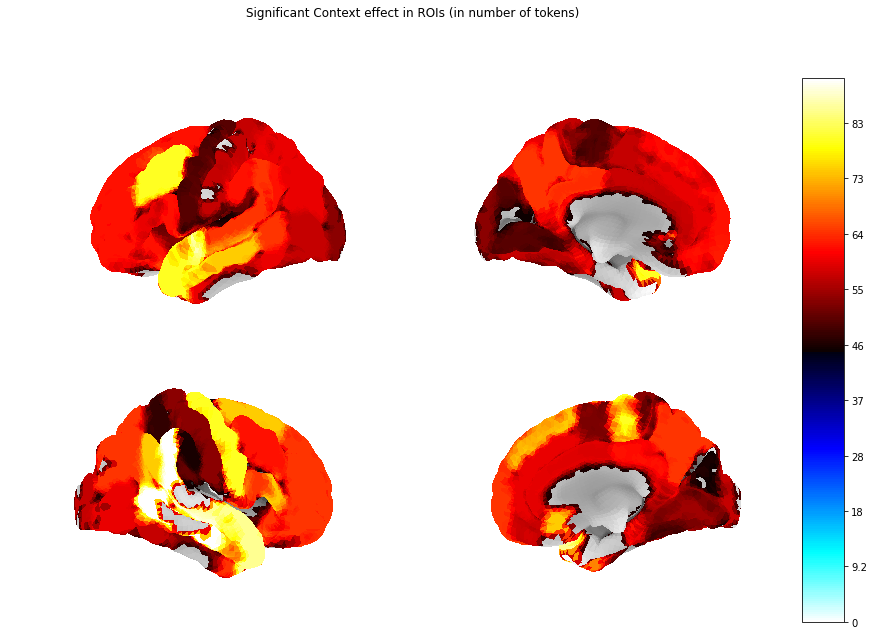

100%|██████████| 97/97 [01:26<00:00,  1.12it/s]


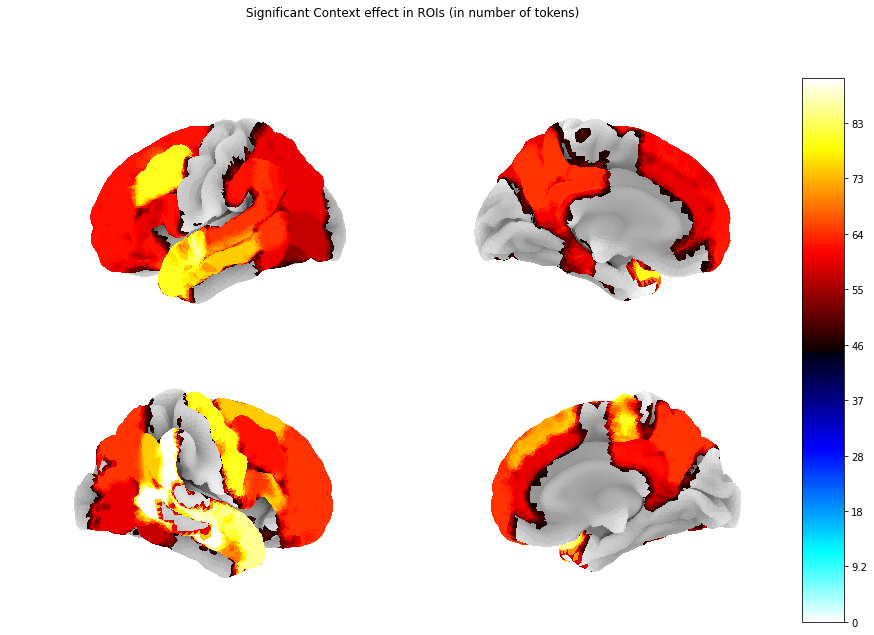

100%|██████████| 97/97 [01:25<00:00,  1.14it/s]


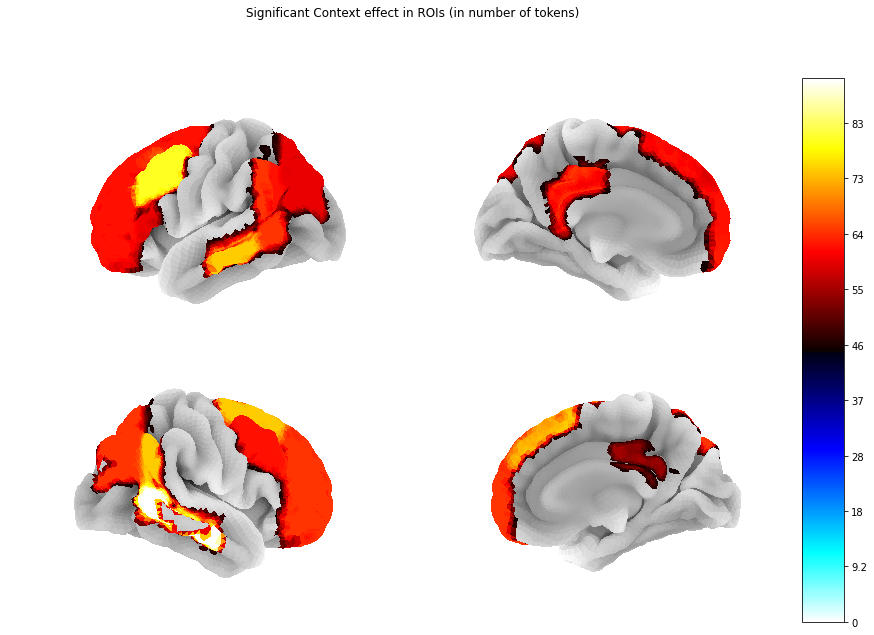

100%|██████████| 97/97 [01:29<00:00,  1.09it/s]


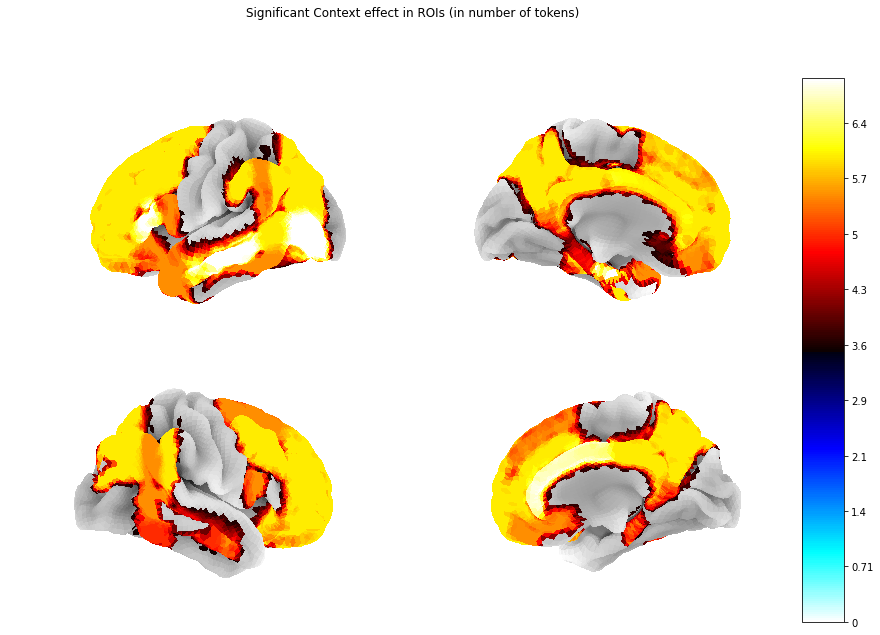

100%|██████████| 97/97 [01:27<00:00,  1.11it/s]


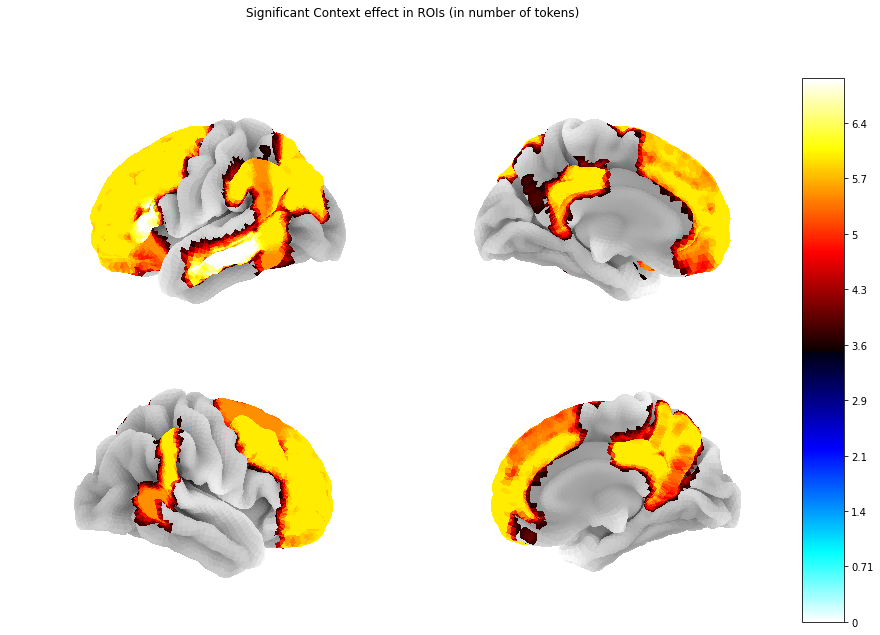

100%|██████████| 97/97 [01:24<00:00,  1.15it/s]


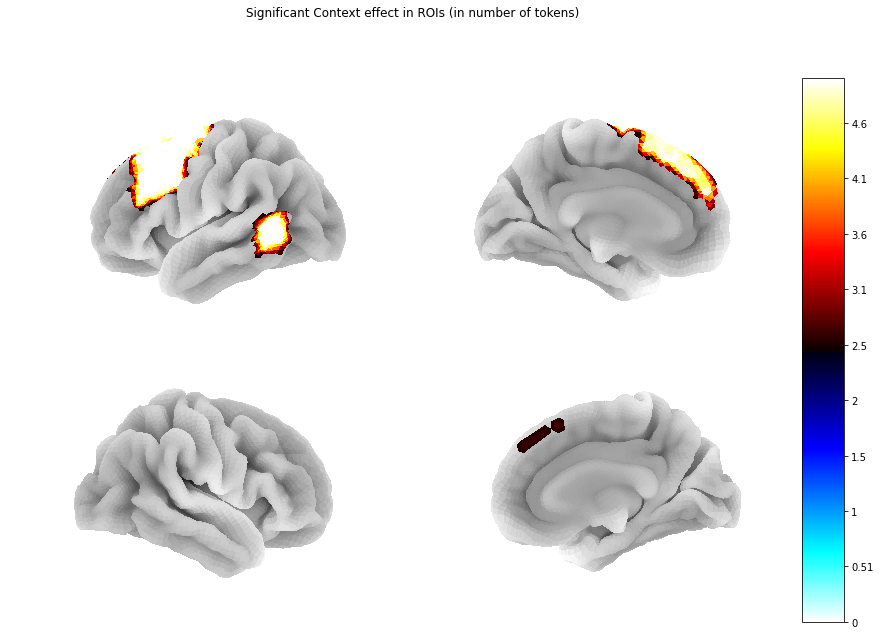

In [554]:
model_names = ['gpt2_factor_0', 'gpt2_factor_1', 'gpt2_factor_2', 'lstm_factor_0', 'lstm_factor_1', 'lstm_factor_2']
for index, context_sizes in enumerate(context_sizes_gpt2_list + context_sizes_lstm_list):
    model_name = model_names[index]
    filtered_sizes = [item[0] for item in context_sizes if item is not None]
    new_img_diff = nilearn.image.new_img_like(atlas_maps, np.stack([np.zeros((109, 91)) for i in range(91)], axis=0))
    for index_mask in tqdm(range(len(labels))):
        value = context_sizes[index_mask] if context_sizes[index_mask] is not None else 0
        if index_mask == 0:
            value = 0

        mask = math_img('img=={}'.format(index_mask), img=atlas_maps)

        #mask_ = math_img('img * {}'.format(np.sqrt(np.abs(d[index_mask]**2 - mean_values[index]**2))), img=mask)
        mask_ = math_img('img * {}'.format(value), img=mask)
        new_img_diff = math_img("img1 + img2", img1=new_img_diff, img2=mask_)


    if 'gpt2' in model_name:
        mask_img=os.path.join(ALL_MASKS_PATH, 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz')
    elif 'lstm' in model_name:
        mask_img=os.path.join(ALL_MASKS_PATH, 'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-inf_wiki-kristina_english_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz')
    elif 'bert' in model_name:
        mask_img=os.path.join(ALL_MASKS_PATH, 'bert-base-uncased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_300_significant-voxels.nii.gz')    
        
    multi_plot(
        data=new_img_diff, 
        mask=mask_img,
        plot_name='significant_context_effect_in_number_of_tokens_' + model_name, 
        saving_path='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/raw_figures/',
        return_plot=True, 
        inflated=False,
        suptitle='Significant Context effect in ROIs (in number of tokens)',
        vmax=np.max(filtered_sizes),
        vmin=0,
        **kwargs)
    #multi_plot(
    #    data=new_img_diff, 
    #    #mask=os.path.join(ALL_MASKS_PATH, 'bert-base-uncased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
    #    mask=os.path.join(ALL_MASKS_PATH, 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
    #    #mask=os.path.join(ALL_MASKS_PATH, 'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-inf_wiki-kristina_english_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
    #    plot_name='diff_based', 
    #    saving_path=None, 
    #    return_plot=True, 
    #    inflated=False,
    #    suptitle='Significant Context effect in ROIs (in number of tokens)',
    #    vmax=float(t),
    #    vmin=0,
    #    categorical_values=True,
    #    **kwargs)

In [ ]:
new_img_diff = nilearn.image.new_img_like(atlas_maps, np.stack([np.zeros((109, 91)) for i in range(91)], axis=0))
for index_mask in tqdm(range(len(labels))):
    value = context_sizes_lstm[index_mask] if context_sizes_lstm[index_mask] is not None else 0
    if index_mask == 0:
        value = 0

    mask = math_img('img=={}'.format(index_mask), img=atlas_maps)

    #mask_ = math_img('img * {}'.format(np.sqrt(np.abs(d[index_mask]**2 - mean_values[index]**2))), img=mask)
    mask_ = math_img('img * {}'.format(value), img=mask)
    new_img_diff = math_img("img1 + img2", img1=new_img_diff, img2=mask_)


#plt.hist(context_sizes_lstm[context_sizes_lstm is not None])
#plt.show()

t = input()
multi_plot(
    data=new_img_diff, 
    #mask=os.path.join(ALL_MASKS_PATH, 'bert-base-uncased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
    mask=os.path.join(ALL_MASKS_PATH, 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
    #mask=os.path.join(ALL_MASKS_PATH, 'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-inf_wiki-kristina_english_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
    plot_name='diff_based', 
    saving_path=None, 
    return_plot=True, 
    inflated=False,
    suptitle='Context effect in ROIs (based on difference)',
    vmax=float(t),
    **kwargs)
multi_plot(
    data=new_img_diff, 
    #mask=os.path.join(ALL_MASKS_PATH, 'bert-base-uncased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
    mask=os.path.join(ALL_MASKS_PATH, 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
    #mask=os.path.join(ALL_MASKS_PATH, 'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-inf_wiki-kristina_english_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
    plot_name='diff_based', 
    saving_path=None, 
    return_plot=True, 
    inflated=False,
    suptitle='Significant Context effect in ROIs (in number of tokens)',
    vmax=float(t),
    vmin=0,
    categorical_values=True,
    **kwargs)

In [ ]:
#plot_estimate_information(
#    estimate_maps_lstm_scaled, 
#    white_listed_indexes, 
#    labels,
#    model_type='lstm_scaled',
#    number_slopes=2, 
#    names=['xHat', 'yHat', 'my_slopes', 'beta', 'fit_breaks', 'se', 'Rsquared', 'R2values'],
#    show_plot=True
#)

plot_estimate_information(
    estimate_maps_bert_scaled, 
    white_listed_indexes, 
    labels,
    model_type='bert_scaled',
    number_slopes=2, 
    names=['xHat', 'yHat', 'my_slopes', 'beta', 'fit_breaks', 'se', 'Rsquared', 'R2values'],
    show_plot=False
)

plot_estimate_information(
    estimate_maps_gpt2_scaled, 
    white_listed_indexes, 
    labels,
    model_type='gpt2_scaled',
    number_slopes=2, 
    names=['xHat', 'yHat', 'my_slopes', 'beta', 'fit_breaks', 'se', 'Rsquared', 'R2values'],
    show_plot=False
)



In [26]:
### BERT ###
Y_bert = median_bert[:, 1:22]
X_bert = np.array([1, 2, 3, 4, 5, 7, 10, 12, 15, 17, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, #125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400
])


#Y_bert_future = median[:, 52:64] - median[:, 12]
#X_bert_future = np.array([1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100])


In [27]:
### GPT-2 ###
Y_gpt2 = median_gpt2[:, :21]
X_gpt2 = np.array([
    1, 2, 3, 4, 5, 7, 10, 12, 15, 17, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, #125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400
])


In [28]:
### LSTM ###
# median[:, :12], median[:, 13:25], median[:, 26:38], median[:, 39:51], median[:, 52:64]]:
#[1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 1000 #pre-context, [:13]
Y_lstm = median_lstm[:, :-4]
X_lstm = np.array([
    1, 2, 3, 4, 5, 7, 10, 12, 15, 17, 20, 25, 30#, 35, 40, 50 #, 400
])


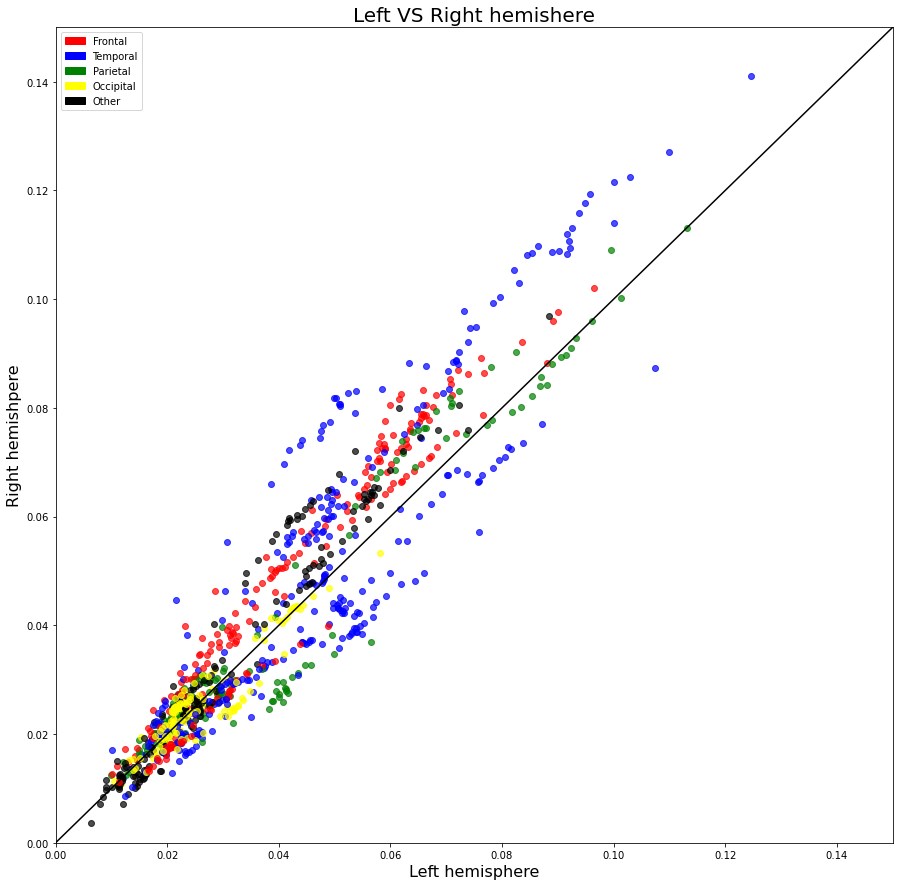

In [471]:
fig = plt.figure(figsize=(15,15))
x_limit = (0, 0.15)
y_limit = (0, 0.15)

for index, region in enumerate(labels[1::2]):
    if region in Frontal:
        c = 'red'
    elif region in Temporal:
        c = 'blue'
    elif region in Parietal:
        c = 'green'
    elif region in Occipital:
        c = 'yellow'
    elif region in Other:
        c = 'black'
    plt.scatter(a[index], b[index], c=c,  alpha=0.7)

red_patch = mpatches.Patch(color='red', label='Frontal')
blue_patch = mpatches.Patch(color='blue', label='Temporal')
green_patch = mpatches.Patch(color='green', label='Parietal')
yellow_patch = mpatches.Patch(color='yellow', label='Occipital')
black_patch = mpatches.Patch(color='black', label='Other')

plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch, black_patch])
plt.xlim(x_limit)
plt.ylim(y_limit)
plt.ylabel('Right hemishpere', fontsize=16)
plt.xlabel('Left hemisphere', fontsize=16)
plt.plot( x_limit,y_limit, c='black' )
plt.title('Left VS Right hemishere', fontsize=20)
plt.show()

In [749]:
t_tests, pvalues = get_t_test(maps_lstm, method='median')

  0%|          | 0/97 [00:00<?, ?it/s]

	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


  0%|          | 0/97 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 97/97 [00:52<00:00,  1.85it/s]

		-->Done


In [750]:
np.save('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/pvalues_{}.npy'.format('median_lstm'), pvalues)
np.save('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/t_tests_{}.npy'.format('median_lstm'), t_tests)


In [193]:
name = 'median_gpt2_pre-20_tokens'
t_tests = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/t_tests_{}.npy'.format(name))
pvalues = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/pvalues_{}.npy'.format(name))


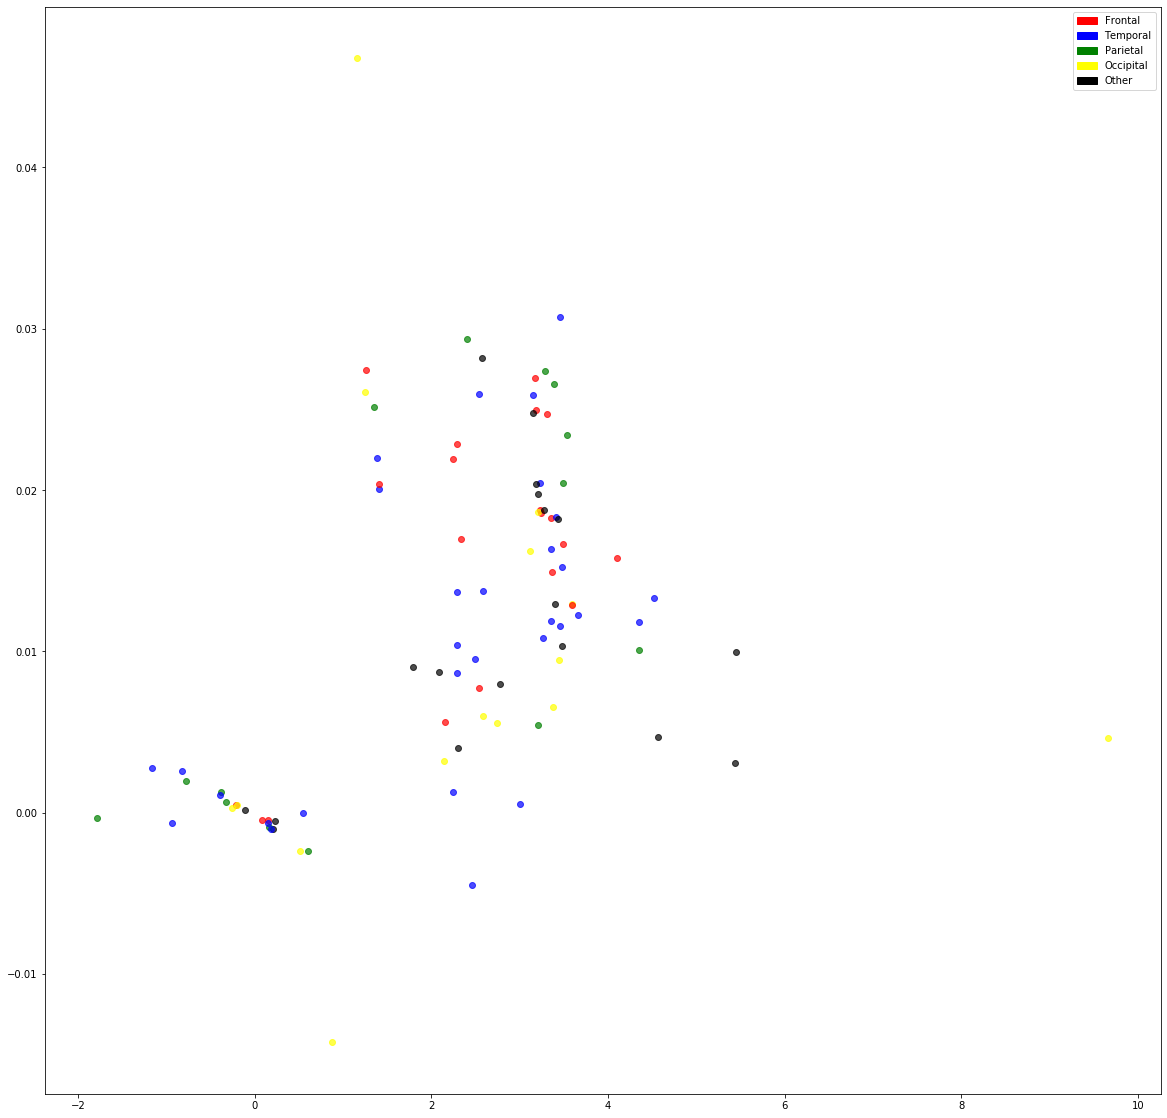

In [55]:
ab, b = list(zip(*args_lstm))
plt.close('all')

fig = plt.figure(figsize=(20,20))

for index, region in enumerate(labels):
    if region in Frontal:
        c = 'red'
    elif region in Temporal:
        c = 'blue'
    elif region in Parietal:
        c = 'green'
    elif region in Occipital:
        c = 'yellow'
    elif region in Other:
        c = 'black'
    #plt.text(b[index], ab[index], labels[index], c=c,  fontsize=12)
    plt.scatter(b[index], ab[index],  c=c,  alpha=0.7)

red_patch = mpatches.Patch(color='red', label='Frontal')
blue_patch = mpatches.Patch(color='blue', label='Temporal')
green_patch = mpatches.Patch(color='green', label='Parietal')
yellow_patch = mpatches.Patch(color='yellow', label='Occipital')
black_patch = mpatches.Patch(color='black', label='Other')

plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch, black_patch])
#plt.xlim(x_limit)
#plt.ylim(y_limit)
#plt.ylabel('Right hemishpere', fontsize=16)
#plt.xlabel('Left hemisphere', fontsize=16)
#plt.plot( x_limit,y_limit, c='black' )
#plt.tight_layout()
#plt.title('Left VS Right hemishere', fontsize=20)
plt.show()

In [ ]:
for d in zip(*err_lstm):
    new_img_diff = nilearn.image.new_img_like(atlas_maps, np.stack([np.zeros((109, 91)) for i in range(91)], axis=0))
    for index_mask in tqdm(range(len(labels))):
        if index_mask in np.array([ 3, 13, 14, 18, 28, 34, 36, 46, 48, 51, 52, 64, 68, 72, 74, 76, 82, 85, 86, 90, 91, 92, 93, 95]):
            value = 0
        else:
            value = d[index_mask]

        mask = math_img('img=={}'.format(index_mask), img=atlas_maps)

        #mask_ = math_img('img * {}'.format(np.sqrt(np.abs(d[index_mask]**2 - mean_values[index]**2))), img=mask)
        mask_ = math_img('img * {}'.format(value), img=mask)
        new_img_diff = math_img("img1 + img2", img1=new_img_diff, img2=mask_)


    plt.hist(d, bins=50)
    plt.show()

    t = input()
    multi_plot(
        data=new_img_diff, 
        #mask=os.path.join(ALL_MASKS_PATH, 'bert-base-uncased_pre-2_1_post-0_norm-None_norm-inf_temporal-shifting-0_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
        #mask=os.path.join(ALL_MASKS_PATH, 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
        mask=os.path.join(ALL_MASKS_PATH, 'LSTM_embedding-size-600_nhid-300_nlayers-1_dropout-02_memory-size-inf_wiki-kristina_english_{}_hidden-all-layers_pca_300_significant-voxels.nii.gz'),
        plot_name='diff_based', 
        saving_path=None, 
        return_plot=True, 
        inflated=False,
        suptitle='Context effect in ROIs (based on difference)',
        vmax=float(t),
        **kwargs)

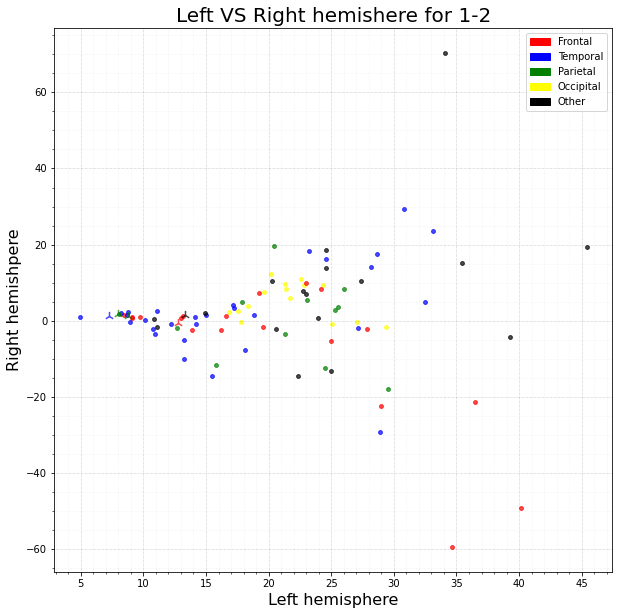

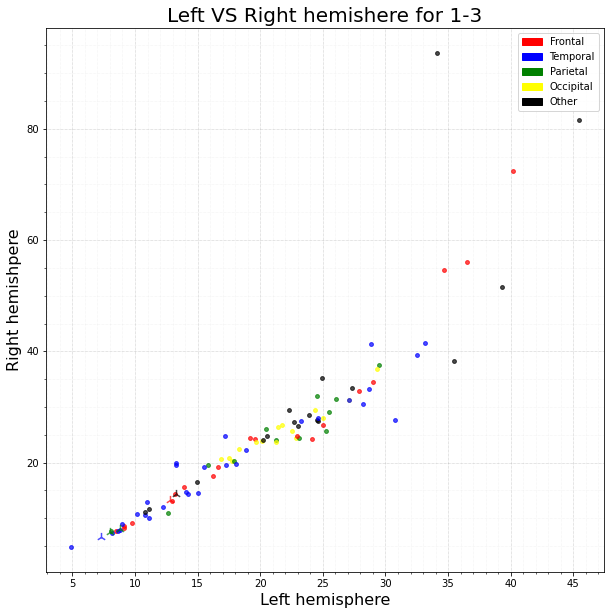

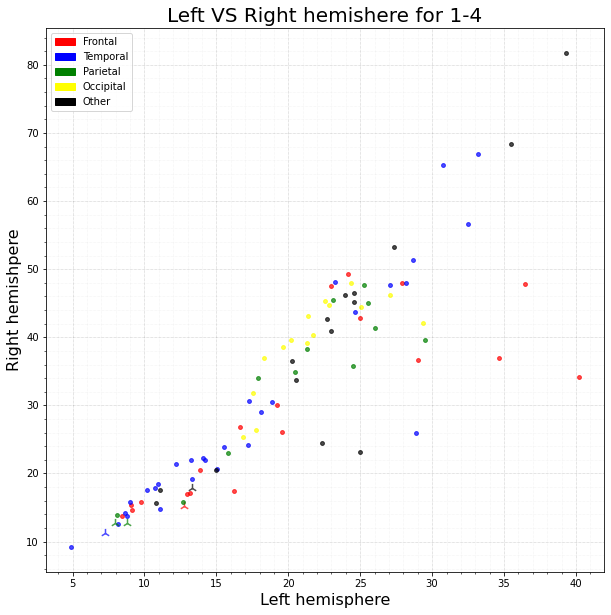

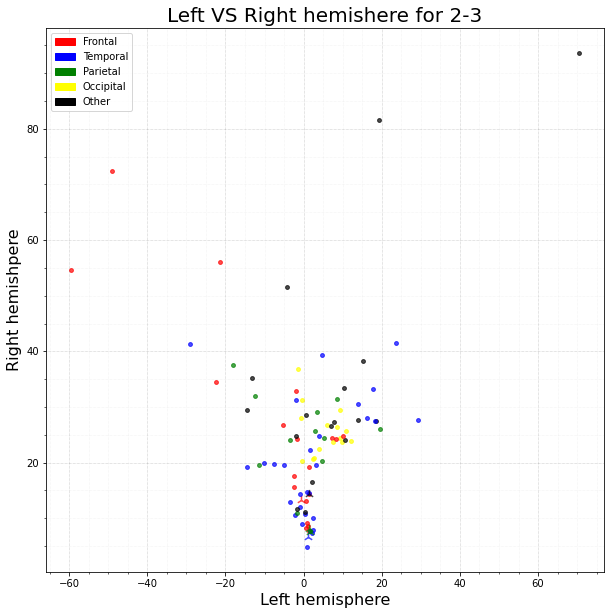

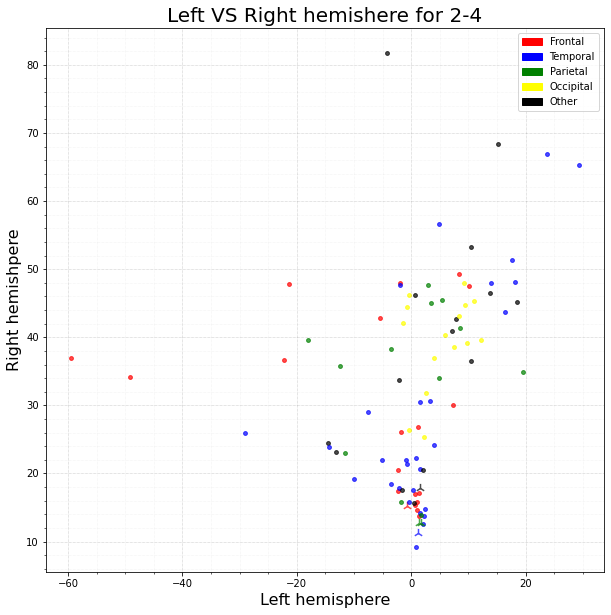

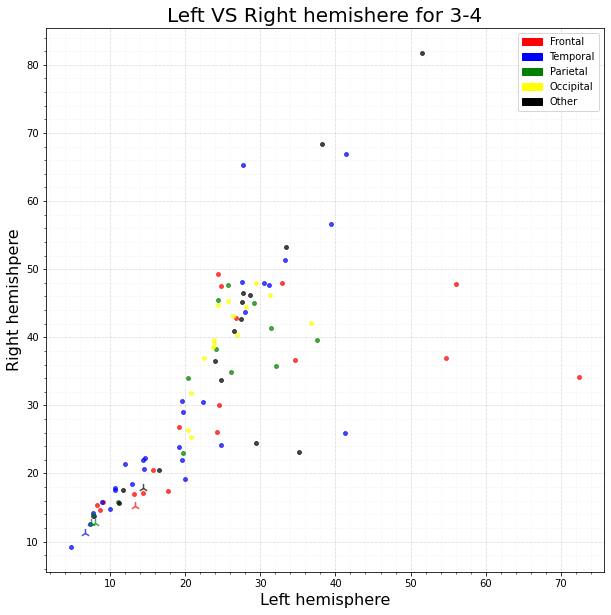

In [73]:
from itertools import combinations

coords_list = list(zip(*args))
names = ['1-2', '1-3', '1-4', '2-3', '2-4', '3-4']
x_limit = None
y_limit = None

for i, coords in enumerate(combinations(coords_list, 2)):
    fig = plt.figure(figsize=(10,10))
    for index, region in enumerate(labels):
        if region in Frontal:
            c = 'red'
        elif region in Temporal:
            c = 'blue'
        elif region in Parietal:
            c = 'green'
        elif region in Occipital:
            c = 'yellow'
        elif region in Other:
            c = 'black'
        if index in [59, 41, 42, 19, 9]:
            marker = "2"
            s = 85
        else:
            marker = '.'
            s = 60
        if coords[0][index] < 100 and coords[1][index] < 100:
            plt.scatter(coords[0][index], coords[1][index], c=c,  alpha=0.7, marker=marker, s=s)

    red_patch = mpatches.Patch(color='red', label='Frontal')
    blue_patch = mpatches.Patch(color='blue', label='Temporal')
    green_patch = mpatches.Patch(color='green', label='Parietal')
    yellow_patch = mpatches.Patch(color='yellow', label='Occipital')
    black_patch = mpatches.Patch(color='black', label='Other')

    plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch, black_patch])
    plt.xlim(x_limit)
    plt.ylim(y_limit)
    plt.ylabel('Right hemishpere', fontsize=16)
    plt.xlabel('Left hemisphere', fontsize=16)
    plt.minorticks_on()
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='x')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='x')
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='y')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='y')
    plt.title('Left VS Right hemishere for {}'.format(names[i]), fontsize=20)
    plt.show()

In [65]:
for i in ['Left Cingulate Gyrus, posterior division',
'Left Angular Gyrus',
'Right Angular Gyrus',
'Left Superior Temporal Gyrus, posterior division',
'Left Inferior Frontal Gyrus, pars triangularis',]:
    print(labels.index(i))


59
41
42
19
9


In [527]:
rois_filter = [
    #'Left Superior Frontal Gyrus',
    'Left Inferior Frontal Gyrus, pars triangularis',
    #'Right Inferior Frontal Gyrus, pars triangularis',
    'Left Inferior Frontal Gyrus, pars opercularis',
    #'Right Inferior Frontal Gyrus, pars opercularis',
    'Left Temporal Pole',
    #'Left Superior Temporal Gyrus, posterior division',
    'Left Supramarginal Gyrus, posterior division',
    'Left Angular Gyrus',
    #'Left Paracingulate Gyrus', 
    'Left Cingulate Gyrus, posterior division',
    #'Left Precuneous Cortex',
    #"Left Heschl's Gyrus (includes H1 and H2)",
]

In [342]:
path = os.path.join('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english', 'third_quartile_{}.npy'.format('gpt2_pre-20_tokens'))
np.save(path, third_quartile)


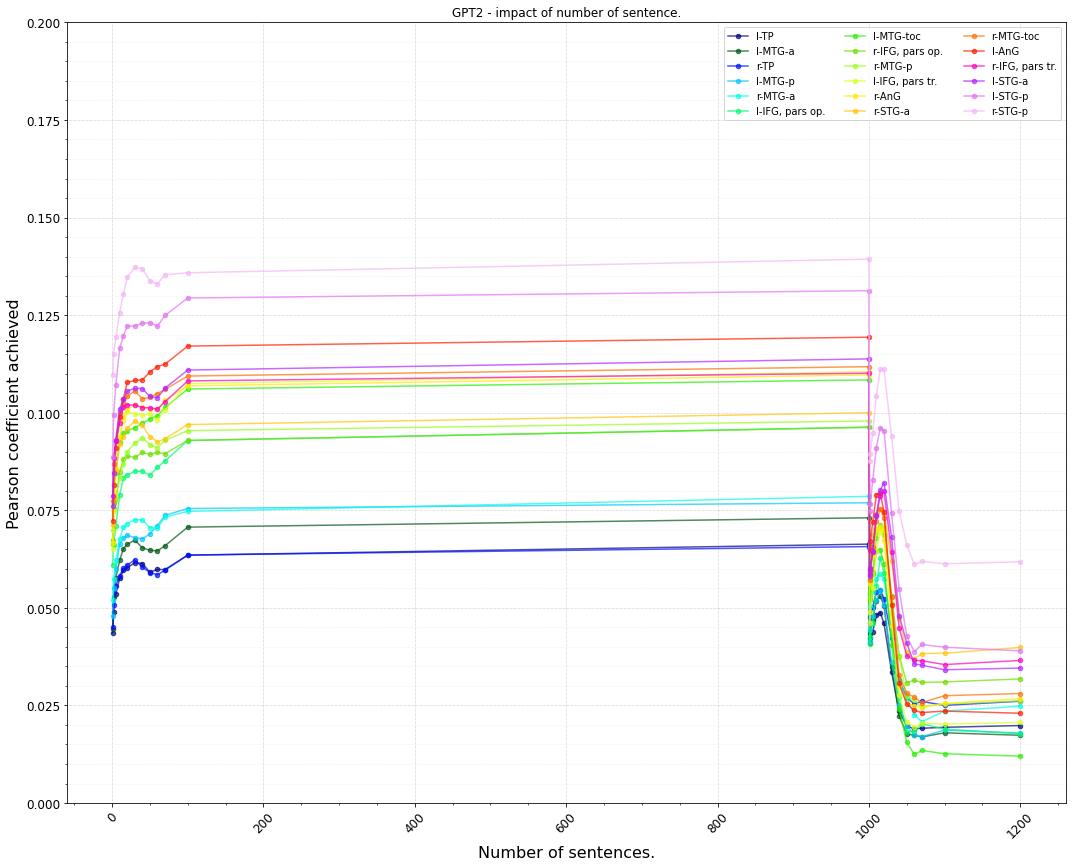

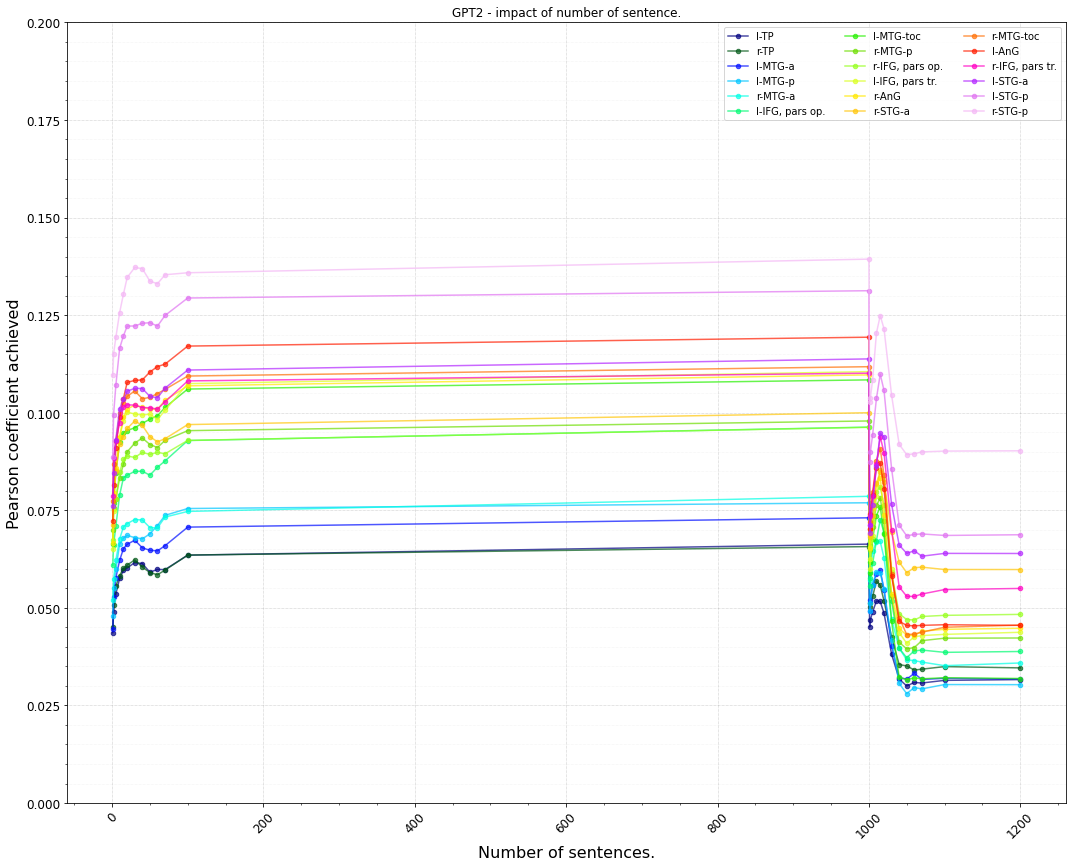

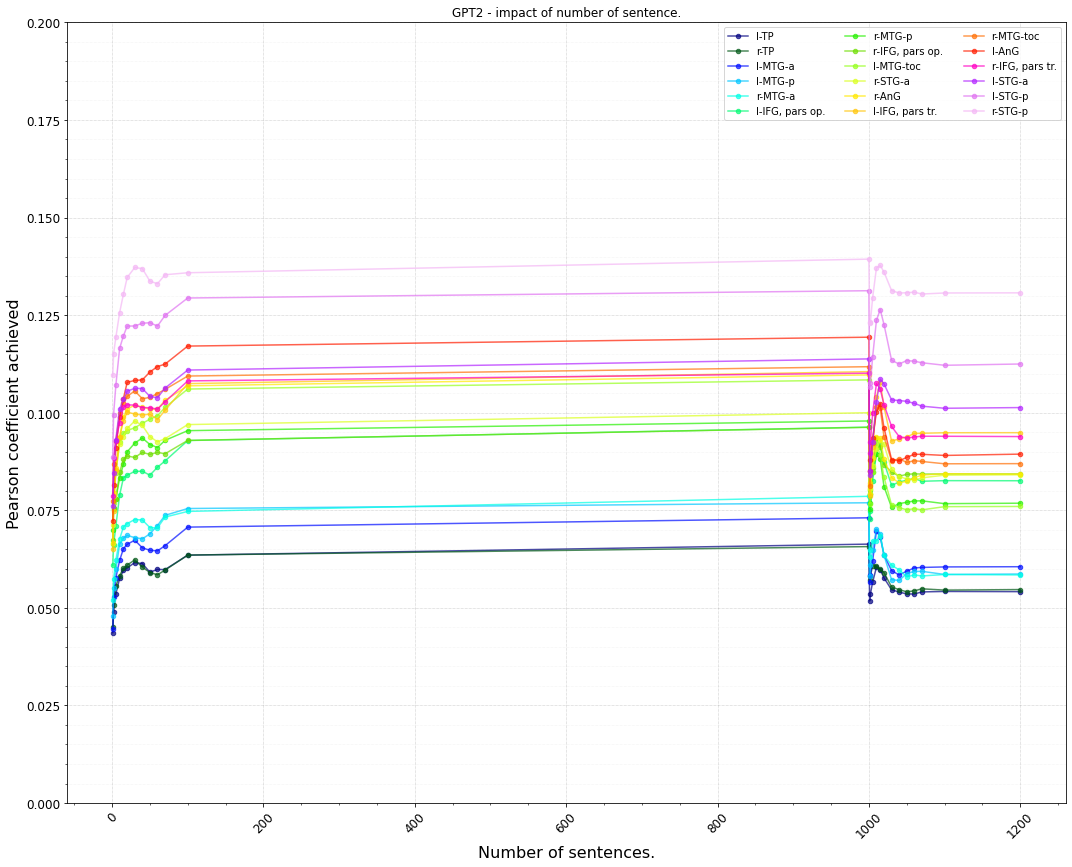

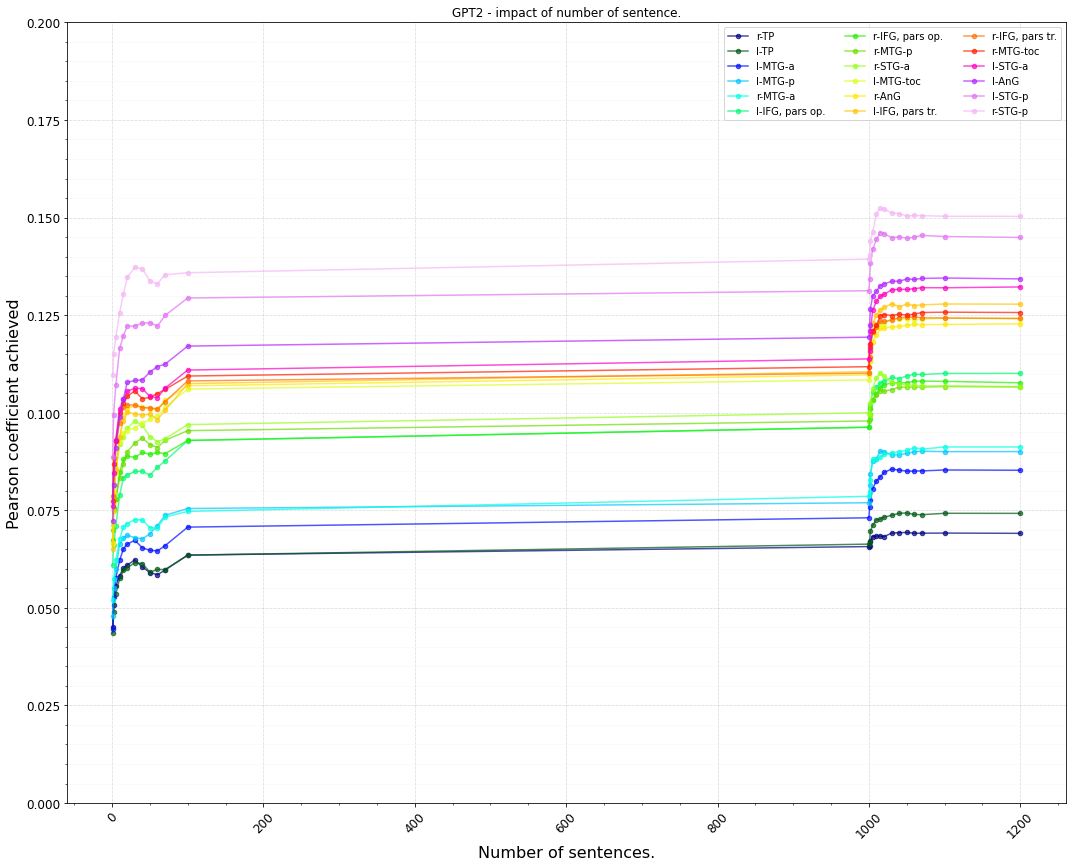

In [266]:
for d in [median[:, 13:26], median[:, 26:39], median[:, 39:52], median[:, 52:65]]:
    reporting.clever_plot(
            np.hstack([median[:, :13], d]), 
            labels, 
            [1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 1000 ,#pre-context, [:13]
             1001, 1002, 1005, 1010, 1015, 1020, 1030, 1040, 1050, 1060, 1070, 1100, 1200
             #1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 1000 # 3 post-context sentence and all pre-context included - [13:26]
             #1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 1000 # 2 post-context sentence and all pre-context included - [26:39]
             #1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 1000 # 1 post-context sentence and all pre-context included - [39:52]
             #1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 1000 # 0 post-context sentence and all pre-context included - [52:65]
            ], #legend_names
            save_folder=None, 
            roi_filter=load_syntactic_roi(),
            analysis_name='Pearson_third-quartile_language-roi', 
            ylabel='Pearson coefficient achieved',
            xlabel='Number of sentences.',
            plot_name='Effect with 1 sentence.',
            figsize=(15,12),
            percentage=False,
            rotation=45,
            title='GPT2 - impact of number of sentence.',
            y_limit=(0, 0.2),
            #x_limit=(0,100)
        )
#for d in [median[:, 1:13]-median[:, :12], median[:, 14:26] - median[:, 13:25], median[:, 27:39]-median[:, 26:38]]:
#    reporting.clever_plot(
#            d, 
#            labels, 
#            [ 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 1000 #pre-context, [:13]
#             #1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 1000 # 3 post-context sentence and all pre-context included - [13:26]
#             #1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 1000 # 2 post-context sentence and all pre-context included - [26:39]
#             #1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 1000 # 1 post-context sentence and all pre-context included - [39:52]
#             #1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 1000 # 0 post-context sentence and all pre-context included - [52:65]
#            ], #legend_names
#            save_folder=None, 
#            roi_filter=rois_filter,
#            analysis_name='Pearson_third-quartile_language-roi', 
#            ylabel='Pearson coefficient achieved',
#            xlabel='Number of sentences.',
#            plot_name='Effect with 1 sentence.',
#            figsize=(15,12),
#            percentage=False,
#            rotation=45,
#            title='GPT2 - impact of number of sentence.',
#            y_limit=None,
#            x_limit=(0,100)
#        )

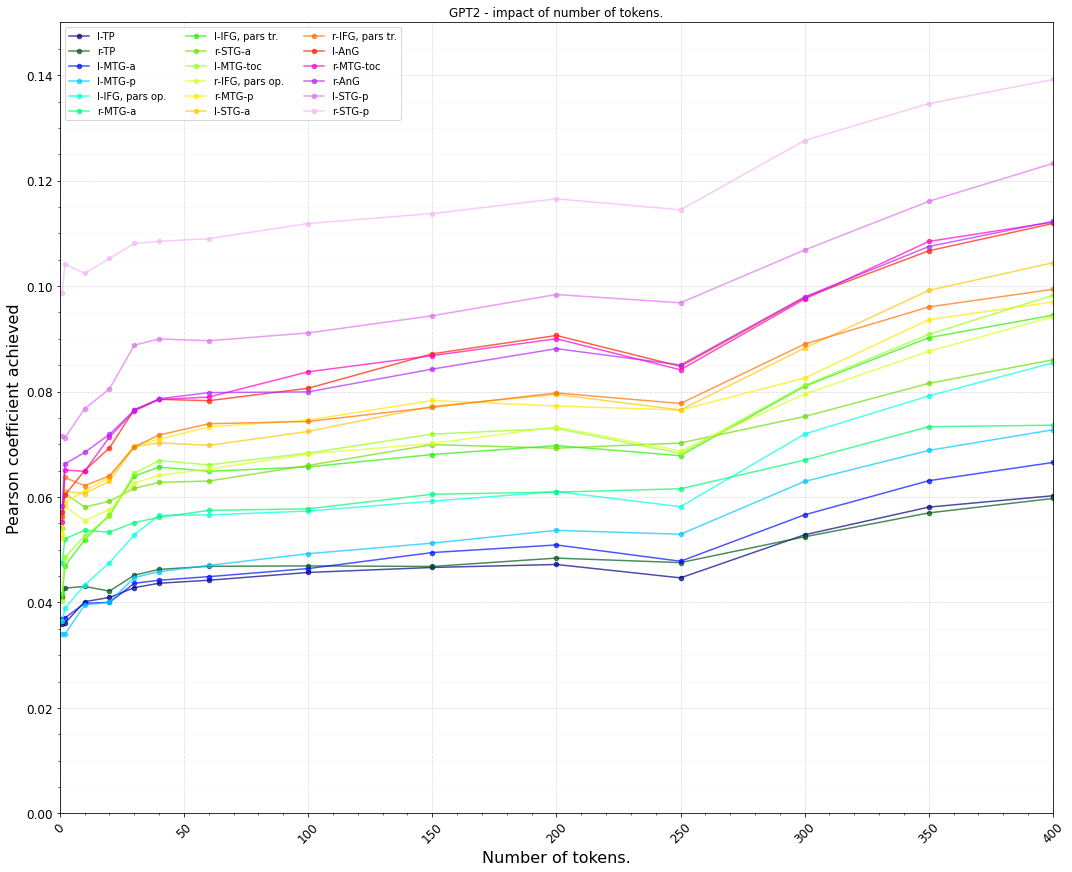

In [529]:
reporting.clever_plot(
        median, 
        labels, 
        [1, 2, 10, 20, 30, 40, 60, 100, 150, 200, 250, 300, 350, 400],
        #[1,2,3,4,5,7,10,12,15,17,20,25,30,35,40,50,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400], #legend_names
        save_folder=None, 
        roi_filter=load_syntactic_roi(),
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Number of tokens.',
        plot_name='Effect with attention mask on tokens.',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='GPT2 - impact of number of tokens.',
        y_limit=(0, 0.15),
        x_limit=(0,400)
    )

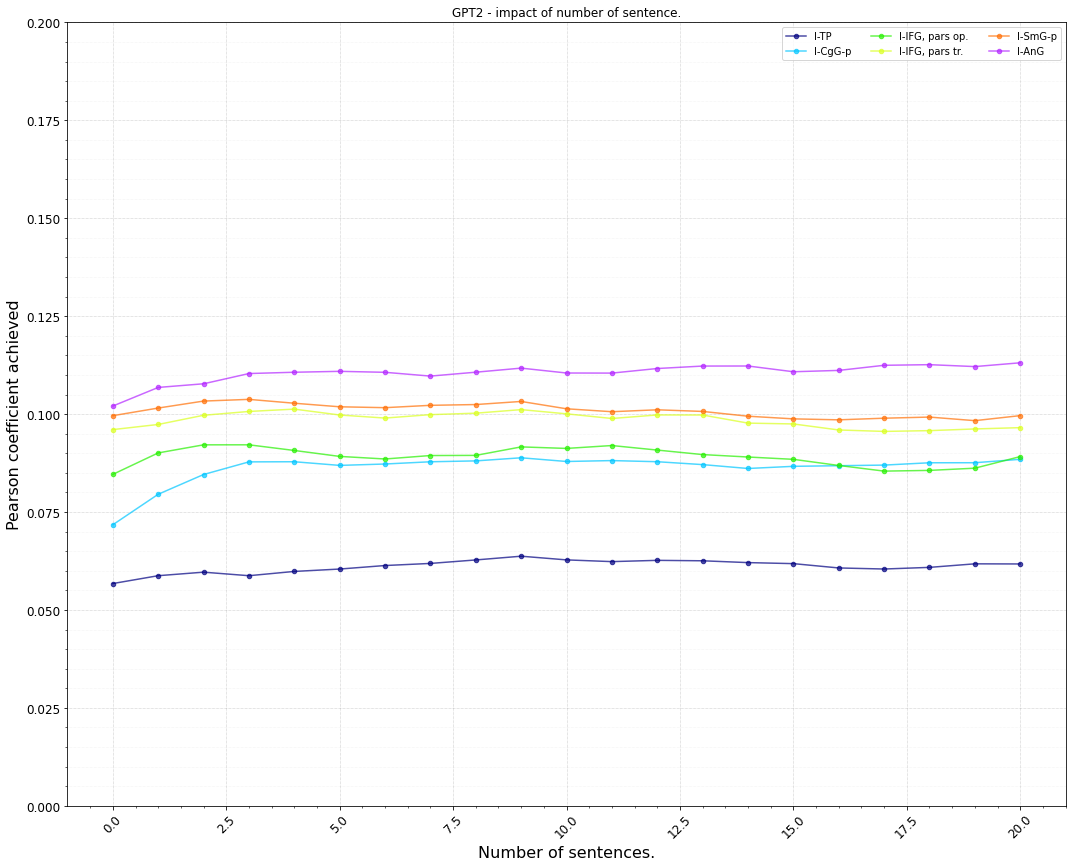

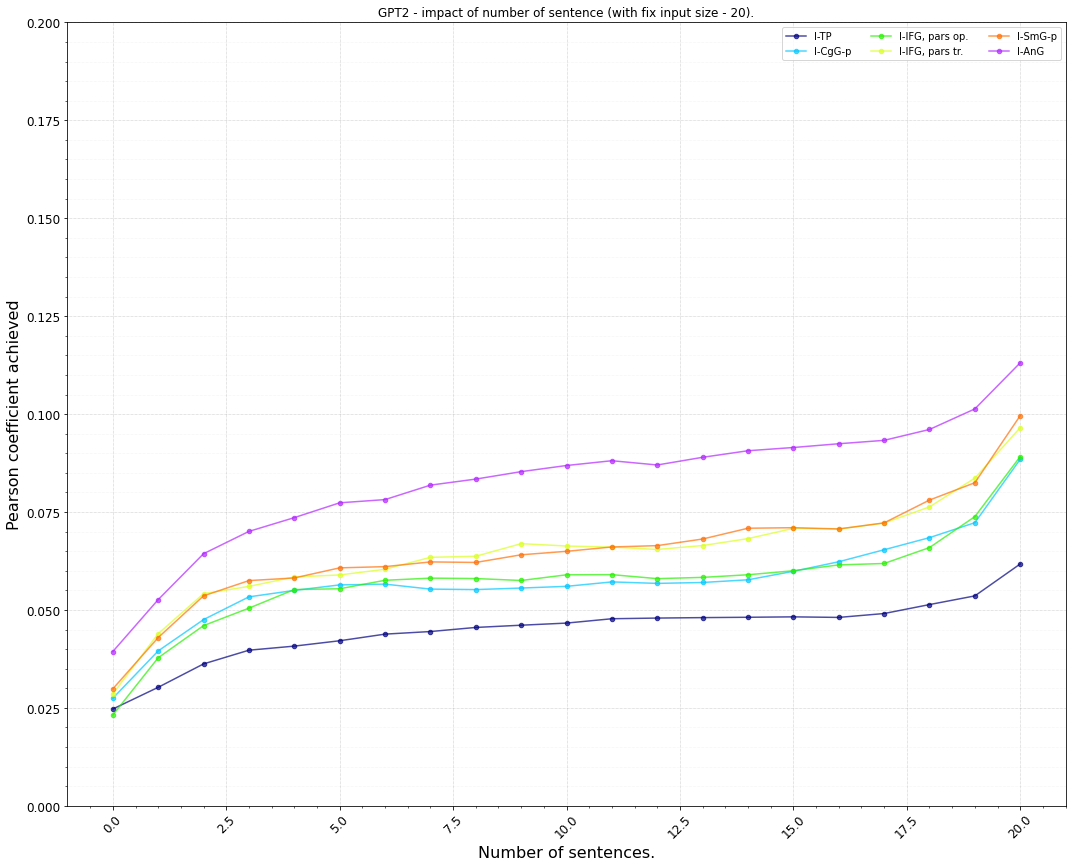

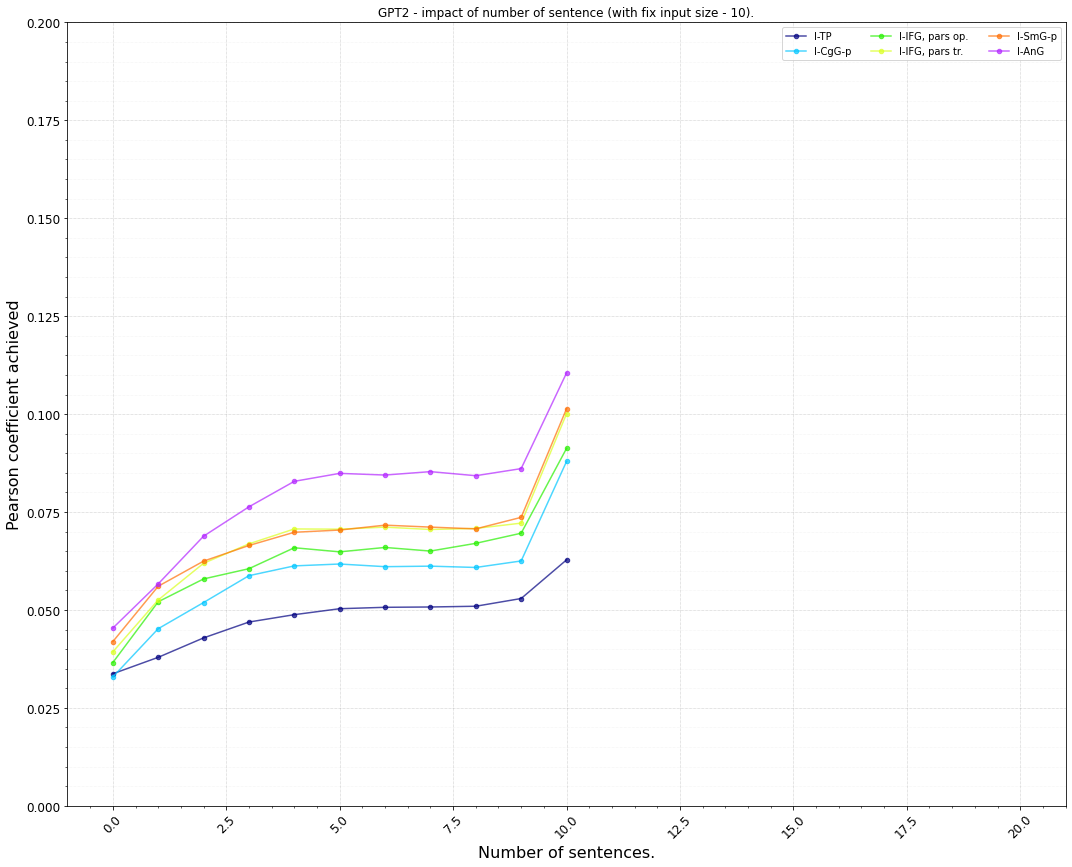

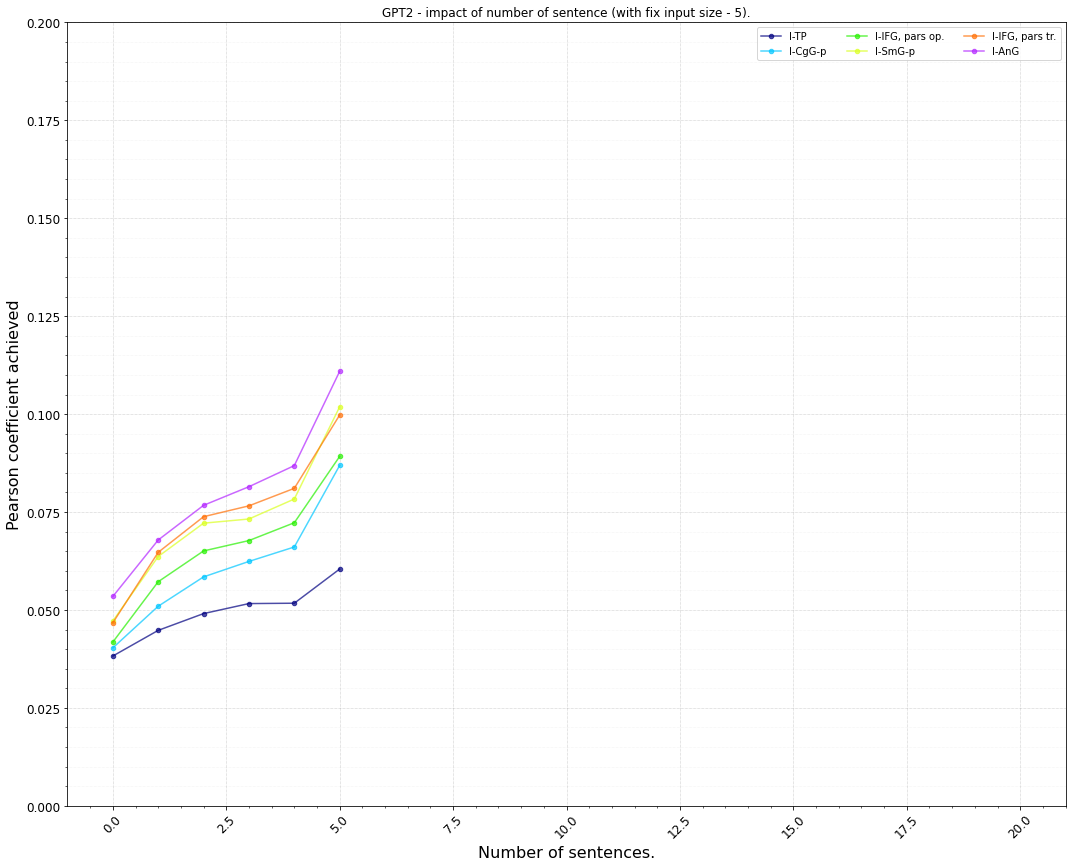

In [159]:
third_quartile_gpt2_pre = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/third_quartile_gpt2_pre.npy')
third_quartile_gpt2_pre_5_1_stop_sent = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/third_quartile_gpt2_pre-5_1_stop-sent.npy')
third_quartile_gpt2_pre_20_1_stop_sent = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/third_quartile_gpt2_pre-20_1_stop-sent.npy')
third_quartile_gpt2_pre_10_1_stop_sent = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/third_quartile_gpt2_pre-10_1_stop-sent.npy')
median_gpt2_pre = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/median_gpt2_pre.npy')
median_gpt2_pre_5_1_stop_sent = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/median_gpt2_pre-5_1_stop-sent.npy')
median_gpt2_pre_20_1_stop_sent = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/median_gpt2_pre-20_1_stop-sent.npy')
median_gpt2_pre_10_1_stop_sent = np.load('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/context/english/median_gpt2_pre-10_1_stop-sent.npy')

reporting.clever_plot(
        median_gpt2_pre, 
        labels, 
        np.arange(21), #legend_names
        save_folder=None, 
        roi_filter=rois_filter,
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Number of sentences.',
        plot_name='Effect with 1 sentence.',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='GPT2 - impact of number of sentence.',
        y_limit=(0, 0.2),
        x_limit=(-1, 21)
    )
reporting.clever_plot(
        median_gpt2_pre_20_1_stop_sent, 
        labels, 
        np.arange(21), #legend_names
        save_folder=None, 
        roi_filter=rois_filter,
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Number of sentences.',
        plot_name='Effect with 1 sentence.',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='GPT2 - impact of number of sentence (with fix input size - 20).',
        y_limit=(0, 0.2),
        x_limit=(-1, 21)
    )
reporting.clever_plot(
        median_gpt2_pre_10_1_stop_sent, 
        labels, 
        np.arange(11), #legend_names
        save_folder=None, 
        roi_filter=rois_filter,
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Number of sentences.',
        plot_name='Effect with 1 sentence.',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='GPT2 - impact of number of sentence (with fix input size - 10).',
        y_limit=(0, 0.2),
        x_limit=(-1, 21)
    )
reporting.clever_plot(
        median_gpt2_pre_5_1_stop_sent, 
        labels, 
        np.arange(6), #legend_names
        save_folder=None, 
        roi_filter=rois_filter,
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Number of sentences.',
        plot_name='Effect with 1 sentence.',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='GPT2 - impact of number of sentence (with fix input size - 5).',
        y_limit=(0, 0.2),
        x_limit=(-1, 21)
    )


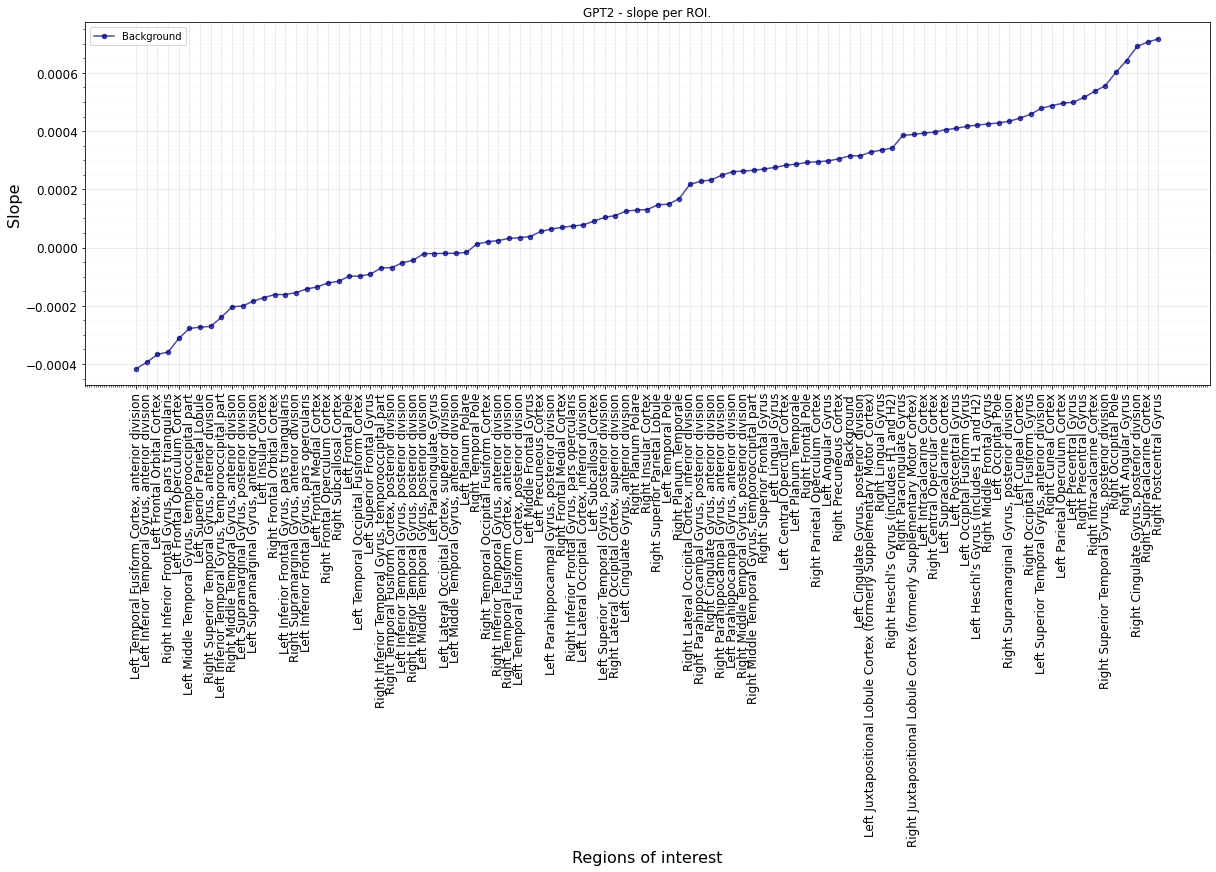

In [302]:
data = np.hstack(coefficients)
order = np.argsort(np.hstack(coefficients))
data = data[order]

reporting.clever_plot(
        data.reshape(1, -1), 
        labels, 
        np.array(labels)[order], #legend_names
        save_folder=None, 
        roi_filter=['Background'],
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Slope',
        xlabel='Regions of interest',
        plot_name='Effect with 1 sentence.',
        figsize=(17,12),
        percentage=False,
        rotation=90,
        title='GPT2 - slope per ROI.',

    )

In [ ]:

models_diff = [
    #(median[:, 19] - median[:, 0]).reshape(-1, 1),
    (median_gpt2_pre_20_1_stop_sent[:, 3] - median_gpt2_pre_20_1_stop_sent[:, 0]).reshape(-1, 1),
    (median_gpt2_pre_20_1_stop_sent[:, 5] - median_gpt2_pre_20_1_stop_sent[:, 0]).reshape(-1, 1),
    (median_gpt2_pre_20_1_stop_sent[:, 10] - median_gpt2_pre_20_1_stop_sent[:, 0]).reshape(-1, 1), 
    (median_gpt2_pre_5_1_stop_sent[:, -1] - median_gpt2_pre_5_1_stop_sent[:, 0]).reshape(-1, 1), 
    (median_gpt2_pre[:, 5] - median_gpt2_pre[:, 0]).reshape(-1, 1),
    (np.max(median_gpt2_pre, axis=1) - np.min(median_gpt2_pre, axis=1)).reshape(-1, 1),
    (median_lstm[:, 7] - median_lstm[:, 0]).reshape(-1, 1),
    (np.max(median_lstm, axis=1) - np.min(median, axis=1)).reshape(-1, 1),
         ]
models = [
    #median[:,:20],
    median_gpt2_pre_20_1_stop_sent[:, :3], 
    median_gpt2_pre_20_1_stop_sent[:, :5], 
    median_gpt2_pre_10_1_stop_sent[:, :10], 
    median_gpt2_pre_5_1_stop_sent, 
    median_gpt2_pre[:, :5],
    median_gpt2_pre,
    median_lstm[:,:7],
    median_lstm
]

names = [
    ('GPT-2 effect of tokens (up to 90 tokens)', 'GPT-2 effect of tokens (up to 90 tokens)'),
    ('GPT-2 effect of sentences (20 sentences of context + attention mask)', 'GPT-2 effect of sentences (20 sentences of context + attention mask)'),
    ('GPT-2 effect of sentences (10 sentences of context + attention mask)', 'GPT-2 effect of sentences (10 sentences of context + attention mask)'),
    ('GPT-2 effect of sentences (5 sentences of context + attention mask)', 'GPT-2 effect of sentences (5 sentences of context + attention mask)'),
    ('GPT-2 effect of sentences (varying input size)', 'GPT-2 effect of sentences (varying input size)'),
    ('GPT-2 effect of sentences (varying input size | max - min)', 'GPT-2 effect of sentences (5 sentences of context + attention mask)'),
    ('LSTM effect of words (up to 10 words)', 'LSTM effect of sentences (up to 10 words)'),
    ('LSTM effect of words (max - min)', 'LSTM effect of words'),
    
]

for index_model, model in enumerate(models_diff):
    atlas_maps, labels = reporting.load_atlas() # load harvard-oxford atlas named'cort-prob-2mm'
    data = atlas_maps.get_data()
    new_img_diff = nilearn.image.new_img_like(atlas_maps, np.stack([np.zeros((109, 91)) for i in range(91)], axis=0))
    new_img_slope = nilearn.image.new_img_like(atlas_maps, np.stack([np.zeros((109, 91)) for i in range(91)], axis=0))
    coefficients = []
    for index_mask in tqdm(range(len(labels))):
        lr = linear_model.LinearRegression()
        size = models[index_model].shape[-1]
        X = np.arange(size).reshape(-1,1)
        y = models[index_model][index_mask, :]
        lr.fit(X, y)
        coefficients.append(lr.coef_[0])
    
        mask = math_img('img=={}'.format(index_mask), img=atlas_maps)
        
        mask_ = math_img('img * {}'.format(model[index_mask, 0]), img=mask)
        new_img_diff = math_img("img1 + img2", img1=new_img_diff, img2=mask_)
        
        mask_ = math_img('img * {}'.format(lr.coef_[0]), img=mask)
        new_img_slope = math_img("img1 + img2", img1=new_img_slope, img2=mask_)
    
    print(names[index_model][0])
        
    multi_plot(
        data=new_img_diff, 
        mask=None,
        plot_name='diff_based', 
        saving_path=None, 
        return_plot=True, 
        inflated=False,
        suptitle='Context effect in ROIs (based on difference)',
        vmax=np.max(model),
        **kwargs)

    print(names[index_model][1])
    multi_plot(
        data=new_img_slope, 
        mask=None,
        plot_name='slope_based', 
        saving_path=None, 
        return_plot=True, 
        inflated=False,
        suptitle='Context effect in ROIs (based on slopes by LR)',
        vmax=np.max(coefficients),
        **kwargs)

In [516]:
import matplotlib
import seaborn as sns
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.colorbar import ColorbarBase
from matplotlib import colors
#Here we import internal nilearn functions, YOLO!
from nilearn._utils.niimg import _safe_get_data
from nilearn.plotting.img_plotting import _get_colorbar_and_data_ranges

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colorbar import ColorbarBase, make_axes


COLORS_PLUS = plt.cm.autumn(np.linspace(0., 1, 128))
COLORS_MINUS = plt.cm.winter(np.linspace(0, 1, 128))
COLORS = np.vstack((COLORS_MINUS, COLORS_PLUS[::-1]))
MYMAP = mcolors.LinearSegmentedColormap.from_list('my_colormap', COLORS)

def _draw_colorbar(colorbar_ax, vmax, vmin=None, offset=4.):
    our_cmap = plotting.cm.cold_hot
    nb_ticks = 5
    if vmin is None:
        vmin = -vmax
    #ticks = np.linspace(vmin, vmax, nb_ticks)
    bounds = np.linspace(vmin, vmax, our_cmap.N)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    #scalarMap = cmx.ScalarMappable(norm=norm, cmap=our_cmap)
    # some colormap hacking
    #cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
    #istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
    #istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
    #for i in range(istart, istop):
    #    cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    #our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

    ColorbarBase(
        colorbar_ax, norm=norm,  #ticks=ticks,
        orientation='vertical', cmap=our_cmap, boundaries=bounds,
        spacing='proportional', format='%.2g')
    #colorbar_ax.yaxis.tick_left()
    #tick_color = 'w'
    #for tick in colorbar_ax.yaxis.get_ticklabels():
    #    tick.set_color(tick_color)
    #colorbar_ax.yaxis.set_tick_params(width=0)

    
#fig, ax = plt.subplots()
#ax.scatter(np.random.random(100), np.random.random(100))
#ax.set_axis_off()
#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
#fig
#image = plt.imread(dic["filename"])
#    x0 = dic["annotations"][i]["x"]
#    y0 = dic["annotations"][i]["y"]
#    width = dic["annotations"][i]["width"]
#    height = dic["annotations"][i]["height"]
#    return image[y0:y0+height , x0:x0+width, :]

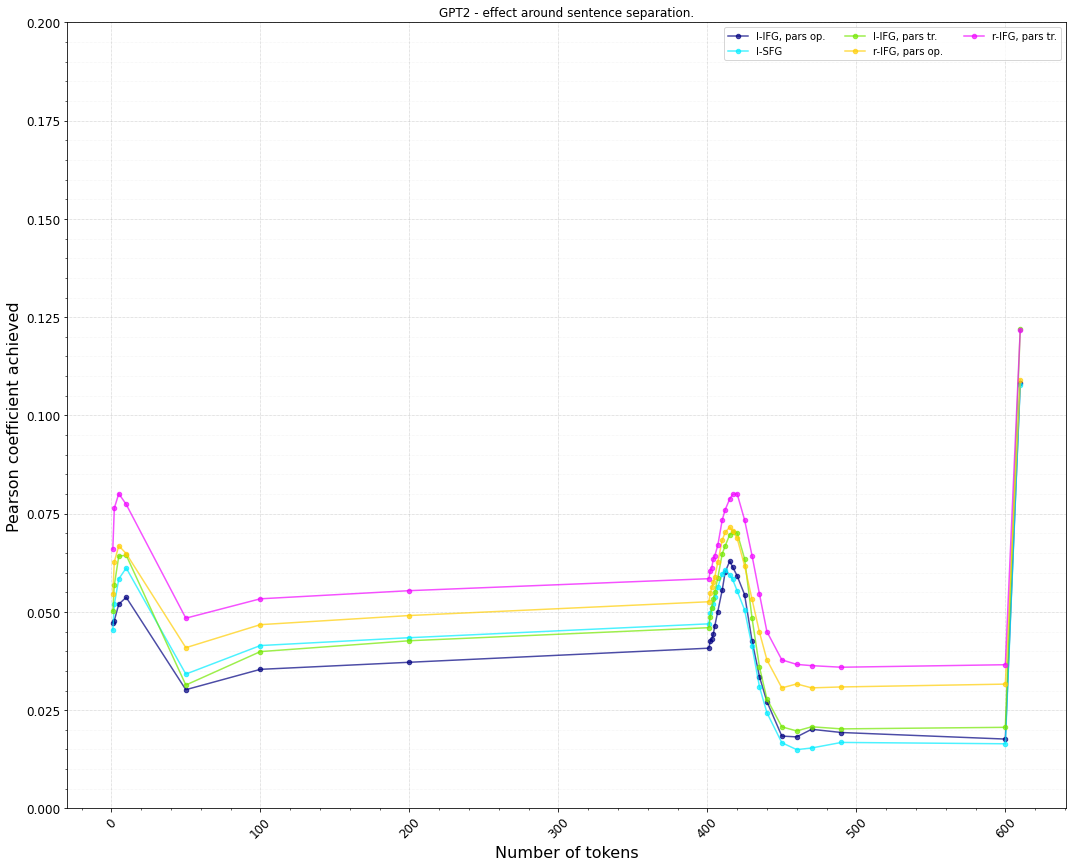

In [60]:
reporting.clever_plot(
        median, 
        labels, 
        np.array([1, 2, 5, 10, 50, 100, 200, 401, 402, 403, 404, 405, 407, 410, 412, 415, 417, 420, 425, 430, 435, 440, 450, 460, 470, 490, 600, 610]), #legend_names
        save_folder=None, 
        roi_filter=rois_filter,
        analysis_name='Pearson_third-quartile_language-roi', 
        ylabel='Pearson coefficient achieved',
        xlabel='Number of tokens',
        plot_name='Effect with 1 sentence.',
        figsize=(15,12),
        percentage=False,
        rotation=45,
        title='GPT2 - effect around sentence separation.',
        y_limit=(0, 0.2)
    )

In [ ]:
comparison = anova_comparison.copy()
for roi in tqdm(comparison['ROI'].unique()):
    mean_global = np.mean(comparison[comparison['ROI']==roi]['Pearson_coeff_3rd_quartile'].values)
    for subject in comparison['subject'].unique():
        tmp = mean_global - np.mean(comparison[(comparison['ROI']==roi) & (comparison['subject']==subject)]['Pearson_coeff_3rd_quartile'].values)
        comparison.loc[(comparison['ROI']==roi) & (comparison['subject']==subject),'Pearson_coeff_3rd_quartile'] += tmp



plt.figure(figsize=((25,25)))
sns.set(context='notebook', font_scale=1.2)
colors = ['r', 'g', 'blue', 'black']
#for index, model in enumerate(anova_comparison['model'].unique()):
#    sns.pointplot(data=anova_comparison[anova_comparison['model']==model], x='ROI', y='Pearson_coeff_3rd_quartile', alpha=0.7, errwidth=0.6, capsize=.1, ci='sd', color=colors[index])
sns.pointplot(data=comparison, x='ROI', y='Pearson_coeff_3rd_quartile', hue='model', dodge=True, alpha=0.7, errwidth=0.6, capsize=0.5, ci='sd')

_ = plt.title('Model Comparison')
ax = plt.axes()
ax.tick_params(axis='x', labelsize=12, rotation=90)
#plt.legend([model], ncol=1, bbox_to_anchor=(0,0,1,1), fontsize=10)
#plt.legend(anova_comparison['model'].unique(), ncol=1, bbox_to_anchor=(0,0,1,1), fontsize=10)

plt.tight_layout()
plt.show()

In [553]:
view = 'left' #left
kwargs = {
    'surf_mesh': f'pial_{view}', # pial_right, infl_left, infl_right
    'surf_mesh_type': f'pial_{view}',
    'hemi': view, # right
    'view':'lateral', # medial
    'bg_map': f'sulc_{view}', # sulc_right
    'bg_on_data':True,
    'darkness':.8,
    'axes':None, 
    'figure':None
}
def plot_img_surf(surf_img, saving_path, plot_name, mask=None, inflated=False, compute_surf=True, vmax=None, threshold=1e-10, return_plot=False, categorical_values=False, **kwargs):
    fsaverage = datasets.fetch_surf_fsaverage()
    if compute_surf:
        surf_img = vol_to_surf(surf_img, fsaverage[kwargs['surf_mesh']], mask_img=mask, interpolation='nearest')
        surf_img[np.isnan(surf_img)] = 0
    if inflated:
        kwargs['surf_mesh'] = 'infl_left' if 'left' in kwargs['surf_mesh_type'] else 'infl_right' 
    if categorical_values:
        disp = plotting.plot_surf_roi(
            surf_mesh=fsaverage[kwargs['surf_mesh']], 
            roi_map=surf_img,
            hemi=kwargs['hemi'], 
            view=kwargs['view'],
            bg_map=fsaverage[kwargs['bg_map']], 
            #bg_on_data=kwargs['bg_on_data'],
            darkness=kwargs['darkness'],
            vmax=vmax,
            colorbar=True,
            threshold=threshold,
            symmetric_cbar=False,
            axes=kwargs['axes'],
            figure=kwargs['figure'],
            bbox_inches='tight'
        )
    else:
        disp = plotting.plot_surf_stat_map(
            surf_mesh=fsaverage[kwargs['surf_mesh']], 
            stat_map=surf_img,
            hemi=kwargs['hemi'], 
            view=kwargs['view'],
            bg_map=fsaverage[kwargs['bg_map']], 
            #bg_on_data=kwargs['bg_on_data'],
            darkness=kwargs['darkness'],
            vmax=vmax,
            colorbar=False,
            threshold=threshold,
            symmetric_cbar=False,
            axes=kwargs['axes'],
            figure=kwargs['figure'],
            bbox_inches='tight'
        )
    if saving_path is not None:
        disp.savefig(saving_path + plot_name + '_{}_{}_{}.png'.format(kwargs['surf_mesh_type'], kwargs['hemi'], kwargs['view']))
    if return_plot:
        return disp
    else:
        plotting.show()
        

def multi_plot(
    data, 
    mask,
    plot_name, 
    saving_path, 
    inflated=False,
    return_plot=True, 
    vmax=None,
    vmin=None,
    categorical_values=False,
    suptitle='',
    **kwargs
    ):
    """Plots all 4 surface views.
    """
    #plot_img_surf(data, mask=mask, saving_path=saving_path, plot_name=comparison+'_surf', inflated=inflated, vmax=vmax, **kwargs)
    utils.check_folder(saving_path)

    plt.close('all')
    fig1 = plt.figure(figsize=(15,10))
    gs = fig1.add_gridspec(2, 3, width_ratios=[47.5, 47.5, 5])
    
    ax1 = fig1.add_subplot(gs[0, 0], projection= '3d')
    ax2 = fig1.add_subplot(gs[0, 1], projection= '3d')
    ax3 = fig1.add_subplot(gs[1, 0], projection= '3d')
    ax4 = fig1.add_subplot(gs[1, 1], projection= '3d')
    ax5 = fig1.add_subplot(gs[:, 2])
    
    view = 'left' #left
    kwargs = {
        'surf_mesh': f'pial_{view}', # pial_right, infl_left, infl_right
        'surf_mesh_type': f'pial_{view}',
        'hemi': view, # right
        'view':'lateral', # medial
        'bg_map': f'sulc_{view}', # sulc_right
        'bg_on_data':True,
        'darkness':.9,
        'axes': ax1,
        'figure': fig1
    }
    plot_img_surf(data, mask=mask, saving_path=None, plot_name=plot_name+'_surf', inflated=inflated, vmax=vmax, return_plot=return_plot, categorical_values=categorical_values, **kwargs)
    view = 'left' #left
    kwargs = {
        'surf_mesh': f'pial_{view}', # pial_right, infl_left, infl_right
        'surf_mesh_type': f'pial_{view}',
        'hemi': view, # right
        'view':'medial', # medial
        'bg_map': f'sulc_{view}', # sulc_right
        'bg_on_data':True,
        'darkness':.9,
        'axes': ax2,
        'figure': fig1
    }
    plot_img_surf(data, mask=mask, saving_path=None, plot_name=plot_name+'_surf', inflated=inflated, vmax=vmax, return_plot=return_plot, categorical_values=categorical_values, **kwargs)
    view = 'right' #left
    kwargs = {
        'surf_mesh': f'pial_{view}', # pial_right, infl_left, infl_right
        'surf_mesh_type': f'pial_{view}',
        'hemi': view, # right
        'view':'lateral', # medial
        'bg_map': f'sulc_{view}', # sulc_right
        'bg_on_data':True,
        'darkness':.9,
        'axes': ax3,
        'figure': fig1
    }
    plot_img_surf(data, mask=mask, saving_path=None, plot_name=plot_name+'_surf', inflated=inflated, vmax=vmax, return_plot=return_plot, categorical_values=categorical_values, **kwargs)
    view = 'right' #left
    kwargs = {
        'surf_mesh': f'pial_{view}', # pial_right, infl_left, infl_right
        'surf_mesh_type': f'pial_{view}',
        'hemi': view, # right
        'view':'medial', # medial
        'bg_map': f'sulc_{view}', # sulc_right
        'bg_on_data':True,
        'darkness':.9,
        'axes': ax4,
        'figure': fig1
    }
    plot_img_surf(data, mask=mask, saving_path=None, plot_name=plot_name+'_surf', inflated=inflated, vmax=vmax, return_plot=return_plot, categorical_values=categorical_values, **kwargs)
    plt.suptitle(suptitle)
    vmax = np.max(nib.load(data).get_data()) if vmax is None else vmax #0.06 #
    _draw_colorbar(ax5, vmax=vmax, vmin=vmin)
    #cmap = matplotlib.cm.cool
    #vmax = 0.05
    #norm = matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax)

    #cb1 = matplotlib.colorbar.ColorbarBase(ax5, cmap=cmap, ticklocation='right',
    #                                norm=norm,
    #                                orientation='vertical')
    plt.savefig(os.path.join(saving_path, plot_name+'.png'))
    plt.subplots_adjust(wspace=0., hspace=0.)
    plt.show()
    #plt.close('all')